In [1]:
# 라이브러리 import 및 설정

import pandas as pd
import numpy as np
import pyodbc
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
import json
from datetime import datetime

# matplotlib을 위한 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")

라이브러리 import 완료


In [2]:
# DB 연결 및 데이터 로드

# 데이터베이스 설정
DB_CONFIG = {
    'driver': 'ODBC Driver 17 for SQL Server',
    'server': 'localhost',
    'database': 'real_data',
    'trusted_connection': 'yes'
}

# DB 연결
conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
)

conn = pyodbc.connect(conn_str)

query = "SELECT * FROM union_charge_divided_by_pattern"
df = pd.read_sql(query, conn)
conn.close()

print(f"데이터 로드 완료: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
df.head()

데이터 로드 완료: (8950, 91)

컬럼 목록:
['time', 'charge', 'charge_min', 'melting_min', 'oxidation_min', 'work_time', 'EAF_wattage', 'CaO_CFW', 'Dolomite_CFW', 'CaO_HP', 'FeMn_HP', 'FeSi_HP', 'SiMn_HP', 'Briquette_HP1', 'Briquette_HP2', 'melting_wattage', 'refining_wattage', 'wattage', 'lng_usage', 'coal_gsk', 'coal_stain', 'small_lump', 'Weight_Sum', 'tot_result1', 'consume_rate', 'tot_result4', 'scrap_domestic', 'scrap_turnings', 'scrap_heavy_a', 'scrap_heavy_b', 'scrap_container', 'scrap_h1', 'scrap_h2', 'scrap_russia', 'scrap_gs', 'master_speed_p3', 'master_location_p3', 'len_flow_p3', 'oxygen_bu_p3', 'oxygen_len_p3', 'master_speed_p5', 'master_location_p5', 'len_flow_p5', 'oxygen_bu_p5', 'oxygen_len_p5', 'master_speed_p8', 'master_location_p8', 'len_flow_p8', 'oxygen_bu_p8', 'oxygen_len_p8', 'scrap_bal_go', 'len_tilting_height_p3', 'len_tilting_width_p3', 'len_tilting_height_p5', 'len_tilting_width_p5', 'len_tilting_height_p8', 'len_tilting_width_p8', 'power_factor_p3', 'set_voltage_p3', 's

,time,charge,charge_min,melting_min,oxidation_min,work_time,EAF_wattage,CaO_CFW,Dolomite_CFW,CaO_HP,...,precipitator_wind_p5,precipitator_jig_p8,precipitator_gun_p8,precipitator_wind_p8,coal_stain_p3,coal_stain_p5,coal_stain_p8,coal_gsk_p3,coal_gsk_p5,coal_gsk_p8
0,2022-01-02,2200008,2.0,30.0,5.0,43.0,8800.0,NaN,NaN,595.0,...,106811.97,596.57,1859.70,104319.60,0.0,231.0,448.0,0.0,138.0,272.0
1,2022-01-03,2200031,2.0,30.0,6.0,44.0,29900.0,NaN,NaN,597.0,...,99562.53,550.80,1953.49,102490.38,0.0,120.0,165.0,0.0,190.0,191.0
2,2022-01-03,2200036,2.0,30.0,5.0,43.0,25900.0,NaN,NaN,593.0,...,99884.62,582.13,1862.99,103613.78,0.0,96.0,222.0,0.0,120.0,277.0
3,2022-01-04,2200074,2.0,28.0,12.0,48.0,35800.0,NaN,NaN,598.0,...,97155.71,635.90,1863.52,100912.30,0.0,120.0,367.0,11.0,76.0,325.0
4,2022-01-06,2200097,2.0,30.0,8.0,46.0,18100.0,NaN,NaN,596.0,...,107286.12,516.42,1768.69,107425.97,0.0,181.0,331.0,26.0,194.0,165.0


In [3]:
# time 컬럼 제거 (학습에 사용 안 함)
if 'time' in df.columns:
    df_processed = df.drop('time', axis=1)
else:
    df_processed = df.copy()

# 결측치(미투입)를 0으로 변환
df_processed = df_processed.fillna(0)

print(f"전처리 전: {df.shape}")
print(f"전처리 후: {df_processed.shape}")

# 결측치 현황 확인
null_counts = df_processed.isnull().sum().sort_values(ascending=False)
print(f"\n결측치 개수: {null_counts.sum()} (전부 0으로 채움 완료)")

전처리 전: (8950, 91)
전처리 후: (8950, 90)

결측치 개수: 0 (전부 0으로 채움 완료)


In [4]:
# 예측할 목표 변수 선택
TARGETS = ['refining_wattage_tmp']

# 사용할 특성만 직접 선택
SELECTED_FEATURES = [
    #시간
    #'time',
    # 'charge',
    # 'charge_min',
    # 'melting_min',
    # 'oxidation_min',
    # 'work_time',
    
    
    #부원료
    # 'CaO_CFW',
    # 'Dolomite_CFW',
    'CaO_HP',
    'FeMn_HP',
    'FeSi_HP',
    'SiMn_HP',
    'Briquette_HP1',
    'Briquette_HP2',
    'precipitator_jig_p3',
    'precipitator_jig_p5',
    'precipitator_jig_p8',
    'precipitator_gun_p3',
    'precipitator_gun_p5',
    'precipitator_gun_p8',
    'precipitator_wind_p3',
    'precipitator_wind_p5',
    'precipitator_wind_p8',
   



    #전력량
    #'melting_wattage',
    #'refining_wattage',
    #'wattage_tmp',
    # 'EAF_wattage',

    #마스터
    # 'master_speed_p3',
    'master_location_p3',
    # 'master_speed_p5',
    'master_location_p5',
    # 'master_speed_p8',
    'master_location_p8',

    #랜스
    # 'len_tilting_height',
    # 'len_tilting_width',
    # 'len_flow_p3',
    # 'len_flow_p5',
    # 'len_flow_p8',
    'oxygen_len_p3',
    'oxygen_len_p5',
   'oxygen_len_p8',
    'len_tilting_height_p3',
    'len_tilting_width_p3',
    'len_tilting_height_p5',
    'len_tilting_width_p5',
   'len_tilting_height_p8',
    'len_tilting_width_p8',

    #버너
    'oxygen_bu_p3',
    'oxygen_bu_p5',
    'oxygen_bu_p8',
    
    #스크랩
    'Weight_Sum',
    # 'tot_result1',
    # 'tot_result4',
    'scrap_bal_go',
    'scrap_container',
    'scrap_domestic',
    'scrap_gs',
    'scrap_h1',
    'scrap_h2',
    'scrap_heavy_a',
    'scrap_heavy_b',
    'scrap_russia',
     'scrap_turnings',

    'lng_usage',
    #'coal_gsk',
    #'coal_stain',
    'small_lump',
    # 'power_factor',
    # 'real_voltage',
    # 'real_current',

    'coal_gsk_p3',
    'coal_gsk_p5',
    'coal_gsk_p8',
    'coal_stain_p3',
    'coal_stain_p5',
    'coal_stain_p8'

    
    ]


#target들 중 하나라도 null인 행 제거
df_model = df_processed.dropna(subset=TARGETS)


# X, y 분리
X = df_model[SELECTED_FEATURES]
y = df_model[TARGETS]

print("=" * 60)
print(f"타겟 변수: {TARGETS}")
print(f"데이터 개수: {len(X)}")
print(f"사용할 특성 개수: {len(SELECTED_FEATURES)}")
print("=" * 60)


print(f"\n【타겟 변수 통계】")
if len(TARGETS) == 1:
    print(y.describe())
else:
    print(y.describe())

print(f"\n【사용할 특성 ({len(SELECTED_FEATURES)}개)】")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    null_count = X[feat].isnull().sum()
    null_pct = (null_count / len(X)) * 100
    print(f"{i:2d}. {feat:25s} (결측: {null_count:4d}건, {null_pct:5.1f}%)")

타겟 변수: ['refining_wattage_tmp']
데이터 개수: 8950
사용할 특성 개수: 49

【타겟 변수 통계】
       refining_wattage_tmp
count           8950.000000
mean            8136.614525
std             1385.679009
min             3200.000000
25%             7100.000000
50%             8100.000000
75%             9000.000000
max            14900.000000

【사용할 특성 (49개)】
 1. CaO_HP                    (결측:    0건,   0.0%)
 2. FeMn_HP                   (결측:    0건,   0.0%)
 3. FeSi_HP                   (결측:    0건,   0.0%)
 4. SiMn_HP                   (결측:    0건,   0.0%)
 5. Briquette_HP1             (결측:    0건,   0.0%)
 6. Briquette_HP2             (결측:    0건,   0.0%)
 7. precipitator_jig_p3       (결측:    0건,   0.0%)
 8. precipitator_jig_p5       (결측:    0건,   0.0%)
 9. precipitator_jig_p8       (결측:    0건,   0.0%)
10. precipitator_gun_p3       (결측:    0건,   0.0%)
11. precipitator_gun_p5       (결측:    0건,   0.0%)
12. precipitator_gun_p8       (결측:    0건,   0.0%)
13. precipitator_wind_p3      (결측:    0건,   0.0%)
14. precipi

In [5]:
import numpy as np
import pandas as pd
import pyodbc

DB_CONFIG = {
    "driver": "ODBC Driver 17 for SQL Server",
    "server": "localhost",
    "database": "real_data",
    "trusted_connection": "yes",
}

conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
df = pd.read_sql(
    "SELECT Weight_Sum, precipitator_gun_p8,wattage_tmp FROM union_charge_divided_by_pattern",
    conn
)
conn.close()

def calc_stats(series):
    s = series.dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = [
    {"key": "Weight_Sum", **calc_stats(df["Weight_Sum"])},
    {"key": "precipitator_gun_p8", **calc_stats(df["precipitator_gun_p8"])},
    {"key": "wattage_tmp", **calc_stats(df["wattage_tmp"])},
]

result


[{'key': 'Weight_Sum',
  'min': 109.05,
  'max': 127.0,
  'step': 0.009999999999990905,
  'mean': 121.11679888268158,
  'median': 121.25},
 {'key': 'precipitator_gun_p8',
  'min': 1080.7,
  'max': 2342.46,
  'step': 0.009999999999763531,
  'mean': 1932.4161452513968,
  'median': 1952.18},
 {'key': 'wattage_tmp',
  'min': 40800.0,
  'max': 53000.0,
  'step': 100.0,
  'mean': 44923.262569832405,
  'median': 44900.0}]

In [6]:
# 데이터 분할 (학습, 테스트 각각 0.8, 0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
    
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain y 데이터 통계:")
print(y_train.describe())
print(f"\nTest y 데이터 통계:")
print(y_test.describe())

Train set: (7160, 49)
Test set: (1790, 49)

Train y 데이터 통계:
       refining_wattage_tmp
count           7160.000000
mean            8116.634078
std             1382.008236
min             3200.000000
25%             7100.000000
50%             8000.000000
75%             9000.000000
max            14900.000000

Test y 데이터 통계:
       refining_wattage_tmp
count           1790.000000
mean            8216.536313
std             1397.800421
min             4400.000000
25%             7200.000000
50%             8100.000000
75%             9100.000000
max            14200.000000


In [7]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import numpy as np

# --- globals 초기화 ---
if "X_train" not in globals():
    X_train = X_test = y_train = y_test = None
if "X_train_scaled" not in globals():
    X_train_scaled = X_test_scaled = None
if "scaler" not in globals():
    scaler = None

# --- ensure_train_test_scaled 정의 ---
def ensure_train_test_scaled(test_size=0.2, random_state=42):
    global X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

    if "X" not in globals() or "y" not in globals():
        raise RuntimeError("Run the data prep cells (target/features) before this cell.")

    if X_train is None or X_test is None or y_train is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

    if scaler is None or X_train_scaled is None or X_test_scaled is None:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), index=X_test.index, columns=X_test.columns
        )

# Ensure train/test split + scaling exist
ensure_train_test_scaled(test_size=0.2, random_state=42)

# GMM configuration
GMM_KWARGS = {
    "covariance_type": "diag",
    "reg_covar": 1e-6,
    "n_init": 3,
}

# ===== R² 기준 best_n 선택 =====
N_RANGE = range(2, 8)   # 여기 범위만 조절
n_range = N_RANGE

# params 없으면 fallback
if "params" not in globals():
    params = {
        "objective": "reg:squarederror",
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda",
        "max_depth": 6,
        "learning_rate": 0.01,
        "n_estimators": 500,
        "subsample": 0.7,
        "colsample_bytree": 0.6,
        "min_child_weight": 6,
        "gamma": 5.0,
        "reg_alpha": 1.0,
        "reg_lambda": 6.0,
        "eval_metric": "rmse",
    }

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_train, y_train.values.ravel(), test_size=0.2, random_state=42
)

best_n_r2 = None
best_r2 = -float("inf")
r2_by_n = {}

for n in n_range:
    gmm_tmp = GaussianMixture(n_components=n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_tmp.fit_predict(X_tr2.values)
    val_clusters = gmm_tmp.predict(X_val.values)

    y_val_pred = np.empty(len(X_val))
    for c in range(n):
        tr_mask = tr_clusters == c
        val_mask = val_clusters == c
        if tr_mask.sum() > 0 and val_mask.sum() > 0:
            m = xgb.XGBRegressor(**params)
            m.fit(X_tr2[tr_mask], y_tr2[tr_mask], verbose=False)
            y_val_pred[val_mask] = m.predict(X_val[val_mask])
        else:
            y_val_pred[val_mask] = y_tr2.mean()

    r2 = r2_score(y_val, y_val_pred)
    r2_by_n[n] = r2
    if r2 > best_r2:
        best_r2 = r2
        best_n_r2 = n

print("R² by n:")
for n, r2 in r2_by_n.items():
    print(f"  n={n}: R2={r2:.4f}")

best_n = best_n_r2
print(f"Selected best_n by R²: {best_n} (R2={best_r2:.4f})")


R² by n:
  n=2: R2=0.6949
  n=3: R2=0.6926
  n=4: R2=0.6945
  n=5: R2=0.6898
  n=6: R2=0.6903
  n=7: R2=0.6823
Selected best_n by R²: 2 (R2=0.6949)


In [8]:
# ===== 하이퍼파라미터 설정 =====
USE_GPU = True  # ✅ GPU 강제
params = {
    "objective": "reg:squarederror",
    "random_state": 42,

    # ✅ (오류 수정) gpu_hist → hist + device=cuda
    "tree_method": "hist",
    "device": "cuda",

    # ✅ GPU에서만 의미 있는 설정
    "sampling_method": "gradient_based",
    # 보통 1024는 느려지는 경우 많아서 일단 256 권장 (원하면 1024로 다시 올려도 됨)
    "max_bin": 256,

    "max_depth": 6,
    "learning_rate": 0.01223826357909319,
    "n_estimators": 800,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "min_child_weight": 6,
    "gamma": 5.0,
    "reg_alpha": 1.0,
    "reg_lambda": 6.0,
    "eval_metric": "rmse",
}

# ===== Validation 기반 best_n 선택 (R2 max -> SMAPE min) =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.mixture import GaussianMixture
import numpy as np
import xgboost as xgb

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_train, y_train.values.ravel(), test_size=0.2, random_state=42
)

best_n_perf = None
best_r2 = -float('inf')
best_smape = float('inf')
metrics_by_n = {}

for n in n_range:
    gmm_tmp = GaussianMixture(n_components=n, random_state=42)
    tr_clusters = gmm_tmp.fit_predict(X_tr2.values)
    val_clusters = gmm_tmp.predict(X_val.values)

    y_val_pred = np.empty(len(X_val))
    for c_id in range(n):
        tr_mask = tr_clusters == c_id
        val_mask = val_clusters == c_id
        if tr_mask.sum() > 0 and val_mask.sum() > 0:
            m = xgb.XGBRegressor(**params)
            m.fit(X_tr2[tr_mask], y_tr2[tr_mask], verbose=False)
            y_val_pred[val_mask] = m.predict(X_val[val_mask])
        else:
            y_val_pred[val_mask] = y_tr2.mean()

    r2 = r2_score(y_val, y_val_pred)
    smape = 100 / len(y_val) * np.sum(
        2 * np.abs(y_val_pred - y_val) / (np.abs(y_val) + np.abs(y_val_pred) + 1e-9)
    )

    metrics_by_n[n] = (r2, smape)
    if (r2 > best_r2) or (r2 == best_r2 and smape < best_smape):
        best_r2 = r2
        best_smape = smape
        best_n_perf = n

print("\nValidation metrics by n:")
for n, (r2, smape) in metrics_by_n.items():
    print(f"  n={n}: R2={r2:.4f}, SMAPE={smape:.2f}%")
print(f"Selected best_n by R2->SMAPE: {best_n_perf} (R2={best_r2:.4f}, SMAPE={best_smape:.2f}%)")

# ===== 최종 best_n은 R2 기준 =====
best_n = best_n_perf
print(f"Final best_n (R2): {best_n}")

# ===== GMM clustering using R2-selected n =====
gmm = GaussianMixture(n_components=best_n, random_state=42)

train_clusters = gmm.fit_predict(X_train.values)
test_clusters = gmm.predict(X_test.values)

print(f"최적 클러스터 수: {best_n}")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

# 클러스터별 모델 학습
models = {}
for c in range(best_n):
    train_mask = train_clusters == c
    X_c = X_train[train_mask]
    y_c = y_train.values.ravel()[train_mask]

    if len(X_c) > 0:
        model_c = xgb.XGBRegressor(**params)
        model_c.fit(X_c, y_c, verbose=False)
        models[c] = model_c
        print(f"[Cluster {c}] 학습 완료 - 데이터: {len(X_c)}건")

print("\n모델 학습 완료!")



Validation metrics by n:
  n=2: R2=0.7062, SMAPE=7.12%
  n=3: R2=0.7009, SMAPE=7.16%
  n=4: R2=0.7015, SMAPE=7.14%
  n=5: R2=0.6994, SMAPE=7.19%
  n=6: R2=0.7042, SMAPE=7.17%
  n=7: R2=0.7045, SMAPE=7.11%
Selected best_n by R2->SMAPE: 2 (R2=0.7062, SMAPE=7.12%)
Final best_n (R2): 2
최적 클러스터 수: 2
  Cluster 0: Train 1975건, Test 480건
  Cluster 1: Train 5185건, Test 1310건
[Cluster 0] 학습 완료 - 데이터: 1975건
[Cluster 1] 학습 완료 - 데이터: 5185건

모델 학습 완료!



[Cluster 0] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     405.170715
48          coal_stain_p8     315.756226
45            coal_gsk_p8     130.282730
19          oxygen_len_p5      93.766663
11    precipitator_gun_p8      86.595970
22   len_tilting_width_p3      75.730316
27           oxygen_bu_p3      72.672401
28           oxygen_bu_p5      61.919807
42             small_lump      58.493507
23  len_tilting_height_p5      55.606155
29           oxygen_bu_p8      53.732876
30             Weight_Sum      50.763763
41              lng_usage      39.027523
0                  CaO_HP      34.730602
47          coal_stain_p5      34.554897
26   len_tilting_width_p8      31.793629
18          oxygen_len_p3      30.724680
17     master_location_p8      28.976450
36               scrap_h2      24.517466
33         scrap_domestic      21.529747


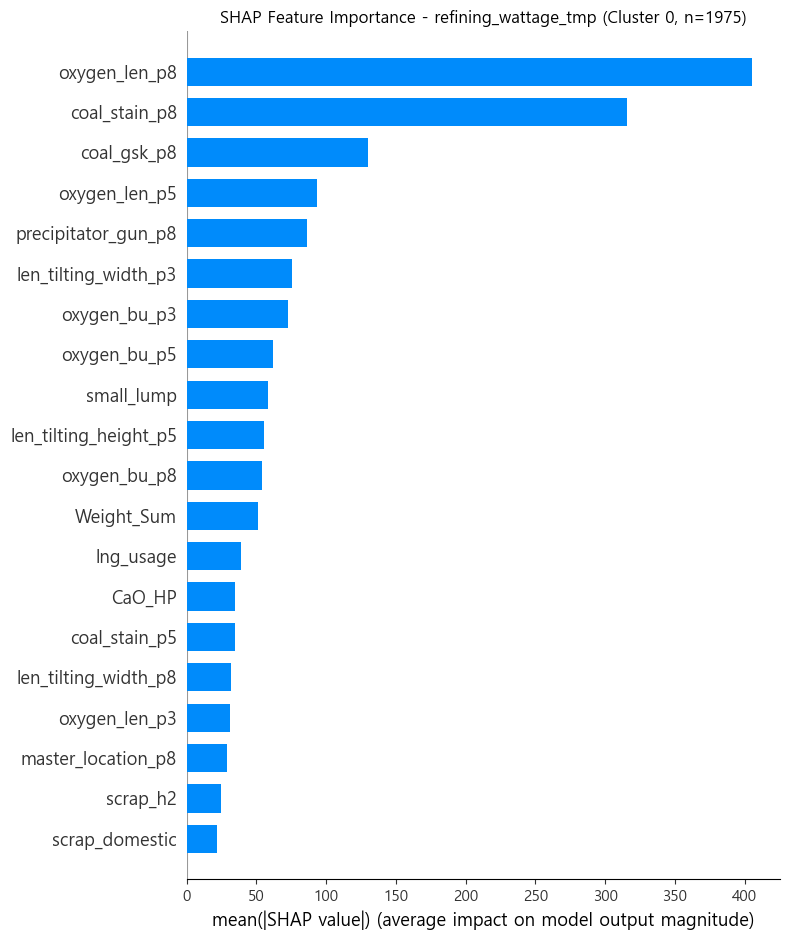

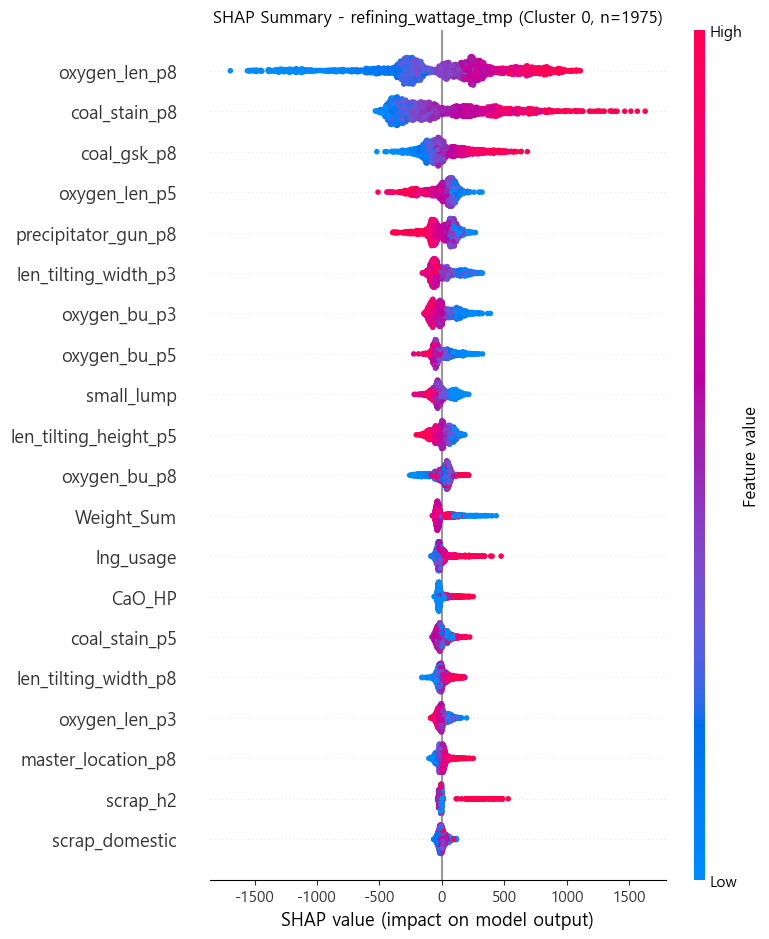


[Cluster 1] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     423.384094
48          coal_stain_p8     359.808228
45            coal_gsk_p8     195.358444
11    precipitator_gun_p8     103.879288
29           oxygen_bu_p8     102.890396
19          oxygen_len_p5      93.313576
25  len_tilting_height_p8      83.543739
28           oxygen_bu_p5      81.559586
4           Briquette_HP1      59.100533
42             small_lump      57.968204
41              lng_usage      54.736095
47          coal_stain_p5      45.519848
27           oxygen_bu_p3      42.415432
17     master_location_p8      40.345253
22   len_tilting_width_p3      37.159672
44            coal_gsk_p5      34.291412
18          oxygen_len_p3      31.079287
23  len_tilting_height_p5      28.816034
12   precipitator_wind_p3      28.071323
5           Briquette_HP2      26.968111


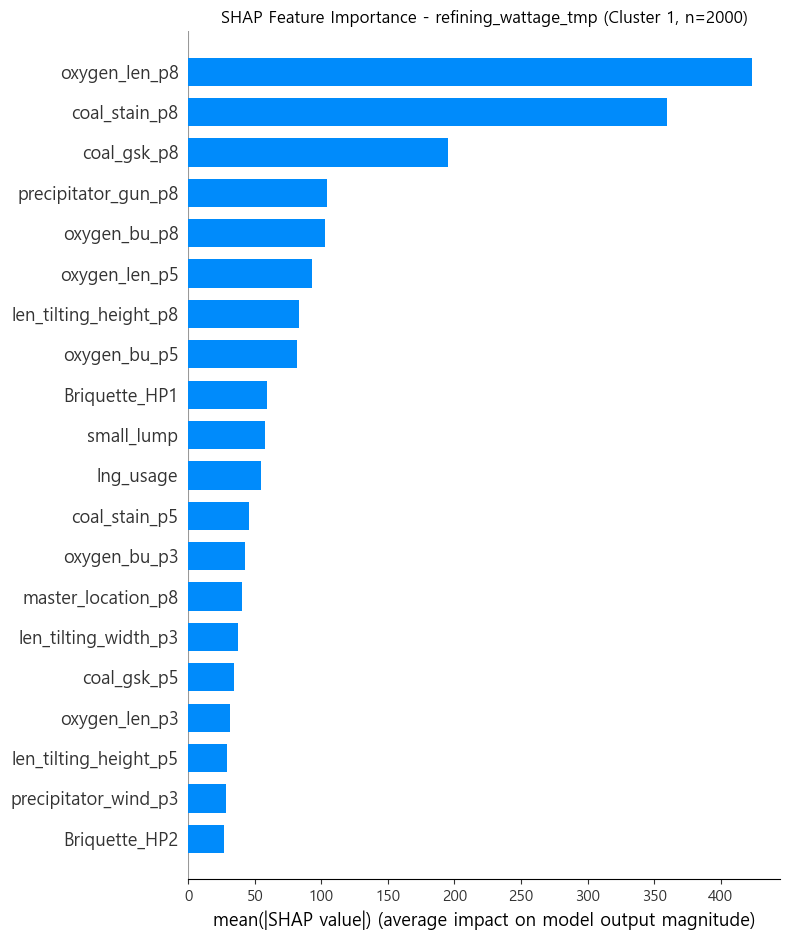

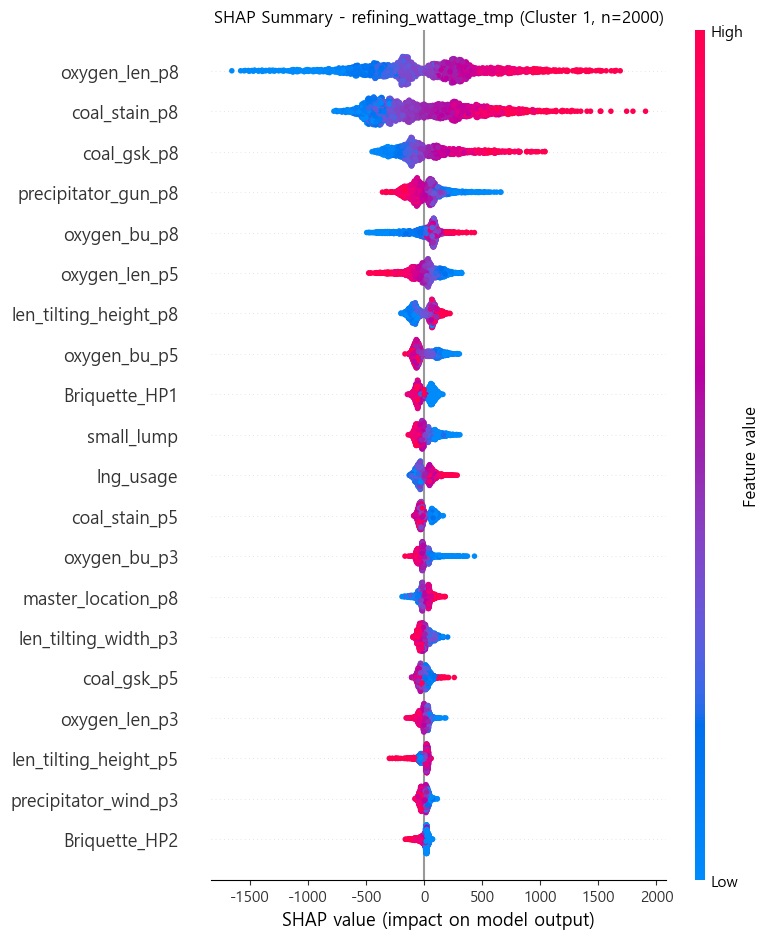


[전체] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     414.334412
48          coal_stain_p8     337.921143
45            coal_gsk_p8     163.025345
11    precipitator_gun_p8      95.292091
19          oxygen_len_p5      93.538734
29           oxygen_bu_p8      78.466148
28           oxygen_bu_p5      71.801476
42             small_lump      58.229183
27           oxygen_bu_p3      57.448654
22   len_tilting_width_p3      56.323666
25  len_tilting_height_p8      52.725708
41              lng_usage      46.931164
23  len_tilting_height_p5      42.126884
47          coal_stain_p5      40.071918
4           Briquette_HP1      39.116405
30             Weight_Sum      37.707088
17     master_location_p8      34.696655
18          oxygen_len_p3      30.903143
44            coal_gsk_p5      27.891273
26   len_tilting_width_p8      25.035471


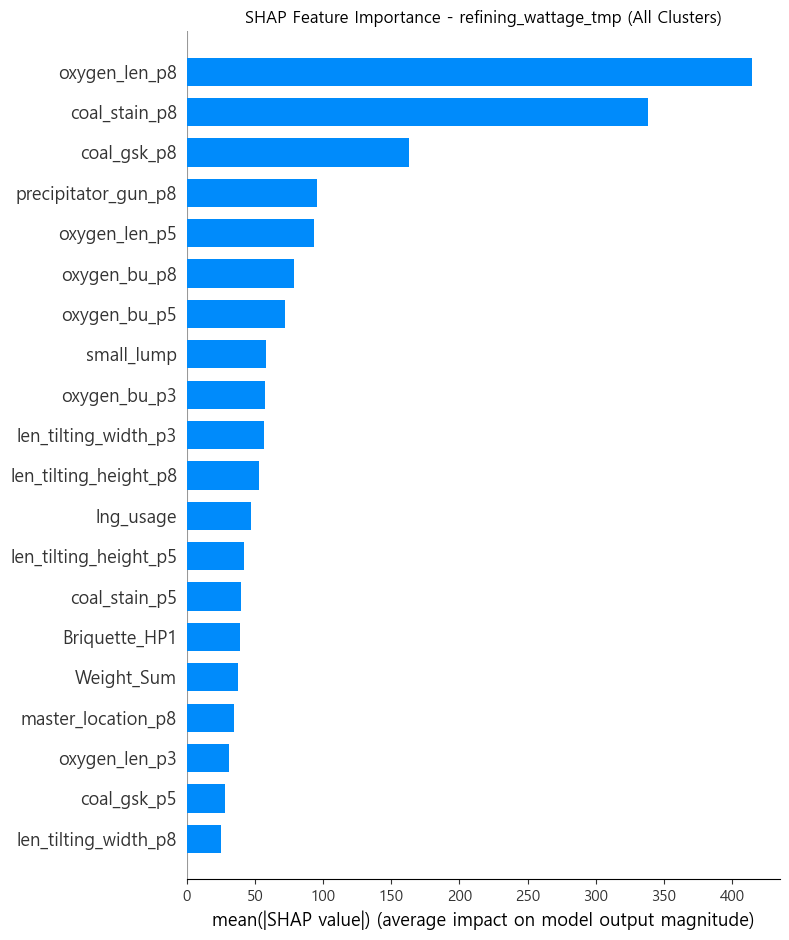

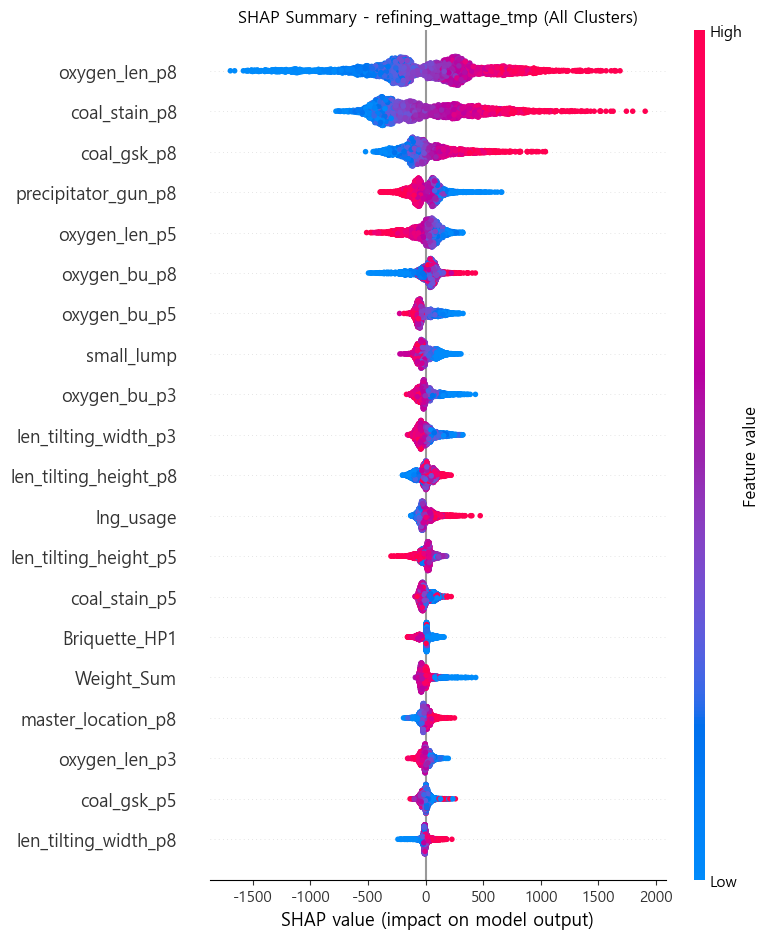

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== SHAP 설정 =====
SHAP_DATA = "train"   # "train" or "test"
SHAP_SAMPLE = 2000    # 클러스터별 최대 샘플 수
RANDOM_STATE = 42

if SHAP_DATA == "train":
    X_base = X_train
    clusters_base = train_clusters
else:
    X_base = X_test
    clusters_base = test_clusters

# 전체(클러스터 평균)용 누적
all_shap = []
all_X = []

for c, model_c in models.items():
    mask = clusters_base == c
    X_c = X_base[mask]
    if len(X_c) == 0:
        print(f"[Cluster {c}] 데이터 없음 - skip")
        continue

    if len(X_c) > SHAP_SAMPLE:
        X_c = X_c.sample(SHAP_SAMPLE, random_state=RANDOM_STATE)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model_c)
    shap_values = explainer.shap_values(X_c)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # 평균 |SHAP| 정렬 (표 형태)
    mean_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        "feature": X_c.columns,
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False)
    print(f"\n[Cluster {c}] SHAP 평균 중요도 Top 20")
    print(shap_df.head(20))

    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_c, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {TARGETS[0]} (Cluster {c}, n={len(X_c)})")
    plt.tight_layout()
    plt.show()

    # Beeswarm plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_c, show=False)
    plt.title(f"SHAP Summary - {TARGETS[0]} (Cluster {c}, n={len(X_c)})")
    plt.tight_layout()
    plt.show()

    # 전체 평균용 누적
    all_shap.append(shap_values)
    all_X.append(X_c)

# ===== 클러스터 전체 평균 SHAP =====
if len(all_shap) > 0:
    shap_all = np.vstack(all_shap)
    X_all = pd.concat(all_X, axis=0)

    mean_abs_all = np.abs(shap_all).mean(axis=0)
    shap_df_all = pd.DataFrame({
        "feature": X_all.columns,
        "mean_abs_shap": mean_abs_all
    }).sort_values("mean_abs_shap", ascending=False)

    print("\n[전체] SHAP 평균 중요도 Top 20")
    print(shap_df_all.head(20))

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_all, X_all, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {TARGETS[0]} (All Clusters)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_all, X_all, show=False)
    plt.title(f"SHAP Summary - {TARGETS[0]} (All Clusters)")
    plt.tight_layout()
    plt.show()


In [10]:
# 클러스터별 예측
y_pred_train = np.empty(len(X_train))
y_pred_test = np.empty(len(X_test))

for c, model_c in models.items():
    # Train 예측
    train_mask = train_clusters == c
    if train_mask.sum() > 0:
        y_pred_train[train_mask] = model_c.predict(X_train[train_mask])
    
    # Test 예측
    test_mask = test_clusters == c
    if test_mask.sum() > 0:
        y_pred_test[test_mask] = model_c.predict(X_test[test_mask])

y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()

targets_to_evaluate = [(TARGETS[0], y_train_array, y_test_array, 
                        y_pred_train, y_pred_test)]

# 성능 평가
print("=" * 70)
print(f"모델 성능 평가 (GMM {best_n}그룹 분할 학습)")
print("=" * 70)

for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    test_mape = np.mean(np.abs((y_te - y_pred_te) / (y_te + 1e-9))) * 100
    test_smape = 100 / len(y_te) * np.sum(2 * np.abs(y_pred_te - y_te) / (np.abs(y_te) + np.abs(y_pred_te) + 1e-9))

    print(f"\n【{target_name}】")
    print(f"  Train RMSE: {train_rmse:.4f}  |  Train R²: {train_r2:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}  |  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE:   {test_mae:.4f}")
    print(f"  Test MAPE:  {test_mape:.2f}%")
    print(f"  Test SMAPE: {test_smape:.2f}%")
    
    overfitting = train_r2 - test_r2
    print(f"  과적합 체크 (R² 차이): {overfitting:.4f}", end="")
    if overfitting > 0.1:
        print("  ⚠️ 과적합 가능성")
    else:
        print("  ✅")

모델 성능 평가 (GMM 2그룹 분할 학습)

【refining_wattage_tmp】
  Train RMSE: 416.6859  |  Train R²: 0.9091
  Test RMSE:  816.0628  |  Test R²:  0.6590
  Test MAE:   602.6972
  Test MAPE:  7.22%
  Test SMAPE: 7.25%
  과적합 체크 (R² 차이): 0.2501  ⚠️ 과적합 가능성


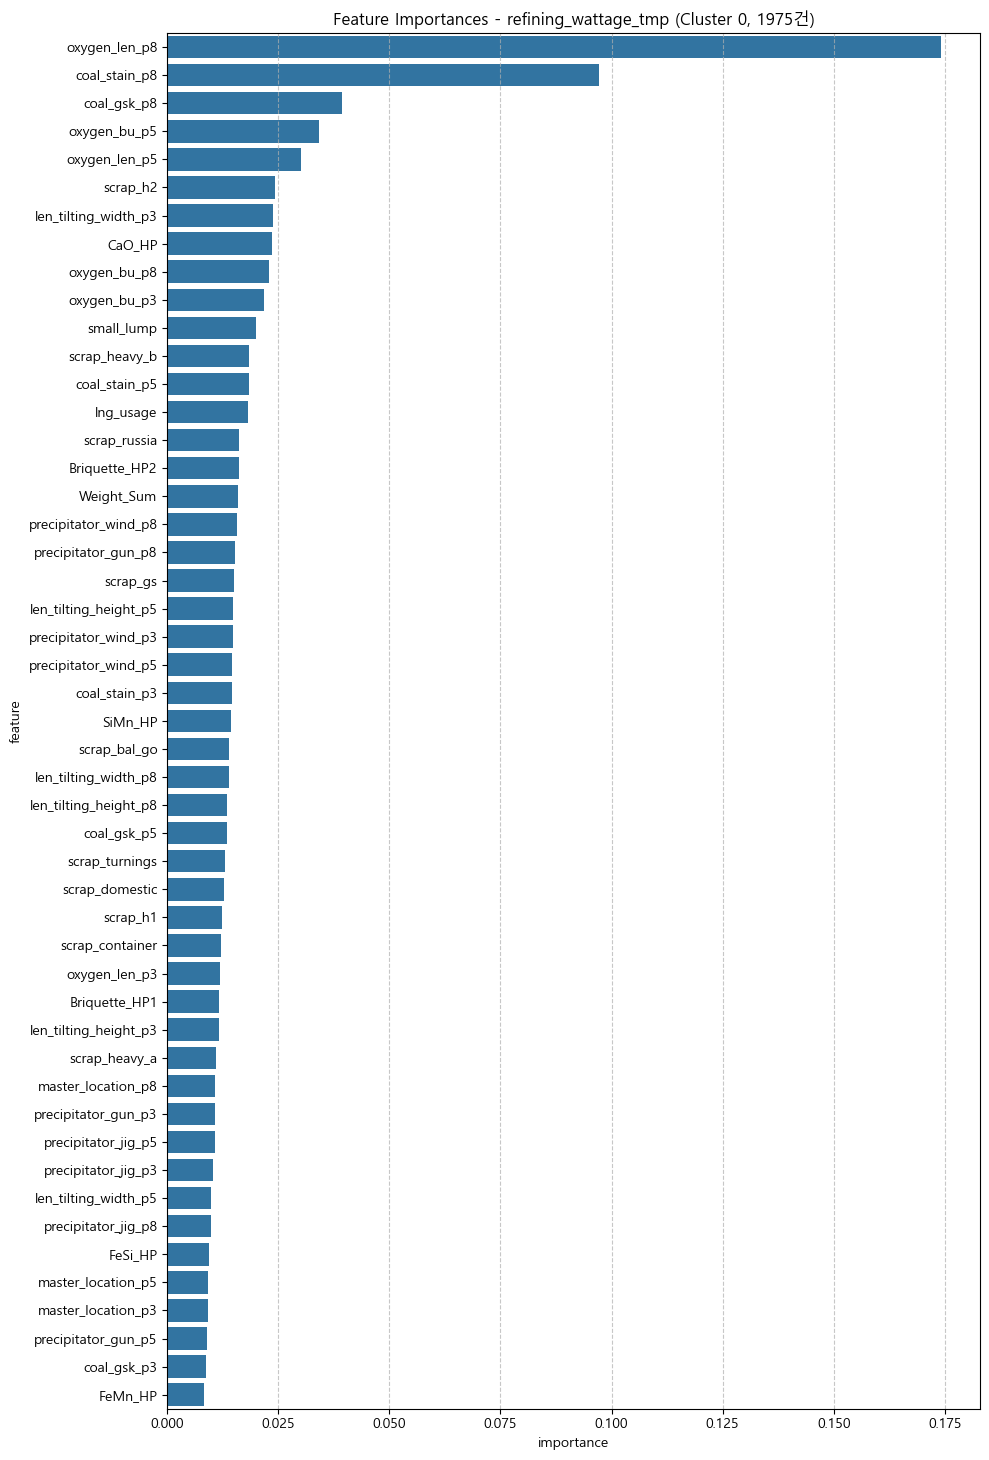


[Cluster 0 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.174224
48          coal_stain_p8    0.097167
45            coal_gsk_p8    0.039251
28           oxygen_bu_p5    0.034141
19          oxygen_len_p5    0.029998
36               scrap_h2    0.024180
22   len_tilting_width_p3    0.023875
0                  CaO_HP    0.023535
29           oxygen_bu_p8    0.022892
27           oxygen_bu_p3    0.021702
42             small_lump    0.019963
38          scrap_heavy_b    0.018475
47          coal_stain_p5    0.018315
41              lng_usage    0.018119
39           scrap_russia    0.016244
5           Briquette_HP2    0.016221
30             Weight_Sum    0.015875
14   precipitator_wind_p8    0.015625
11    precipitator_gun_p8    0.015176
34               scrap_gs    0.015010
23  len_tilting_height_p5    0.014857
12   precipitator_wind_p3    0.014824
13   precipitator_wind_p5    0.014655
46          coal_stain_p3    0.014571
3                 SiMn_HP  

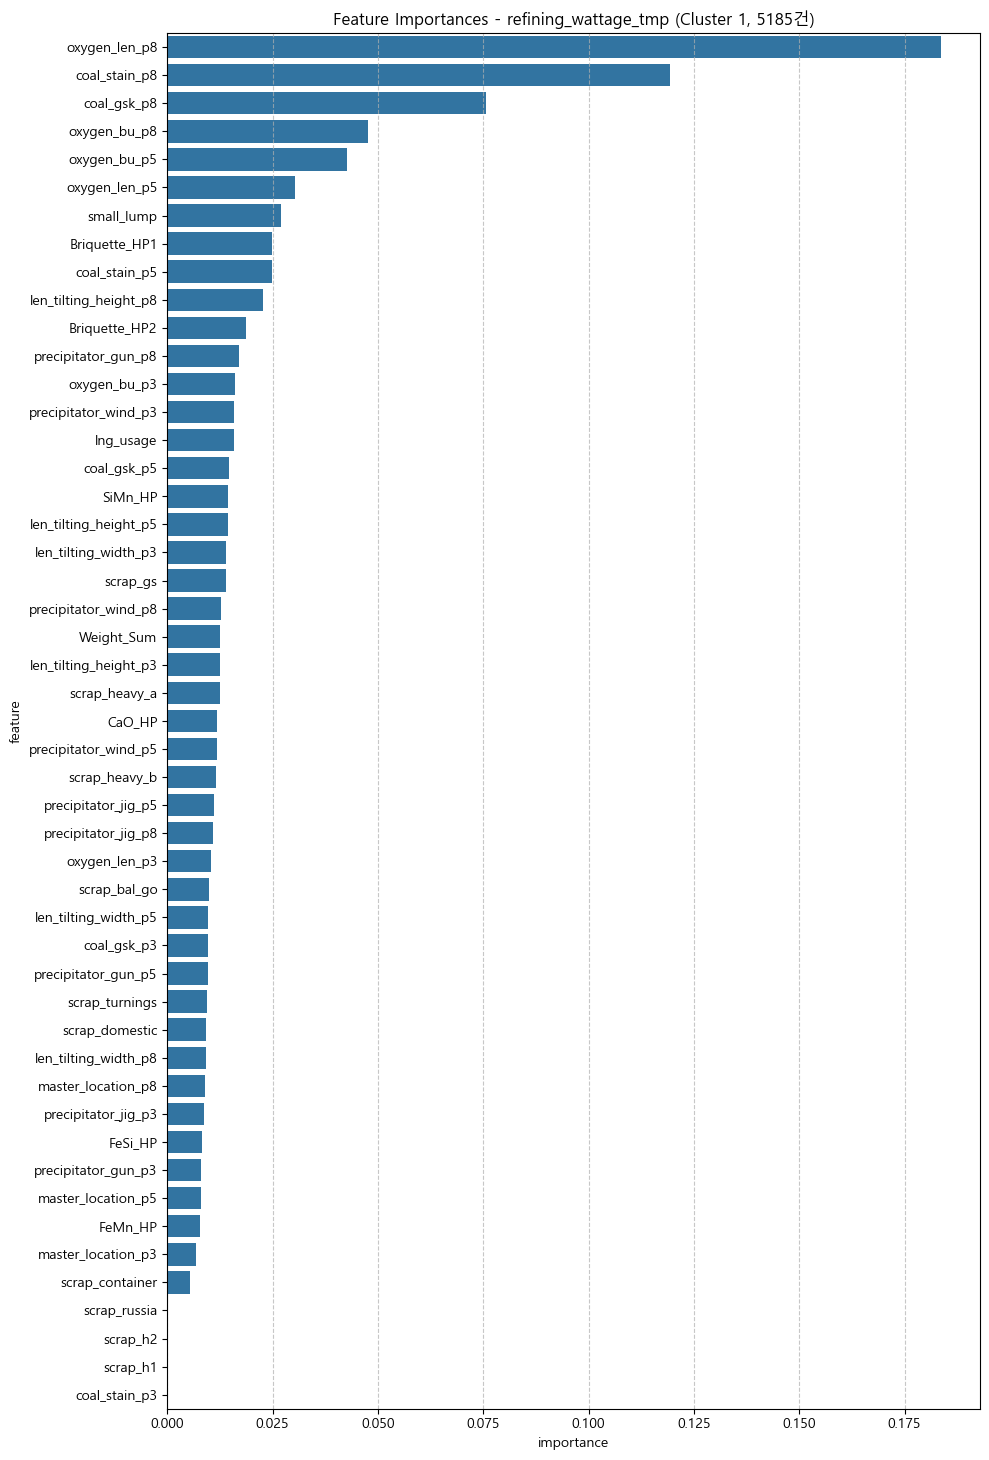


[Cluster 1 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.183726
48          coal_stain_p8    0.119360
45            coal_gsk_p8    0.075619
29           oxygen_bu_p8    0.047749
28           oxygen_bu_p5    0.042556
19          oxygen_len_p5    0.030265
42             small_lump    0.027051
4           Briquette_HP1    0.024893
47          coal_stain_p5    0.024854
25  len_tilting_height_p8    0.022794
5           Briquette_HP2    0.018575
11    precipitator_gun_p8    0.016933
27           oxygen_bu_p3    0.016001
12   precipitator_wind_p3    0.015844
41              lng_usage    0.015803
44            coal_gsk_p5    0.014695
3                 SiMn_HP    0.014393
23  len_tilting_height_p5    0.014383
22   len_tilting_width_p3    0.014007
34               scrap_gs    0.013846
14   precipitator_wind_p8    0.012748
30             Weight_Sum    0.012543
21  len_tilting_height_p3    0.012519
37          scrap_heavy_a    0.012450
0                  CaO_HP  

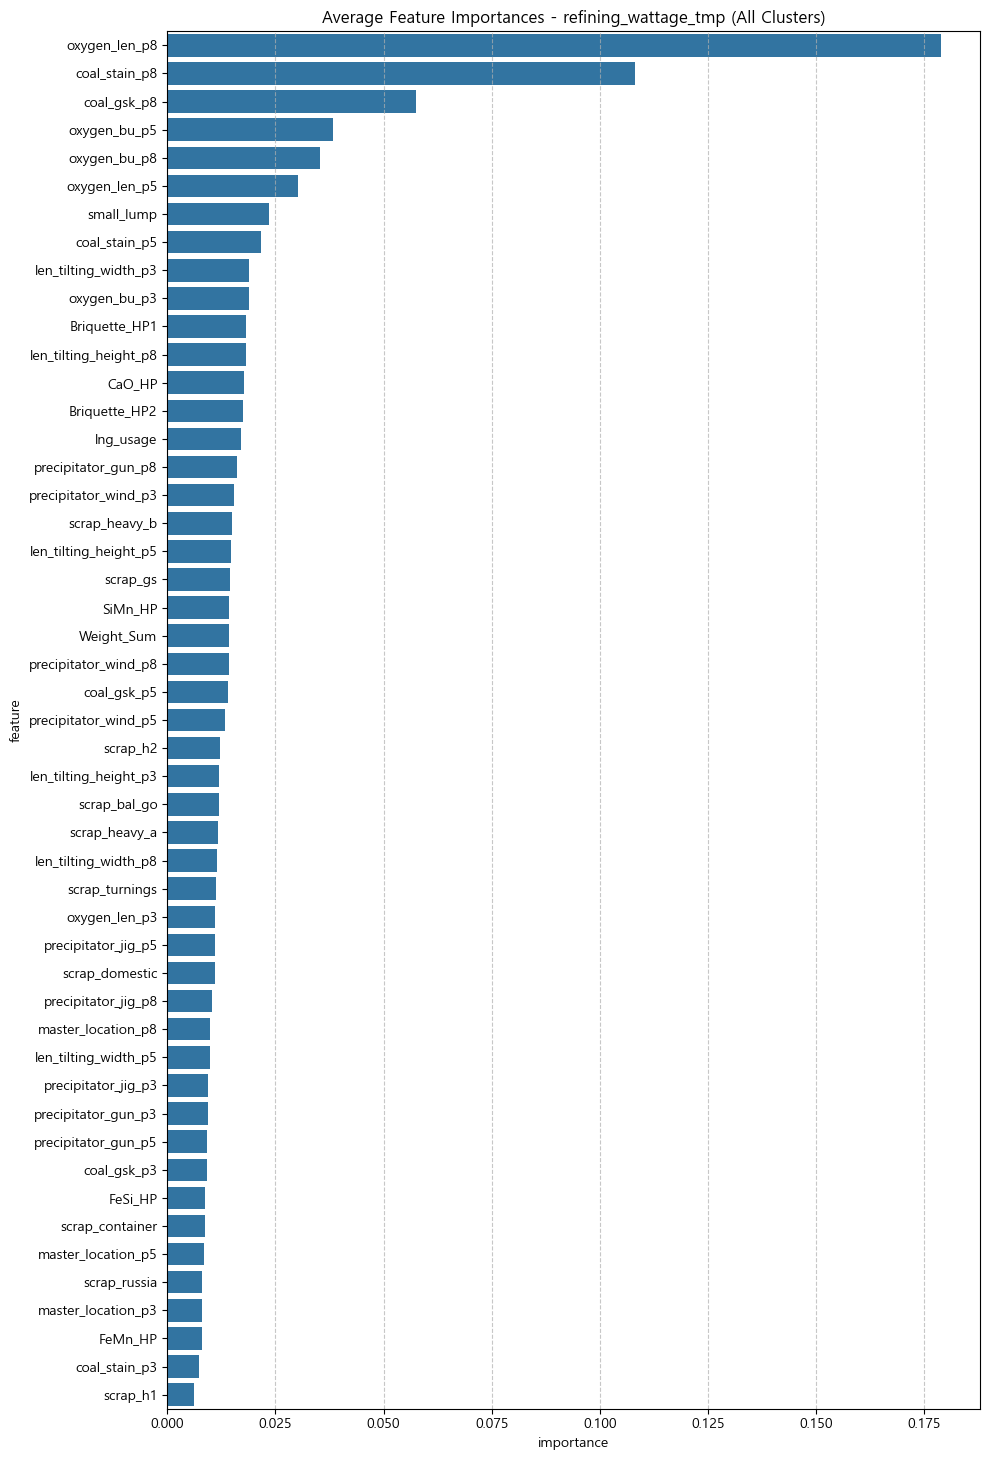


[전체 평균 변수 중요도 순위]
                  feature  importance
0           oxygen_len_p8    0.178975
1           coal_stain_p8    0.108264
2             coal_gsk_p8    0.057435
3            oxygen_bu_p5    0.038348
4            oxygen_bu_p8    0.035321
5           oxygen_len_p5    0.030132
6              small_lump    0.023507
7           coal_stain_p5    0.021585
8    len_tilting_width_p3    0.018941
9            oxygen_bu_p3    0.018851
10          Briquette_HP1    0.018283
11  len_tilting_height_p8    0.018154
12                 CaO_HP    0.017722
13          Briquette_HP2    0.017398
14              lng_usage    0.016961
15    precipitator_gun_p8    0.016054
16   precipitator_wind_p3    0.015334
17          scrap_heavy_b    0.015047
18  len_tilting_height_p5    0.014620
19               scrap_gs    0.014428
20                SiMn_HP    0.014337
21             Weight_Sum    0.014209
22   precipitator_wind_p8    0.014186
23            coal_gsk_p5    0.014092
24   precipitator_wind_p5    0.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 클러스터별 변수 중요도 추출 및 시각화
for c, model_c in models.items():
    importances = model_c.feature_importances_
    feature_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, len(X_train.columns) * 0.3))
    sns.barplot(x='importance', y='feature', data=feature_df)
    plt.title(f'Feature Importances - {TARGETS[0]} (Cluster {c}, {(train_clusters == c).sum()}건)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n[Cluster {c} 변수 중요도 순위]")
    print(feature_df)
    print()

# 전체 평균 중요도
avg_importances = np.mean([m.feature_importances_ for m in models.values()], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, len(X_train.columns) * 0.3))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances - {TARGETS[0]} (All Clusters)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\n[전체 평균 변수 중요도 순위]")
print(feature_importance_df)

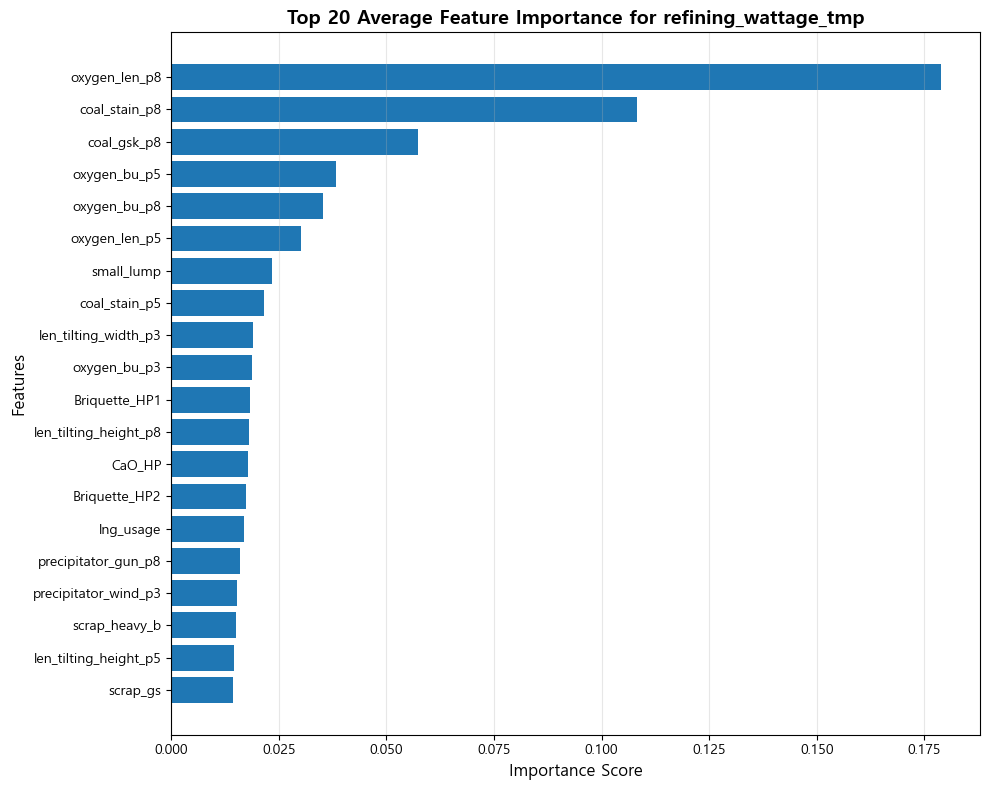

In [12]:
# Feature Importance Top 20 시각화 (평균 기준)
top_n = 20

plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Average Feature Importance for {TARGETS[0]}', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

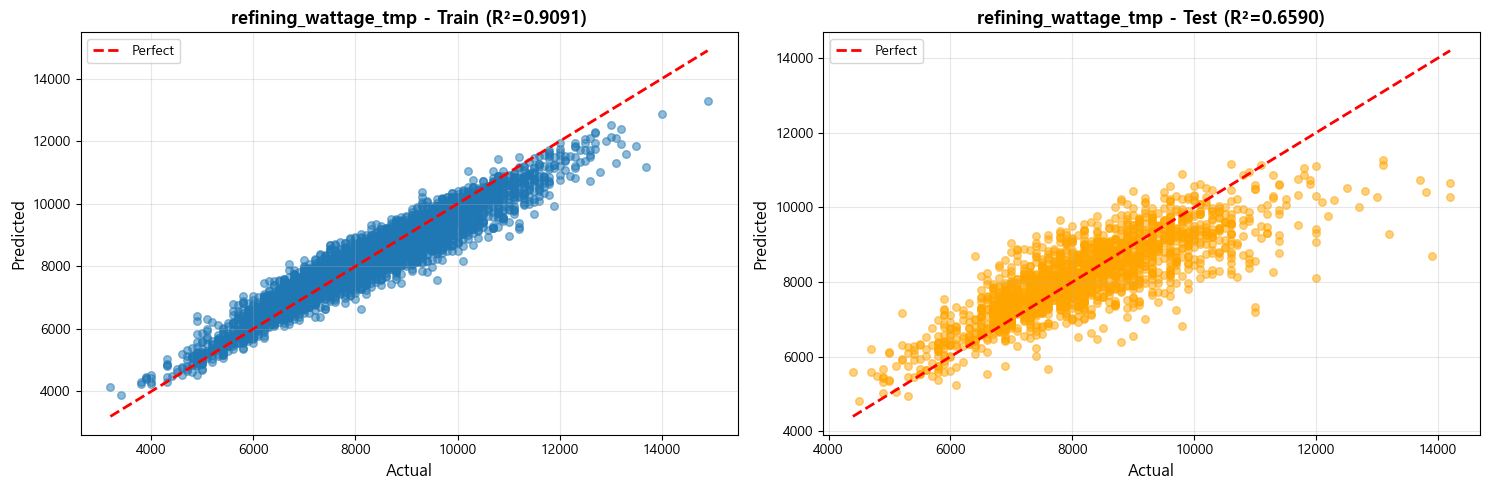

In [13]:
# 예측 vs 실제 시각화
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))

# 타겟이 1개일 때 axes 차원 조정
if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    
    # Train set
    axes[idx, 0].scatter(y_tr, y_pred_tr, alpha=0.5, s=30)
    axes[idx, 0].plot([y_tr.min(), y_tr.max()],
                      [y_tr.min(), y_tr.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 0].set_xlabel('Actual', fontsize=12)
    axes[idx, 0].set_ylabel('Predicted', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Train (R²={train_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Test set
    axes[idx, 1].scatter(y_te, y_pred_te, alpha=0.5, s=30, color='orange')
    axes[idx, 1].plot([y_te.min(), y_te.max()],
                      [y_te.min(), y_te.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 1].set_xlabel('Actual', fontsize=12)
    axes[idx, 1].set_ylabel('Predicted', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Test (R²={test_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

print("교차 검증 수행 중 (GMM 분할 학습)...")

N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train = y.values.ravel()[train_idx]
    y_cv_val   = y.values.ravel()[val_idx]

    # (중요) fold 기준으로 스케일러 fit -> leakage 방지 + GMM 안정화
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_cv_train.values)
    X_va_s = sc.transform(X_cv_val.values)

    # GMM은 스케일된 X로
    gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    cv_train_clusters = gmm_cv.fit_predict(X_tr_s)
    cv_val_clusters   = gmm_cv.predict(X_va_s)

    # 1) global 모델(폴드 fallback)
    global_params = dict(params)
    global_params.update({"nthread": 4})  # 안정성
    global_model = xgb.XGBRegressor(**global_params)
    global_model.fit(X_cv_train, y_cv_train, verbose=False)

    y_cv_pred = global_model.predict(X_cv_val)  # 기본값을 global로 깔아둠

    # 2) 클러스터별로 있으면 덮어쓰기
    for c in range(best_n):
        tr_mask = (cv_train_clusters == c)
        va_mask = (cv_val_clusters == c)

        # 최소 샘플 조건(너무 작은 클러스터는 학습하지 않음)
        if tr_mask.sum() < 50 or va_mask.sum() == 0:
            continue

        m = xgb.XGBRegressor(**global_params)
        m.fit(X_cv_train.iloc[tr_mask], y_cv_train[tr_mask], verbose=False)
        y_cv_pred[va_mask] = m.predict(X_cv_val.iloc[va_mask])

        del m
        gc.collect()

    fold_r2 = r2_score(y_cv_val, y_cv_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_r2_scores.append(fold_r2)

    print(f"  Fold {fold}: R² = {fold_r2:.4f}, RMSE = {fold_rmse:.4f}")

    del global_model, gmm_cv
    gc.collect()

print("=" * 50)
print(f"{N_SPLITS}5-Fold CV 평균 R²: {np.mean(cv_r2_scores):.4f} (±{np.std(cv_r2_scores):.4f})")
print("=" * 50)


교차 검증 수행 중 (GMM 분할 학습)...
  Fold 1: R² = 0.6589, RMSE = 816.1274
  Fold 2: R² = 0.7191, RMSE = 728.8012
  Fold 3: R² = 0.7111, RMSE = 737.7266
  Fold 4: R² = 0.6926, RMSE = 780.5957
  Fold 5: R² = 0.6618, RMSE = 797.7168
55-Fold CV 평균 R²: 0.6887 (±0.0247)



【refining_wattage_tmp 잔차 통계】
  평균: 60.5873
  표준편차: 813.8106
  최대값: 5195.6289
  최소값: -2304.0371

💾 저장 완료: residuals_refining_wattage_tmp.png


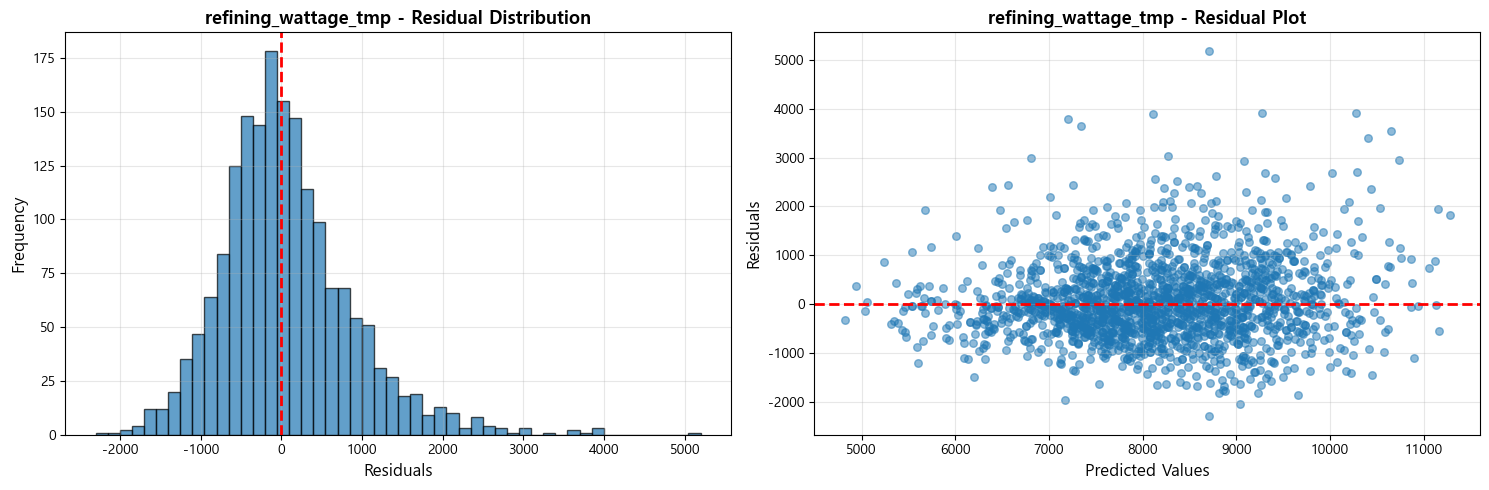

In [15]:
# 잔차 분석
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))
# 각 타겟별로 2개 그래프 (분포 히스토그램, 잔차 플롯)

if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    residuals_test = y_te - y_pred_te  # 잔차 = 실제값 - 예측값
    # 양수: 과소예측 (실제가 더 큼)
    # 음수: 과대예측 (예측이 더 큼)
    
    # ===== 왼쪽: 잔차 분포 히스토그램 =====
    axes[idx, 0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    # hist: 히스토그램 (막대 그래프)
    #   - bins=50: 50개 구간으로 나눔
    #   - edgecolor='black': 막대 테두리 색
    #   - alpha=0.7: 투명도 70%
    
    axes[idx, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    # axvline: 수직선 그리기
    #   - x=0 위치에 빨간 점선
    #   - 이상적으로는 이 선을 중심으로 대칭이어야 함
    
    axes[idx, 0].set_xlabel('Residuals', fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Residual Distribution', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # ===== 오른쪽: 잔차 vs 예측값 산점도 =====
    axes[idx, 1].scatter(y_pred_te, residuals_test, alpha=0.5, s=30)
    # x축: 예측값
    # y축: 잔차
    # 패턴 없이 무작위로 흩어져야 좋은 모델
    
    axes[idx, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    # axhline: 수평선 그리기
    #   - y=0 위치 (잔차 0)
    #   - 점들이 이 선 주위에 랜덤하게 분포해야 함
    
    axes[idx, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_ylabel('Residuals', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Residual Plot', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # 통계 정보 출력
    print(f"\n【{target_name} 잔차 통계】")
    print(f"  평균: {residuals_test.mean():.4f}")
    # 평균이 0에 가까워야 함 (편향 없음)
    
    print(f"  표준편차: {residuals_test.std():.4f}")
    # 오차의 퍼진 정도
    
    print(f"  최대값: {residuals_test.max():.4f}")
    # 가장 크게 과소예측한 경우
    
    print(f"  최소값: {residuals_test.min():.4f}")
    # 가장 크게 과대예측한 경우

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.savefig(f'residuals_{targets_str}.png', dpi=300, bbox_inches='tight')
print(f"\n💾 저장 완료: residuals_{targets_str}.png")
plt.show()

In [16]:
from datetime import datetime

print("=" * 80)
print("XGBoost 모델 학습 결과 요약 (GMM 분할 학습)")
print("=" * 80)

print(f"\n【실험 정보】")
print(f"  실험 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  타겟 변수: {', '.join(TARGETS)}")
print(f"  GMM 클러스터 수: {best_n}")
print(f"  총 데이터 개수: {len(df_model)}")
print(f"  Train 데이터: {len(X_train)} ({len(X_train)/len(df_model)*100:.1f}%)")
print(f"  Test 데이터: {len(X_test)} ({len(X_test)/len(df_model)*100:.1f}%)")

print(f"\n【클러스터 분포】")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

print(f"\n【데이터 전처리】")
print(f"  결측치 → 0 (미투입 처리)")

print(f"\n【특성 정보】")
print(f"  총 특성 개수: {len(SELECTED_FEATURES)}")

print(f"\n【하이퍼파라미터】")
for key, value in params.items():
    print(f"  {key:25s}: {value}")

print(f"\n【모델 성능】")
for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    train_mae = mean_absolute_error(y_tr, y_pred_tr)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    
    print(f"\n  ▶ {target_name}")
    print(f"    Train - RMSE: {train_rmse:>10.4f}  |  R²: {train_r2:>6.4f}  |  MAE: {train_mae:>10.4f}")
    print(f"    Test  - RMSE: {test_rmse:>10.4f}  |  R²: {test_r2:>6.4f}  |  MAE: {test_mae:>10.4f}")
    
    overfitting = train_r2 - test_r2
    if overfitting > 0.1:
        print(f"    ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"    ✅  과적합 없음 (R² 차이: {overfitting:.4f})")
    
    print(f"    타겟 범위: {y_te.min():.2f} ~ {y_te.max():.2f}")
    print(f"    타겟 평균: {y_te.mean():.2f} (표준편차: {y_te.std():.2f})")

print(f"\n【주요 특성 (Top 10, 평균 중요도)】")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:25s}  중요도: {row['importance']:.6f}")

print("\n" + "=" * 80)

XGBoost 모델 학습 결과 요약 (GMM 분할 학습)

【실험 정보】
  실험 일시: 2026-02-06 11:33:25
  타겟 변수: refining_wattage_tmp
  GMM 클러스터 수: 2
  총 데이터 개수: 8950
  Train 데이터: 7160 (80.0%)
  Test 데이터: 1790 (20.0%)

【클러스터 분포】
  Cluster 0: Train 1975건, Test 480건
  Cluster 1: Train 5185건, Test 1310건

【데이터 전처리】
  결측치 → 0 (미투입 처리)

【특성 정보】
  총 특성 개수: 49

【하이퍼파라미터】
  objective                : reg:squarederror
  random_state             : 42
  tree_method              : hist
  device                   : cuda
  sampling_method          : gradient_based
  max_bin                  : 256
  max_depth                : 6
  learning_rate            : 0.01223826357909319
  n_estimators             : 800
  subsample                : 0.7
  colsample_bytree         : 0.6
  min_child_weight         : 6
  gamma                    : 5.0
  reg_alpha                : 1.0
  reg_lambda               : 6.0
  eval_metric              : rmse

【모델 성능】

  ▶ refining_wattage_tmp
    Train - RMSE:   416.6859  |  R²: 0.9091  |  MAE:   315.4982
   

In [17]:
class ExperimentLogger:
    """실험 결과를 자동으로 기록하는 클래스"""
    
    def __init__(self, log_file='experiment_log_xgb.json'):
        self.log_file = log_file
        self.experiments = []
        self.load_existing_logs()
    
    def load_existing_logs(self):
        """기존 로그 불러오기"""
        try:
            with open(self.log_file, 'r', encoding='utf-8') as f:
                self.experiments = json.load(f)
            print(f"✅ 기존 로그 {len(self.experiments)}개 불러옴: {self.log_file}")
        except FileNotFoundError:
            print(f"📝 새로운 로그 파일 생성: {self.log_file}")
            self.experiments = []
    
    def log_experiment(self, target, features, params, results, feature_importance=None):
        """실험 결과 기록"""
        experiment = {
            'experiment_id': len(self.experiments) + 1,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target': target,
            'n_features': len(features),
            'features': features,
            'params': params,
            'results': results,
            'feature_importance_top10': feature_importance
        }
        self.experiments.append(experiment)
        self.save()
        return experiment['experiment_id']
    
    def save(self):
        """로그 파일 저장"""
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.experiments, f, ensure_ascii=False, indent=2)
    
    def get_best_experiment(self, target, metric='test_r2'):
        """특정 타겟의 최고 성능 실험 찾기"""
        target_exps = [e for e in self.experiments if e['target'] == target]
        if not target_exps:
            return None
        return max(target_exps, key=lambda x: x['results'][metric])
    
    def print_summary(self):
        """전체 실험 요약"""
        if len(self.experiments) == 0:
            print("아직 실험 기록이 없습니다.")
            return
        
        print(f"\n{'='*80}")
        print(f"📊 실험 기록 요약")
        print(f"{'='*80}")
        print(f"총 실험 횟수: {len(self.experiments)}")
        print(f"로그 파일: {self.log_file}")
        print(f"{'='*80}\n")
        
        # 타겟별 최고 성능
        targets = set(e['target'] for e in self.experiments)
        for target in sorted(targets):
            best = self.get_best_experiment(target)
            if best:
                print(f"[{target}] 최고 성능 (실험 #{best['experiment_id']})")
                print(f"  Test R²:    {best['results']['test_r2']:.4f}")
                print(f"  Test MAPE:  {best['results'].get('test_mape', 0):.2f}%")  # ✨ 추가
                print(f"  Test SMAPE: {best['results'].get('test_smape', 0):.2f}%") # ✨ 추가
                print(f"  Test RMSE:  {best['results']['test_rmse']:.4f}")
                print(f"  CV R²:      {best['results']['cv_r2']:.4f}")
                print(f"  실험 시각:  {best['timestamp']}")
                print(f"  특성 개수:  {best['n_features']}")
                print(f"  주요 파라미터:")
                print(f"    - max_depth: {best['params']['max_depth']}")
                print(f"    - learning_rate: {best['params']['learning_rate']:.4f}")
                print(f"    - n_estimators: {best['params']['n_estimators']}")
                print(f"  Top 5 특성: {', '.join(best['feature_importance_top10'][:5])}")
                print()
    
    def get_experiments_df(self):
        """실험 결과를 DataFrame으로 변환"""
        if len(self.experiments) == 0:
            return pd.DataFrame()
        
        records = []
        for exp in self.experiments:
            record = {
                'exp_id': exp['experiment_id'],
                'timestamp': exp['timestamp'],
                'target': exp['target'],
                'n_features': exp['n_features'],
                'test_r2': exp['results']['test_r2'],
                'test_mape': exp['results'].get('test_mape'),   # ✨ 추가
                'test_smape': exp['results'].get('test_smape'), # ✨ 추가
                'test_rmse': exp['results']['test_rmse'],
                'cv_r2': exp['results']['cv_r2'],
                'max_depth': exp['params']['max_depth'],
                'learning_rate': exp['params']['learning_rate'],
                'n_estimators': exp['params']['n_estimators'],
            }
            records.append(record)
        
        return pd.DataFrame(records)

# 로거 초기화
logger = ExperimentLogger('experiment_log_xgb.json')
logger.print_summary()

✅ 기존 로그 7개 불러옴: experiment_log_xgb.json

📊 실험 기록 요약
총 실험 횟수: 7
로그 파일: experiment_log_xgb.json

[melting_wattage] 최고 성능 (실험 #2)
  Test R²:    0.7053
  Test MAPE:  0.94%
  Test SMAPE: 0.94%
  Test RMSE:  561.9262
  CV R²:      0.6924
  실험 시각:  2026-02-04 18:13:04
  특성 개수:  41
  주요 파라미터:
    - max_depth: 6
    - learning_rate: 0.0376
    - n_estimators: 900
  Top 5 특성: small_lump, Briquette_HP1, coal_gsk, oxygen_bu_p5, oxygen_len_p5

[melting_wattage_tmp] 최고 성능 (실험 #7)
  Test R²:    0.6327
  Test MAPE:  1.09%
  Test SMAPE: 1.09%
  Test RMSE:  534.0674
  CV R²:      0.6273
  실험 시각:  2026-02-06 11:28:07
  특성 개수:  39
  주요 파라미터:
    - max_depth: 6
    - learning_rate: 0.0240
    - n_estimators: 850
  Top 5 특성: oxygen_len_p5, Briquette_HP1, coal_stain_p5, small_lump, oxygen_bu_p5

[refining_wattage_tmp] 최고 성능 (실험 #4)
  Test R²:    0.6693
  Test MAPE:  7.09%
  Test SMAPE: 7.11%
  Test RMSE:  803.6452
  CV R²:      0.7044
  실험 시각:  2026-02-05 14:42:22
  특성 개수:  48
  주요 파라미터:
    - max_depth: 6
 

In [18]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

def objective(trial, target_name, X_data, y_data):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 900, step=50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 안정화 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4
    }

    N_SPLITS = 5  # 속도 개선(원하면 10으로)
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    fold_r2s = []

    X_df = X_data
    y_arr = y_data.values.ravel()

    for train_idx, val_idx in kf.split(X_df):
        X_tr = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_arr[train_idx]
        y_val = y_arr[val_idx]

        # fold별 스케일링 -> GMM 안정화/일관성
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr.values)
        X_val_s = sc.transform(X_val.values)

        # GMM은 스케일된 X로
        gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
        tr_clusters = gmm_cv.fit_predict(X_tr_s)
        val_clusters = gmm_cv.predict(X_val_s)

        # (핵심) global fallback으로 예측값을 먼저 채움
        global_model = xgb.XGBRegressor(**params)
        global_model.fit(X_tr, y_tr, verbose=False)
        y_pred = global_model.predict(X_val)

        # 클러스터별 덮어쓰기(조건 만족 시에만)
        MIN_CLUSTER = 100
        for c in range(best_n):
            tr_mask = (tr_clusters == c)
            val_mask = (val_clusters == c)

            if tr_mask.sum() < MIN_CLUSTER or val_mask.sum() == 0:
                continue

            m = xgb.XGBRegressor(**params)
            m.fit(X_tr.iloc[tr_mask], y_tr[tr_mask], verbose=False)
            y_pred[val_mask] = m.predict(X_val.iloc[val_mask])

            del m
            gc.collect()

        fold_r2s.append(r2_score(y_val, y_pred))

        del global_model, gmm_cv, sc
        gc.collect()

    return float(np.mean(fold_r2s))


In [19]:
# 필요한 import (없으면 추가)
import numpy as np
import pandas as pd
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_optimization(target_name, n_trials=100, timeout=None):
    """GMM 분할 학습 기반 하이퍼파라미터 자동 최적화"""

    print(f"\n{'='*80}")
    print(f"[{target_name}] 하이퍼파라미터 최적화 시작 (GMM {best_n}그룹)")
    print(f"{'='*80}")
    print(f"시도 횟수: {n_trials}")
    if timeout:
        print(f"최대 시간: {timeout}초")
    print(f"{'='*80}\n")

    TARGETS_OPTUNA = [target_name]
    df_model_optuna = df_processed.dropna(subset=TARGETS_OPTUNA)

    X_data = df_model_optuna[SELECTED_FEATURES]
    y_data = df_model_optuna[target_name]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    print(f"전체 데이터: {len(X_data)}")
    print(f"학습용: {len(X_tr)} | 테스트용: {len(X_te)}")
    print(f"특성 개수: {len(SELECTED_FEATURES)}\n")

    study = optuna.create_study(
        direction='maximize',
        study_name=f'{target_name}_gmm_opt_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )

    study.optimize(
        lambda trial: objective(trial, target_name, X_tr, y_tr),
        n_trials=n_trials,
        timeout=timeout,
        n_jobs=1,
        show_progress_bar=True
    )

    print(f"\n{'='*80}")
    print(f"최적화 완료! 최고 CV R²: {study.best_value:.4f}")
    print(f"{'='*80}")
    print(f"\n최적 하이퍼파라미터:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:25s}: {value:.6f}")
        else:
            print(f"  {key:25s}: {value}")

    # 최적 파라미터로 GMM 분할 학습
    print(f"\n{'='*80}")
    print(f"최적 파라미터로 최종 모델 학습 중 (GMM {best_n}그룹)...")
    print(f"{'='*80}\n")

    opt_params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 완주 확인 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4,
        **study.best_params
    }

    # GMM 분할 (스케일링 일관화)
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr.values)
    X_te_s = sc.transform(X_te.values)

    gmm_opt = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_opt.fit_predict(X_tr_s)
    te_clusters = gmm_opt.predict(X_te_s)

    # (1) 전역 모델로 기본 예측값 채우기 (미할당 방지)
    global_model = xgb.XGBRegressor(**opt_params)
    global_model.fit(X_tr, y_tr.values, verbose=False)

    y_pred_tr = global_model.predict(X_tr)
    y_pred_te = global_model.predict(X_te)

    # (2) 클러스터별 모델이 있으면 덮어쓰기
    opt_models = {'global': global_model}
    MIN_CLUSTER = 100  # objective와 맞추는 걸 권장

    for c in range(best_n):
        tr_mask = (tr_clusters == c)
        te_mask = (te_clusters == c)

        if tr_mask.sum() < MIN_CLUSTER:
            continue  # 너무 작은 클러스터는 건너뛰고 global 유지

        m = xgb.XGBRegressor(**opt_params)
        m.fit(X_tr.loc[tr_mask], y_tr.values[tr_mask], verbose=False)
        opt_models[c] = m

        # train 덮어쓰기
        y_pred_tr[tr_mask] = m.predict(X_tr.loc[tr_mask])
        # test 덮어쓰기 (있을 때만)
        if te_mask.sum() > 0:
            y_pred_te[te_mask] = m.predict(X_te.loc[te_mask])

        del m
        gc.collect()

    def get_mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    def get_smape(y_true, y_pred):
        return 100 / len(y_true) * np.sum(
            2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
        )

    results = {
        'train_rmse': float(np.sqrt(mean_squared_error(y_tr, y_pred_tr))),
        'test_rmse': float(np.sqrt(mean_squared_error(y_te, y_pred_te))),
        'train_r2': float(r2_score(y_tr, y_pred_tr)),
        'test_r2': float(r2_score(y_te, y_pred_te)),
        'test_mae': float(mean_absolute_error(y_te, y_pred_te)),
        'test_mape': float(get_mape(y_te.values, y_pred_te)),
        'test_smape': float(get_smape(y_te.values, y_pred_te)),
        'cv_r2': float(study.best_value),
        'n_trials': len(study.trials),
        'gmm_n_components': best_n,
    }

    print("최종 모델 성능:")
    print(f"  Train R²:   {results['train_r2']:.4f}  |  RMSE: {results['train_rmse']:.4f}")
    print(f"  Test R²:    {results['test_r2']:.4f}  |  RMSE: {results['test_rmse']:.4f}")
    print(f"  Test MAE:   {results['test_mae']:.4f}")
    print(f"  Test MAPE:  {results['test_mape']:.2f}%")
    print(f"  Test SMAPE: {results['test_smape']:.2f}%")
    print(f"  CV R²:      {results['cv_r2']:.4f}")

    overfitting = results['train_r2'] - results['test_r2']
    if overfitting > 0.1:
        print(f"  ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"  ✅  과적합 없음 (R² 차이: {overfitting:.4f})")

    # Feature Importance (평균) - 클러스터 모델 없으면 global 사용
    cluster_models = [m for k, m in opt_models.items() if k != 'global']
    if len(cluster_models) > 0:
        avg_imp = np.mean([m.feature_importances_ for m in cluster_models], axis=0)
    else:
        avg_imp = opt_models['global'].feature_importances_

    feature_importance = pd.DataFrame({
        'feature': SELECTED_FEATURES,
        'importance': avg_imp
    }).sort_values('importance', ascending=False)

    print(f"\n주요 특성 Top 10:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {idx+1:2d}. {row['feature']:25s}  {row['importance']:.6f}")

    top10_features = feature_importance.head(10)['feature'].tolist()

    exp_id = logger.log_experiment(
        target=target_name,
        features=SELECTED_FEATURES,
        params=opt_params,
        results=results,
        feature_importance=top10_features
    )

    print(f"\n실험 결과 저장 완료 (실험 번호: #{exp_id})")

    return study, opt_models, results

print("최적화 함수 정의 완료 (GMM 분할 학습)")


최적화 함수 정의 완료 (GMM 분할 학습)


In [20]:
# ===== 여기를 수정해서 실험 =====
TARGET_OPTUNA = 'refining_wattage_tmp'  # 예측할 타겟
N_TRIALS = 200                  # 시도 횟수 (많을수록 정확하지만 느림)
TIMEOUT = None                  # 최대 시간(초) - None이면 무제한
# ===================================

study, model_optuna, results_optuna = run_optimization(
    TARGET_OPTUNA, 
    n_trials=N_TRIALS, 
    timeout=TIMEOUT
)

[I 2026-02-06 11:33:25,995] A new study created in memory with name: refining_wattage_tmp_gmm_opt_20260206_113325



[refining_wattage_tmp] 하이퍼파라미터 최적화 시작 (GMM 2그룹)
시도 횟수: 200

전체 데이터: 8950
학습용: 7160 | 테스트용: 1790
특성 개수: 49



Best trial: 0. Best value: 0.683893:   0%|          | 1/200 [00:05<18:16,  5.51s/it]

[I 2026-02-06 11:33:31,506] Trial 0 finished with value: 0.6838932711708152 and parameters: {'max_depth': 3, 'learning_rate': 0.026381729201362027, 'n_estimators': 600, 'subsample': 0.5421911818070244, 'colsample_bytree': 0.8014201933712051, 'min_child_weight': 8, 'gamma': 2.147983774702589, 'reg_alpha': 0.9920940621893679, 'reg_lambda': 0.4132501814093559}. Best is trial 0 with value: 0.6838932711708152.


Best trial: 0. Best value: 0.683893:   1%|          | 2/200 [00:16<28:09,  8.53s/it]

[I 2026-02-06 11:33:42,153] Trial 1 finished with value: 0.6827376839574494 and parameters: {'max_depth': 5, 'learning_rate': 0.09430890335732686, 'n_estimators': 500, 'subsample': 0.6046981347052127, 'colsample_bytree': 0.972464324734154, 'min_child_weight': 1, 'gamma': 4.401303156323521, 'reg_alpha': 0.09666172249916793, 'reg_lambda': 3.9090540843044397}. Best is trial 0 with value: 0.6838932711708152.


Best trial: 2. Best value: 0.687852:   2%|▏         | 3/200 [00:24<27:03,  8.24s/it]

[I 2026-02-06 11:33:50,053] Trial 2 finished with value: 0.6878519823055189 and parameters: {'max_depth': 4, 'learning_rate': 0.017212920997256326, 'n_estimators': 700, 'subsample': 0.5030797013889927, 'colsample_bytree': 0.5612111705855863, 'min_child_weight': 2, 'gamma': 0.507342760613127, 'reg_alpha': 0.8423170123648764, 'reg_lambda': 6.694623023419222}. Best is trial 2 with value: 0.6878519823055189.


Best trial: 2. Best value: 0.687852:   2%|▏         | 4/200 [00:30<24:51,  7.61s/it]

[I 2026-02-06 11:33:56,692] Trial 3 finished with value: 0.6623294302091626 and parameters: {'max_depth': 3, 'learning_rate': 0.017503311635035986, 'n_estimators': 600, 'subsample': 0.9639096780354337, 'colsample_bytree': 0.975351788779254, 'min_child_weight': 6, 'gamma': 1.738088195692974, 'reg_alpha': 0.059681734549962395, 'reg_lambda': 7.0852174351178885}. Best is trial 2 with value: 0.6878519823055189.


Best trial: 2. Best value: 0.687852:   2%|▎         | 5/200 [00:38<25:30,  7.85s/it]

[I 2026-02-06 11:34:04,958] Trial 4 finished with value: 0.6629638812761357 and parameters: {'max_depth': 3, 'learning_rate': 0.010413949669117318, 'n_estimators': 800, 'subsample': 0.7172030254170221, 'colsample_bytree': 0.9217018418082186, 'min_child_weight': 4, 'gamma': 4.160495660479188, 'reg_alpha': 0.7294715075194047, 'reg_lambda': 3.0113593531841554}. Best is trial 2 with value: 0.6878519823055189.


Best trial: 5. Best value: 0.688955:   3%|▎         | 6/200 [00:43<22:14,  6.88s/it]

[I 2026-02-06 11:34:09,966] Trial 5 finished with value: 0.6889554045781311 and parameters: {'max_depth': 3, 'learning_rate': 0.06967174310194173, 'n_estimators': 500, 'subsample': 0.5039770795024824, 'colsample_bytree': 0.9072412286668321, 'min_child_weight': 10, 'gamma': 4.296171927788654, 'reg_alpha': 0.3509037139752874, 'reg_lambda': 6.4992842611133135}. Best is trial 5 with value: 0.6889554045781311.


Best trial: 5. Best value: 0.688955:   4%|▎         | 7/200 [00:48<19:56,  6.20s/it]

[I 2026-02-06 11:34:14,760] Trial 6 finished with value: 0.6615803595217671 and parameters: {'max_depth': 4, 'learning_rate': 0.014688683605035122, 'n_estimators': 400, 'subsample': 0.936494792732619, 'colsample_bytree': 0.5481389863758128, 'min_child_weight': 1, 'gamma': 2.840267643495353, 'reg_alpha': 0.07366955334561898, 'reg_lambda': 0.5684693659009454}. Best is trial 5 with value: 0.6889554045781311.


Best trial: 7. Best value: 0.69026:   4%|▍         | 8/200 [00:55<20:31,  6.42s/it] 

[I 2026-02-06 11:34:21,638] Trial 7 finished with value: 0.6902600568515662 and parameters: {'max_depth': 4, 'learning_rate': 0.0768060793011326, 'n_estimators': 600, 'subsample': 0.9647495533519719, 'colsample_bytree': 0.8808284291077005, 'min_child_weight': 4, 'gamma': 3.0307480383572076, 'reg_alpha': 0.30615530533779445, 'reg_lambda': 2.4844367981888063}. Best is trial 7 with value: 0.6902600568515662.


Best trial: 7. Best value: 0.69026:   4%|▍         | 9/200 [00:59<18:16,  5.74s/it]

[I 2026-02-06 11:34:25,889] Trial 8 finished with value: 0.6881484994827407 and parameters: {'max_depth': 3, 'learning_rate': 0.08416783555761205, 'n_estimators': 450, 'subsample': 0.7529142258529784, 'colsample_bytree': 0.6002868928440623, 'min_child_weight': 5, 'gamma': 1.8585798633077362, 'reg_alpha': 0.33819447227014965, 'reg_lambda': 2.9434171423244093}. Best is trial 7 with value: 0.6902600568515662.


Best trial: 7. Best value: 0.69026:   5%|▌         | 10/200 [01:04<17:32,  5.54s/it]

[I 2026-02-06 11:34:30,989] Trial 9 finished with value: 0.6697519537783703 and parameters: {'max_depth': 4, 'learning_rate': 0.017610129760947585, 'n_estimators': 450, 'subsample': 0.9179173116134299, 'colsample_bytree': 0.568006659900323, 'min_child_weight': 1, 'gamma': 1.1253984516554771, 'reg_alpha': 0.03531216538511106, 'reg_lambda': 9.163524465204658}. Best is trial 7 with value: 0.6902600568515662.


Best trial: 10. Best value: 0.691782:   6%|▌         | 11/200 [01:11<18:41,  5.93s/it]

[I 2026-02-06 11:34:37,804] Trial 10 finished with value: 0.6917819031536474 and parameters: {'max_depth': 6, 'learning_rate': 0.05310911866490977, 'n_estimators': 300, 'subsample': 0.842792513050694, 'colsample_bytree': 0.7378741090212245, 'min_child_weight': 4, 'gamma': 3.2081183325017024, 'reg_alpha': 0.5392712346164172, 'reg_lambda': 1.8758859261808665}. Best is trial 10 with value: 0.6917819031536474.


Best trial: 11. Best value: 0.69181:   6%|▌         | 12/200 [01:18<19:32,  6.23s/it] 

[I 2026-02-06 11:34:44,732] Trial 11 finished with value: 0.6918096461891643 and parameters: {'max_depth': 6, 'learning_rate': 0.05014927657707494, 'n_estimators': 300, 'subsample': 0.8291748774579317, 'colsample_bytree': 0.735843220547992, 'min_child_weight': 4, 'gamma': 3.287963736883797, 'reg_alpha': 0.5165588664441056, 'reg_lambda': 1.806556679155753}. Best is trial 11 with value: 0.6918096461891643.


Best trial: 12. Best value: 0.69294:   6%|▋         | 13/200 [01:25<20:05,  6.45s/it]

[I 2026-02-06 11:34:51,666] Trial 12 finished with value: 0.6929395506280865 and parameters: {'max_depth': 6, 'learning_rate': 0.04575588134470402, 'n_estimators': 300, 'subsample': 0.8237560916818712, 'colsample_bytree': 0.7006899283196417, 'min_child_weight': 3, 'gamma': 3.407693129489278, 'reg_alpha': 0.5808754315054631, 'reg_lambda': 1.2641026646146216}. Best is trial 12 with value: 0.6929395506280865.


Best trial: 12. Best value: 0.69294:   7%|▋         | 14/200 [01:32<20:32,  6.63s/it]

[I 2026-02-06 11:34:58,707] Trial 13 finished with value: 0.6886747785889347 and parameters: {'max_depth': 6, 'learning_rate': 0.0362222057006728, 'n_estimators': 300, 'subsample': 0.8150630928774509, 'colsample_bytree': 0.6793822410870068, 'min_child_weight': 3, 'gamma': 3.6656003586045998, 'reg_alpha': 0.5959909985121037, 'reg_lambda': 4.890096370623043}. Best is trial 12 with value: 0.6929395506280865.


Best trial: 14. Best value: 0.694589:   8%|▊         | 15/200 [01:41<22:06,  7.17s/it]

[I 2026-02-06 11:35:07,136] Trial 14 finished with value: 0.6945892703995258 and parameters: {'max_depth': 6, 'learning_rate': 0.043706710935118645, 'n_estimators': 350, 'subsample': 0.8451589514993632, 'colsample_bytree': 0.6640545116048336, 'min_child_weight': 7, 'gamma': 4.916121951789334, 'reg_alpha': 0.6979075580398254, 'reg_lambda': 1.365902387150393}. Best is trial 14 with value: 0.6945892703995258.


Best trial: 15. Best value: 0.695727:   8%|▊         | 16/200 [01:48<22:03,  7.19s/it]

[I 2026-02-06 11:35:14,387] Trial 15 finished with value: 0.6957272905206761 and parameters: {'max_depth': 5, 'learning_rate': 0.034367095519304815, 'n_estimators': 400, 'subsample': 0.6929463787905872, 'colsample_bytree': 0.637606709030963, 'min_child_weight': 7, 'gamma': 4.680476199733062, 'reg_alpha': 0.7207994301742984, 'reg_lambda': 0.18333661696674408}. Best is trial 15 with value: 0.6957272905206761.


Best trial: 16. Best value: 0.700976:   8%|▊         | 17/200 [02:01<26:58,  8.85s/it]

[I 2026-02-06 11:35:27,075] Trial 16 finished with value: 0.7009756920963867 and parameters: {'max_depth': 5, 'learning_rate': 0.03062580084298765, 'n_estimators': 900, 'subsample': 0.6806118732971871, 'colsample_bytree': 0.6392057012537476, 'min_child_weight': 7, 'gamma': 4.964786332595931, 'reg_alpha': 0.7445595528021325, 'reg_lambda': 0.015115051071061175}. Best is trial 16 with value: 0.7009756920963867.


Best trial: 16. Best value: 0.700976:   9%|▉         | 18/200 [02:10<27:30,  9.07s/it]

[I 2026-02-06 11:35:36,670] Trial 17 finished with value: 0.6995033520448952 and parameters: {'max_depth': 5, 'learning_rate': 0.02607041765175726, 'n_estimators': 900, 'subsample': 0.6493833948053798, 'colsample_bytree': 0.506435228028485, 'min_child_weight': 9, 'gamma': 4.953209825545891, 'reg_alpha': 0.887039170785701, 'reg_lambda': 4.307400228963744}. Best is trial 16 with value: 0.7009756920963867.


Best trial: 16. Best value: 0.700976:  10%|▉         | 19/200 [02:20<27:41,  9.18s/it]

[I 2026-02-06 11:35:46,107] Trial 18 finished with value: 0.6985334791373117 and parameters: {'max_depth': 5, 'learning_rate': 0.02269734056848728, 'n_estimators': 900, 'subsample': 0.630386007875496, 'colsample_bytree': 0.5019307812641481, 'min_child_weight': 10, 'gamma': 4.948795310911343, 'reg_alpha': 0.9461712012469651, 'reg_lambda': 9.872608942510452}. Best is trial 16 with value: 0.7009756920963867.


Best trial: 19. Best value: 0.701236:  10%|█         | 20/200 [02:31<29:36,  9.87s/it]

[I 2026-02-06 11:35:57,583] Trial 19 finished with value: 0.7012356156395734 and parameters: {'max_depth': 5, 'learning_rate': 0.02582597249268543, 'n_estimators': 900, 'subsample': 0.6388667688908914, 'colsample_bytree': 0.8164416704115481, 'min_child_weight': 9, 'gamma': 3.783976972314156, 'reg_alpha': 0.8498987265183223, 'reg_lambda': 4.953419107982591}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  10%|█         | 21/200 [02:42<30:26, 10.21s/it]

[I 2026-02-06 11:36:08,569] Trial 20 finished with value: 0.7000471419216466 and parameters: {'max_depth': 5, 'learning_rate': 0.023678528060046465, 'n_estimators': 800, 'subsample': 0.5759085875035751, 'colsample_bytree': 0.8474925343790982, 'min_child_weight': 8, 'gamma': 3.9070583706618525, 'reg_alpha': 0.8115085358578235, 'reg_lambda': 7.539565392370385}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  11%|█         | 22/200 [02:53<30:36, 10.32s/it]

[I 2026-02-06 11:36:19,145] Trial 21 finished with value: 0.6992682786770057 and parameters: {'max_depth': 5, 'learning_rate': 0.022902414642458804, 'n_estimators': 800, 'subsample': 0.5773283045257553, 'colsample_bytree': 0.8096564914541929, 'min_child_weight': 9, 'gamma': 3.8378929488097633, 'reg_alpha': 0.8096119956332175, 'reg_lambda': 8.185340478857082}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  12%|█▏        | 23/200 [03:03<30:38, 10.39s/it]

[I 2026-02-06 11:36:29,691] Trial 22 finished with value: 0.7011361119301482 and parameters: {'max_depth': 5, 'learning_rate': 0.029300654399296164, 'n_estimators': 800, 'subsample': 0.6629226110629476, 'colsample_bytree': 0.8223170640833126, 'min_child_weight': 8, 'gamma': 3.865307296790415, 'reg_alpha': 0.7790037098258393, 'reg_lambda': 5.799175015097057}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  12%|█▏        | 24/200 [03:15<31:21, 10.69s/it]

[I 2026-02-06 11:36:41,091] Trial 23 finished with value: 0.7007265821852225 and parameters: {'max_depth': 5, 'learning_rate': 0.031404097209709485, 'n_estimators': 850, 'subsample': 0.672990622125667, 'colsample_bytree': 0.7923511286335635, 'min_child_weight': 7, 'gamma': 4.513545039264053, 'reg_alpha': 0.6623627207597234, 'reg_lambda': 5.709791761967653}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  12%|█▎        | 25/200 [03:24<30:06, 10.32s/it]

[I 2026-02-06 11:36:50,549] Trial 24 finished with value: 0.6975652095365312 and parameters: {'max_depth': 5, 'learning_rate': 0.030526592878556892, 'n_estimators': 700, 'subsample': 0.7410224322285364, 'colsample_bytree': 0.7705744751812135, 'min_child_weight': 8, 'gamma': 4.04024616970835, 'reg_alpha': 0.4378420971629191, 'reg_lambda': 6.019646460213877}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  13%|█▎        | 26/200 [03:32<27:36,  9.52s/it]

[I 2026-02-06 11:36:58,202] Trial 25 finished with value: 0.695787366758579 and parameters: {'max_depth': 4, 'learning_rate': 0.03971982889488871, 'n_estimators': 700, 'subsample': 0.7816594114426226, 'colsample_bytree': 0.8568007795509411, 'min_child_weight': 9, 'gamma': 2.49650251253227, 'reg_alpha': 0.9061438669980505, 'reg_lambda': 5.368940449745608}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  14%|█▎        | 27/200 [03:43<28:37,  9.93s/it]

[I 2026-02-06 11:37:09,081] Trial 26 finished with value: 0.6949208731251211 and parameters: {'max_depth': 5, 'learning_rate': 0.013584128810779299, 'n_estimators': 850, 'subsample': 0.6565310992014294, 'colsample_bytree': 0.7096415804305611, 'min_child_weight': 6, 'gamma': 3.661231798182147, 'reg_alpha': 0.7724609611622222, 'reg_lambda': 4.2300314232383345}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  14%|█▍        | 28/200 [03:51<26:46,  9.34s/it]

[I 2026-02-06 11:37:17,056] Trial 27 finished with value: 0.6946285110555912 and parameters: {'max_depth': 4, 'learning_rate': 0.028494272743026492, 'n_estimators': 750, 'subsample': 0.7009200913652779, 'colsample_bytree': 0.6292740101138985, 'min_child_weight': 8, 'gamma': 2.6688169673574187, 'reg_alpha': 0.6603031090475068, 'reg_lambda': 8.160713776818547}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  14%|█▍        | 29/200 [04:04<29:57, 10.51s/it]

[I 2026-02-06 11:37:30,306] Trial 28 finished with value: 0.7001057249644955 and parameters: {'max_depth': 5, 'learning_rate': 0.021189259276905452, 'n_estimators': 900, 'subsample': 0.602334372918053, 'colsample_bytree': 0.838575665126638, 'min_child_weight': 10, 'gamma': 4.614866508699464, 'reg_alpha': 0.8485461605187212, 'reg_lambda': 4.78586027420951}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  15%|█▌        | 30/200 [04:19<34:00, 12.00s/it]

[I 2026-02-06 11:37:45,779] Trial 29 finished with value: 0.6928244023629618 and parameters: {'max_depth': 6, 'learning_rate': 0.06138063498818553, 'n_estimators': 850, 'subsample': 0.5496973966124421, 'colsample_bytree': 0.8026514620849999, 'min_child_weight': 7, 'gamma': 2.290084242346682, 'reg_alpha': 0.9471231457562433, 'reg_lambda': 3.237243653448444}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  16%|█▌        | 31/200 [04:29<31:51, 11.31s/it]

[I 2026-02-06 11:37:55,471] Trial 30 finished with value: 0.6969586643410189 and parameters: {'max_depth': 5, 'learning_rate': 0.01982571806106081, 'n_estimators': 650, 'subsample': 0.6264172748198638, 'colsample_bytree': 0.9387556176934964, 'min_child_weight': 8, 'gamma': 3.5121200783621846, 'reg_alpha': 0.635296976382215, 'reg_lambda': 3.6408501857671713}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  16%|█▌        | 32/200 [04:40<31:20, 11.19s/it]

[I 2026-02-06 11:38:06,396] Trial 31 finished with value: 0.7007959742418655 and parameters: {'max_depth': 5, 'learning_rate': 0.03197667434529182, 'n_estimators': 850, 'subsample': 0.6762093598883829, 'colsample_bytree': 0.7685411264114153, 'min_child_weight': 7, 'gamma': 4.485460109186709, 'reg_alpha': 0.9986456336118018, 'reg_lambda': 5.636016164352084}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  16%|█▋        | 33/200 [04:52<32:00, 11.50s/it]

[I 2026-02-06 11:38:18,602] Trial 32 finished with value: 0.7002927549488722 and parameters: {'max_depth': 5, 'learning_rate': 0.026933239569787725, 'n_estimators': 850, 'subsample': 0.6752839782564426, 'colsample_bytree': 0.7665326926041176, 'min_child_weight': 6, 'gamma': 4.239900168183885, 'reg_alpha': 0.9730541162122569, 'reg_lambda': 6.1092745001582145}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  17%|█▋        | 34/200 [05:02<30:38, 11.07s/it]

[I 2026-02-06 11:38:28,684] Trial 33 finished with value: 0.6999648768170104 and parameters: {'max_depth': 5, 'learning_rate': 0.035072950894236066, 'n_estimators': 750, 'subsample': 0.738120970576903, 'colsample_bytree': 0.8311311223276312, 'min_child_weight': 9, 'gamma': 4.491867711075778, 'reg_alpha': 0.9988499646610887, 'reg_lambda': 5.3102212846342685}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  18%|█▊        | 35/200 [05:15<31:59, 11.63s/it]

[I 2026-02-06 11:38:41,625] Trial 34 finished with value: 0.6991500365453098 and parameters: {'max_depth': 5, 'learning_rate': 0.03978580098798955, 'n_estimators': 900, 'subsample': 0.6114294913154174, 'colsample_bytree': 0.8757904429389444, 'min_child_weight': 7, 'gamma': 4.009887124572431, 'reg_alpha': 0.8811974237714021, 'reg_lambda': 7.325305343012156}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  18%|█▊        | 36/200 [05:23<28:23, 10.39s/it]

[I 2026-02-06 11:38:49,109] Trial 35 finished with value: 0.6936596526520041 and parameters: {'max_depth': 4, 'learning_rate': 0.026187967185689505, 'n_estimators': 750, 'subsample': 0.7155560024938623, 'colsample_bytree': 0.7602011565549612, 'min_child_weight': 5, 'gamma': 4.695847855375894, 'reg_alpha': 0.7538940303681687, 'reg_lambda': 6.980101617782621}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 19. Best value: 0.701236:  18%|█▊        | 37/200 [05:32<27:45, 10.22s/it]

[I 2026-02-06 11:38:58,925] Trial 36 finished with value: 0.6962819960081653 and parameters: {'max_depth': 5, 'learning_rate': 0.0191547592066421, 'n_estimators': 800, 'subsample': 0.7815599717209039, 'colsample_bytree': 0.7076088991408382, 'min_child_weight': 8, 'gamma': 0.40380456238540097, 'reg_alpha': 0.22074927164284353, 'reg_lambda': 6.42430589463953}. Best is trial 19 with value: 0.7012356156395734.


Best trial: 37. Best value: 0.701304:  19%|█▉        | 38/200 [05:47<31:12, 11.56s/it]

[I 2026-02-06 11:39:13,610] Trial 37 finished with value: 0.7013037571571953 and parameters: {'max_depth': 6, 'learning_rate': 0.03170186092729126, 'n_estimators': 850, 'subsample': 0.5809955857685997, 'colsample_bytree': 0.7926641585597469, 'min_child_weight': 6, 'gamma': 0.06180508630015691, 'reg_alpha': 0.7946230492512865, 'reg_lambda': 4.691161520223419}. Best is trial 37 with value: 0.7013037571571953.


Best trial: 37. Best value: 0.701304:  20%|█▉        | 39/200 [06:04<35:19, 13.17s/it]

[I 2026-02-06 11:39:30,533] Trial 38 finished with value: 0.7000951962732687 and parameters: {'max_depth': 6, 'learning_rate': 0.01450410839882563, 'n_estimators': 900, 'subsample': 0.5317641513431065, 'colsample_bytree': 0.9959119167945601, 'min_child_weight': 6, 'gamma': 0.8527480949516568, 'reg_alpha': 0.441944482645655, 'reg_lambda': 4.507919217401568}. Best is trial 37 with value: 0.7013037571571953.


Best trial: 37. Best value: 0.701304:  20%|██        | 40/200 [06:19<36:55, 13.85s/it]

[I 2026-02-06 11:39:45,977] Trial 39 finished with value: 0.7000846504668896 and parameters: {'max_depth': 6, 'learning_rate': 0.038492376868787495, 'n_estimators': 800, 'subsample': 0.5942353259037839, 'colsample_bytree': 0.8949652049903339, 'min_child_weight': 5, 'gamma': 0.17515421224334704, 'reg_alpha': 0.7728559576249047, 'reg_lambda': 3.64207915484765}. Best is trial 37 with value: 0.7013037571571953.


Best trial: 37. Best value: 0.701304:  20%|██        | 41/200 [06:32<35:54, 13.55s/it]

[I 2026-02-06 11:39:58,823] Trial 40 finished with value: 0.6947531451653577 and parameters: {'max_depth': 6, 'learning_rate': 0.011640383781564265, 'n_estimators': 650, 'subsample': 0.5610360175013186, 'colsample_bytree': 0.9508724868264965, 'min_child_weight': 9, 'gamma': 2.9078584227018633, 'reg_alpha': 0.8328265910845098, 'reg_lambda': 2.458391023245424}. Best is trial 37 with value: 0.7013037571571953.


Best trial: 41. Best value: 0.701369:  21%|██        | 42/200 [06:45<34:36, 13.14s/it]

[I 2026-02-06 11:40:11,013] Trial 41 finished with value: 0.7013687543250958 and parameters: {'max_depth': 5, 'learning_rate': 0.03168458652716849, 'n_estimators': 850, 'subsample': 0.6406320438530109, 'colsample_bytree': 0.7871153489267748, 'min_child_weight': 6, 'gamma': 1.239897670715473, 'reg_alpha': 0.9077036204171027, 'reg_lambda': 5.584902209451547}. Best is trial 41 with value: 0.7013687543250958.


Best trial: 41. Best value: 0.701369:  22%|██▏       | 43/200 [06:51<29:25, 11.25s/it]

[I 2026-02-06 11:40:17,843] Trial 42 finished with value: 0.6927866982497901 and parameters: {'max_depth': 4, 'learning_rate': 0.0293813866046418, 'n_estimators': 550, 'subsample': 0.6433149720119703, 'colsample_bytree': 0.8096891845362088, 'min_child_weight': 6, 'gamma': 1.5054783618032728, 'reg_alpha': 0.896656799106932, 'reg_lambda': 5.145241354668401}. Best is trial 41 with value: 0.7013687543250958.


Best trial: 41. Best value: 0.701369:  22%|██▏       | 44/200 [07:03<29:33, 11.37s/it]

[I 2026-02-06 11:40:29,494] Trial 43 finished with value: 0.6993358249461632 and parameters: {'max_depth': 5, 'learning_rate': 0.02510004115023867, 'n_estimators': 850, 'subsample': 0.6259524803343864, 'colsample_bytree': 0.8251743782487877, 'min_child_weight': 6, 'gamma': 0.8488433603498491, 'reg_alpha': 0.7069109912116044, 'reg_lambda': 6.598770238418296}. Best is trial 41 with value: 0.7013687543250958.


Best trial: 41. Best value: 0.701369:  22%|██▎       | 45/200 [07:12<27:30, 10.65s/it]

[I 2026-02-06 11:40:38,464] Trial 44 finished with value: 0.6980322063955868 and parameters: {'max_depth': 4, 'learning_rate': 0.033690681186108545, 'n_estimators': 900, 'subsample': 0.5224994825989718, 'colsample_bytree': 0.7324628552894865, 'min_child_weight': 5, 'gamma': 1.9687162140516612, 'reg_alpha': 0.7904446237919056, 'reg_lambda': 3.960994217932279}. Best is trial 41 with value: 0.7013687543250958.


Best trial: 41. Best value: 0.701369:  23%|██▎       | 46/200 [07:25<29:30, 11.50s/it]

[I 2026-02-06 11:40:51,945] Trial 45 finished with value: 0.701085535804417 and parameters: {'max_depth': 6, 'learning_rate': 0.02850268435557249, 'n_estimators': 750, 'subsample': 0.5958760921645413, 'colsample_bytree': 0.7856080401204127, 'min_child_weight': 8, 'gamma': 0.9361737411090895, 'reg_alpha': 0.8557818604302603, 'reg_lambda': 0.6200448193277577}. Best is trial 41 with value: 0.7013687543250958.


Best trial: 46. Best value: 0.70214:  24%|██▎       | 47/200 [07:39<30:52, 12.11s/it] 

[I 2026-02-06 11:41:05,480] Trial 46 finished with value: 0.7021403427112928 and parameters: {'max_depth': 6, 'learning_rate': 0.016892134144476066, 'n_estimators': 750, 'subsample': 0.5871100426454069, 'colsample_bytree': 0.7868834337887338, 'min_child_weight': 8, 'gamma': 1.515183508506193, 'reg_alpha': 0.8651231514918941, 'reg_lambda': 0.9405039848112127}. Best is trial 46 with value: 0.7021403427112928.


Best trial: 46. Best value: 0.70214:  24%|██▍       | 48/200 [07:52<31:39, 12.50s/it]

[I 2026-02-06 11:41:18,891] Trial 47 finished with value: 0.6971474006464832 and parameters: {'max_depth': 6, 'learning_rate': 0.015984392082649818, 'n_estimators': 700, 'subsample': 0.5761739849024126, 'colsample_bytree': 0.8666040319589352, 'min_child_weight': 10, 'gamma': 1.371852320531041, 'reg_alpha': 0.9294074474859281, 'reg_lambda': 7.938063273043705}. Best is trial 46 with value: 0.7021403427112928.


Best trial: 46. Best value: 0.70214:  24%|██▍       | 49/200 [08:07<32:44, 13.01s/it]

[I 2026-02-06 11:41:33,092] Trial 48 finished with value: 0.6943793257113466 and parameters: {'max_depth': 6, 'learning_rate': 0.0100936483468931, 'n_estimators': 800, 'subsample': 0.5081465662010597, 'colsample_bytree': 0.9126054725906672, 'min_child_weight': 9, 'gamma': 0.01914053378374625, 'reg_alpha': 0.8332001600809786, 'reg_lambda': 2.684045042270172}. Best is trial 46 with value: 0.7021403427112928.


Best trial: 46. Best value: 0.70214:  25%|██▌       | 50/200 [08:13<27:26, 10.98s/it]

[I 2026-02-06 11:41:39,318] Trial 49 finished with value: 0.691128755871255 and parameters: {'max_depth': 3, 'learning_rate': 0.04810328033335652, 'n_estimators': 800, 'subsample': 0.563017986047001, 'colsample_bytree': 0.7398458361038479, 'min_child_weight': 4, 'gamma': 0.5648029644704089, 'reg_alpha': 0.9362647475412402, 'reg_lambda': 4.694840255139841}. Best is trial 46 with value: 0.7021403427112928.


Best trial: 46. Best value: 0.70214:  26%|██▌       | 51/200 [08:29<31:14, 12.58s/it]

[I 2026-02-06 11:41:55,634] Trial 50 finished with value: 0.6894454746618662 and parameters: {'max_depth': 6, 'learning_rate': 0.05754968906136614, 'n_estimators': 850, 'subsample': 0.9923627225743722, 'colsample_bytree': 0.7859168119554476, 'min_child_weight': 3, 'gamma': 1.5606836314588142, 'reg_alpha': 0.8688421133898258, 'reg_lambda': 6.103399234005526}. Best is trial 46 with value: 0.7021403427112928.


Best trial: 51. Best value: 0.703693:  26%|██▌       | 52/200 [08:42<31:13, 12.66s/it]

[I 2026-02-06 11:42:08,480] Trial 51 finished with value: 0.7036928154033202 and parameters: {'max_depth': 6, 'learning_rate': 0.01785088723748743, 'n_estimators': 750, 'subsample': 0.5966146707959145, 'colsample_bytree': 0.82289340113779, 'min_child_weight': 8, 'gamma': 1.1826429288785598, 'reg_alpha': 0.853874252250427, 'reg_lambda': 0.8027895385606973}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  26%|██▋       | 53/200 [08:55<31:17, 12.78s/it]

[I 2026-02-06 11:42:21,528] Trial 52 finished with value: 0.7010463144554142 and parameters: {'max_depth': 6, 'learning_rate': 0.01706727327769978, 'n_estimators': 750, 'subsample': 0.6105343277312589, 'colsample_bytree': 0.8196494925088481, 'min_child_weight': 8, 'gamma': 2.021721467698384, 'reg_alpha': 0.13871164305140193, 'reg_lambda': 1.4436064379721616}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  27%|██▋       | 54/200 [09:08<31:00, 12.75s/it]

[I 2026-02-06 11:42:34,207] Trial 53 finished with value: 0.6946453623096258 and parameters: {'max_depth': 6, 'learning_rate': 0.012765279882446717, 'n_estimators': 650, 'subsample': 0.6556262003554805, 'colsample_bytree': 0.8474171804875389, 'min_child_weight': 9, 'gamma': 1.1022264755525328, 'reg_alpha': 0.8160357691185157, 'reg_lambda': 0.9853439381935634}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  28%|██▊       | 55/200 [09:21<31:06, 12.87s/it]

[I 2026-02-06 11:42:47,377] Trial 54 finished with value: 0.7028869611762147 and parameters: {'max_depth': 6, 'learning_rate': 0.020978763660439343, 'n_estimators': 750, 'subsample': 0.5443856105822157, 'colsample_bytree': 0.8894202232551303, 'min_child_weight': 10, 'gamma': 1.7422207495958917, 'reg_alpha': 0.7310449358020693, 'reg_lambda': 0.7603367512721234}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  28%|██▊       | 56/200 [09:31<29:08, 12.14s/it]

[I 2026-02-06 11:42:57,806] Trial 55 finished with value: 0.6982132618937362 and parameters: {'max_depth': 6, 'learning_rate': 0.019486831567046132, 'n_estimators': 550, 'subsample': 0.541293849580725, 'colsample_bytree': 0.901115277391672, 'min_child_weight': 10, 'gamma': 1.7762934462640416, 'reg_alpha': 0.7248588164012113, 'reg_lambda': 0.8135387337529255}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  28%|██▊       | 57/200 [09:43<28:39, 12.02s/it]

[I 2026-02-06 11:43:09,555] Trial 56 finished with value: 0.7018794868357819 and parameters: {'max_depth': 6, 'learning_rate': 0.021527887367886814, 'n_estimators': 750, 'subsample': 0.5008665812043909, 'colsample_bytree': 0.7508372565173264, 'min_child_weight': 10, 'gamma': 1.3315628244960815, 'reg_alpha': 0.9206502732764188, 'reg_lambda': 1.9352583507163494}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  29%|██▉       | 58/200 [09:55<28:05, 11.87s/it]

[I 2026-02-06 11:43:21,071] Trial 57 finished with value: 0.6993960621519927 and parameters: {'max_depth': 6, 'learning_rate': 0.016334569668888476, 'n_estimators': 700, 'subsample': 0.5115046901311437, 'colsample_bytree': 0.7503999234804986, 'min_child_weight': 10, 'gamma': 1.2043913377908642, 'reg_alpha': 0.9017743365791249, 'reg_lambda': 2.0432404053891724}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  30%|██▉       | 59/200 [10:06<27:44, 11.81s/it]

[I 2026-02-06 11:43:32,729] Trial 58 finished with value: 0.702632524713299 and parameters: {'max_depth': 6, 'learning_rate': 0.02128005681812121, 'n_estimators': 750, 'subsample': 0.5525043819536707, 'colsample_bytree': 0.6824504778755547, 'min_child_weight': 10, 'gamma': 2.230955647912016, 'reg_alpha': 0.9332478104496306, 'reg_lambda': 0.48194499377806155}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  30%|███       | 60/200 [10:17<26:50, 11.50s/it]

[I 2026-02-06 11:43:43,530] Trial 59 finished with value: 0.7013397155696669 and parameters: {'max_depth': 6, 'learning_rate': 0.01835641191778275, 'n_estimators': 700, 'subsample': 0.552484254339576, 'colsample_bytree': 0.68547764459078, 'min_child_weight': 10, 'gamma': 2.241915893345719, 'reg_alpha': 0.9266990798807895, 'reg_lambda': 0.2852013547469471}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  30%|███       | 61/200 [10:29<26:49, 11.58s/it]

[I 2026-02-06 11:43:55,276] Trial 60 finished with value: 0.69980994342919 and parameters: {'max_depth': 6, 'learning_rate': 0.021877695937102575, 'n_estimators': 750, 'subsample': 0.5230337653023778, 'colsample_bytree': 0.7222011268530418, 'min_child_weight': 10, 'gamma': 1.6351657514959792, 'reg_alpha': 0.9631817455805504, 'reg_lambda': 1.1477845511299123}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  31%|███       | 62/200 [10:40<26:42, 11.61s/it]

[I 2026-02-06 11:44:06,960] Trial 61 finished with value: 0.6996231643915518 and parameters: {'max_depth': 6, 'learning_rate': 0.01837898305289196, 'n_estimators': 700, 'subsample': 0.5511780407888192, 'colsample_bytree': 0.6819027371353096, 'min_child_weight': 10, 'gamma': 2.2236987990349277, 'reg_alpha': 0.9340651720695923, 'reg_lambda': 0.4885743724289551}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  32%|███▏      | 63/200 [10:52<26:07, 11.44s/it]

[I 2026-02-06 11:44:18,012] Trial 62 finished with value: 0.6989003215974751 and parameters: {'max_depth': 6, 'learning_rate': 0.0205818384099376, 'n_estimators': 650, 'subsample': 0.5002212746617529, 'colsample_bytree': 0.6566659575185146, 'min_child_weight': 10, 'gamma': 1.321436543187709, 'reg_alpha': 0.9150983654313649, 'reg_lambda': 0.1316251928327642}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  32%|███▏      | 64/200 [11:04<26:25, 11.66s/it]

[I 2026-02-06 11:44:30,170] Trial 63 finished with value: 0.6996470920610415 and parameters: {'max_depth': 6, 'learning_rate': 0.01589952700223956, 'n_estimators': 750, 'subsample': 0.5376459422659878, 'colsample_bytree': 0.5911754035388007, 'min_child_weight': 9, 'gamma': 2.394159358268735, 'reg_alpha': 0.9673444515597263, 'reg_lambda': 1.4428394657714256}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  32%|███▎      | 65/200 [11:14<25:17, 11.24s/it]

[I 2026-02-06 11:44:40,428] Trial 64 finished with value: 0.6993073388295411 and parameters: {'max_depth': 6, 'learning_rate': 0.02401968632280984, 'n_estimators': 600, 'subsample': 0.5609148307162223, 'colsample_bytree': 0.6645208865352039, 'min_child_weight': 10, 'gamma': 2.072986009837961, 'reg_alpha': 0.8783080818685245, 'reg_lambda': 1.9065669500831461}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  33%|███▎      | 66/200 [11:26<25:45, 11.54s/it]

[I 2026-02-06 11:44:52,664] Trial 65 finished with value: 0.7003563595867226 and parameters: {'max_depth': 6, 'learning_rate': 0.017981993043016592, 'n_estimators': 700, 'subsample': 0.588281624667887, 'colsample_bytree': 0.6908296746890814, 'min_child_weight': 9, 'gamma': 1.8523403953412907, 'reg_alpha': 0.911060222536662, 'reg_lambda': 0.40894292709839514}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  34%|███▎      | 67/200 [11:39<26:32, 11.97s/it]

[I 2026-02-06 11:45:05,647] Trial 66 finished with value: 0.6989401856396891 and parameters: {'max_depth': 6, 'learning_rate': 0.013885283512908995, 'n_estimators': 750, 'subsample': 0.5229940616574584, 'colsample_bytree': 0.7500561871743041, 'min_child_weight': 10, 'gamma': 1.649538230296609, 'reg_alpha': 0.9721622824948528, 'reg_lambda': 0.6950405317733284}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  34%|███▍      | 68/200 [11:58<31:06, 14.14s/it]

[I 2026-02-06 11:45:24,856] Trial 67 finished with value: 0.6980037780597417 and parameters: {'max_depth': 6, 'learning_rate': 0.012116307817043393, 'n_estimators': 800, 'subsample': 0.5680483568139925, 'colsample_bytree': 0.7281933371319671, 'min_child_weight': 9, 'gamma': 2.620443201111245, 'reg_alpha': 0.8377424367521727, 'reg_lambda': 1.6187307068779981}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  34%|███▍      | 69/200 [12:17<33:39, 15.42s/it]

[I 2026-02-06 11:45:43,243] Trial 68 finished with value: 0.7002989399646387 and parameters: {'max_depth': 6, 'learning_rate': 0.015490072808228462, 'n_estimators': 700, 'subsample': 0.5479518946417423, 'colsample_bytree': 0.7191320214706312, 'min_child_weight': 10, 'gamma': 1.4486827848148645, 'reg_alpha': 0.5768657611032627, 'reg_lambda': 0.23499365460977206}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  35%|███▌      | 70/200 [12:35<35:06, 16.20s/it]

[I 2026-02-06 11:46:01,281] Trial 69 finished with value: 0.699650164958425 and parameters: {'max_depth': 6, 'learning_rate': 0.021131533799798423, 'n_estimators': 600, 'subsample': 0.6047424450902282, 'colsample_bytree': 0.8839618711126059, 'min_child_weight': 9, 'gamma': 1.082413279297016, 'reg_alpha': 0.8653802722048575, 'reg_lambda': 1.060356738216067}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 51. Best value: 0.703693:  36%|███▌      | 71/200 [12:54<36:54, 17.17s/it]

[I 2026-02-06 11:46:20,709] Trial 70 finished with value: 0.6852216954683379 and parameters: {'max_depth': 6, 'learning_rate': 0.09669913555167636, 'n_estimators': 650, 'subsample': 0.8721943323950399, 'colsample_bytree': 0.6222753645735405, 'min_child_weight': 2, 'gamma': 1.283659494723835, 'reg_alpha': 0.6642654794275143, 'reg_lambda': 2.382264923215522}. Best is trial 51 with value: 0.7036928154033202.


Best trial: 71. Best value: 0.703734:  36%|███▌      | 72/200 [13:14<38:36, 18.10s/it]

[I 2026-02-06 11:46:40,975] Trial 71 finished with value: 0.7037340993749914 and parameters: {'max_depth': 6, 'learning_rate': 0.022298645346678216, 'n_estimators': 800, 'subsample': 0.5846740615178222, 'colsample_bytree': 0.7809542960669876, 'min_child_weight': 7, 'gamma': 0.6383473745698602, 'reg_alpha': 0.8019946891741547, 'reg_lambda': 0.8776446890808021}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  36%|███▋      | 73/200 [13:35<39:40, 18.74s/it]

[I 2026-02-06 11:47:01,217] Trial 72 finished with value: 0.7022496363995495 and parameters: {'max_depth': 6, 'learning_rate': 0.022758220326171738, 'n_estimators': 800, 'subsample': 0.5353086924429653, 'colsample_bytree': 0.7818793482957798, 'min_child_weight': 7, 'gamma': 0.6836166262958369, 'reg_alpha': 0.7522045286665604, 'reg_lambda': 0.024754009976635127}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  37%|███▋      | 74/200 [13:57<41:24, 19.72s/it]

[I 2026-02-06 11:47:23,209] Trial 73 finished with value: 0.7016956504543492 and parameters: {'max_depth': 6, 'learning_rate': 0.022894442191588645, 'n_estimators': 800, 'subsample': 0.6209222627220043, 'colsample_bytree': 0.772290203031517, 'min_child_weight': 7, 'gamma': 0.624345969254351, 'reg_alpha': 0.7627698855947187, 'reg_lambda': 0.8253804616084107}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  38%|███▊      | 75/200 [14:12<38:35, 18.53s/it]

[I 2026-02-06 11:47:38,962] Trial 74 finished with value: 0.7015118324417717 and parameters: {'max_depth': 6, 'learning_rate': 0.02289699984030497, 'n_estimators': 750, 'subsample': 0.5322120328381753, 'colsample_bytree': 0.7790088520757825, 'min_child_weight': 7, 'gamma': 0.6557618930074596, 'reg_alpha': 0.7495366789949958, 'reg_lambda': 0.015873502720428423}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  38%|███▊      | 76/200 [14:26<34:58, 16.92s/it]

[I 2026-02-06 11:47:52,130] Trial 75 finished with value: 0.703171792085908 and parameters: {'max_depth': 6, 'learning_rate': 0.020039393530732745, 'n_estimators': 800, 'subsample': 0.587972490309701, 'colsample_bytree': 0.7635933102169395, 'min_child_weight': 7, 'gamma': 0.6685139832967926, 'reg_alpha': 0.6781387771803276, 'reg_lambda': 0.7978561160288106}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  38%|███▊      | 77/200 [14:39<32:34, 15.89s/it]

[I 2026-02-06 11:48:05,616] Trial 76 finished with value: 0.7028093948704223 and parameters: {'max_depth': 6, 'learning_rate': 0.020304874931778537, 'n_estimators': 800, 'subsample': 0.5157395456219016, 'colsample_bytree': 0.8008332882301238, 'min_child_weight': 7, 'gamma': 0.35099692630368706, 'reg_alpha': 0.6789574888676174, 'reg_lambda': 2.0972352017265345}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  39%|███▉      | 78/200 [15:01<35:58, 17.69s/it]

[I 2026-02-06 11:48:27,518] Trial 77 finished with value: 0.702082988862047 and parameters: {'max_depth': 6, 'learning_rate': 0.0171534154069016, 'n_estimators': 800, 'subsample': 0.5788097449233328, 'colsample_bytree': 0.796585733372876, 'min_child_weight': 7, 'gamma': 0.3380393700109792, 'reg_alpha': 0.606320996112553, 'reg_lambda': 1.29943963171495}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  40%|███▉      | 79/200 [15:18<35:15, 17.48s/it]

[I 2026-02-06 11:48:44,515] Trial 78 finished with value: 0.7013199822654144 and parameters: {'max_depth': 6, 'learning_rate': 0.024490849228658667, 'n_estimators': 800, 'subsample': 0.5879314429859609, 'colsample_bytree': 0.8362179554791077, 'min_child_weight': 7, 'gamma': 0.40837511149149297, 'reg_alpha': 0.6809347581904301, 'reg_lambda': 1.6151617131428768}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  40%|████      | 80/200 [15:31<31:59, 16.00s/it]

[I 2026-02-06 11:48:57,036] Trial 79 finished with value: 0.7018342757675533 and parameters: {'max_depth': 6, 'learning_rate': 0.019927958048588587, 'n_estimators': 750, 'subsample': 0.5251751445605096, 'colsample_bytree': 0.8071495632122037, 'min_child_weight': 8, 'gamma': 0.7399883535657601, 'reg_alpha': 0.6937163410551727, 'reg_lambda': 0.935175591163925}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  40%|████      | 81/200 [15:44<30:22, 15.32s/it]

[I 2026-02-06 11:49:10,767] Trial 80 finished with value: 0.7033111192112097 and parameters: {'max_depth': 6, 'learning_rate': 0.01920904659998956, 'n_estimators': 800, 'subsample': 0.5652485210777013, 'colsample_bytree': 0.8638541935803488, 'min_child_weight': 8, 'gamma': 0.9528688903691094, 'reg_alpha': 0.738514183488381, 'reg_lambda': 0.5283144790483274}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  41%|████      | 82/200 [15:59<29:34, 15.04s/it]

[I 2026-02-06 11:49:25,160] Trial 81 finished with value: 0.7033552891429993 and parameters: {'max_depth': 6, 'learning_rate': 0.018819519915310893, 'n_estimators': 800, 'subsample': 0.5707795958501283, 'colsample_bytree': 0.9258874014329032, 'min_child_weight': 8, 'gamma': 0.9741249267602448, 'reg_alpha': 0.6313760544089184, 'reg_lambda': 0.48429179821312296}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  42%|████▏     | 83/200 [16:17<31:05, 15.95s/it]

[I 2026-02-06 11:49:43,226] Trial 82 finished with value: 0.7032318558335315 and parameters: {'max_depth': 6, 'learning_rate': 0.019084499809441862, 'n_estimators': 800, 'subsample': 0.5688029687139787, 'colsample_bytree': 0.9292795259518641, 'min_child_weight': 7, 'gamma': 0.9792295464153205, 'reg_alpha': 0.5296941600880876, 'reg_lambda': 0.49652600210292924}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 71. Best value: 0.703734:  42%|████▏     | 84/200 [16:32<30:14, 15.64s/it]

[I 2026-02-06 11:49:58,163] Trial 83 finished with value: 0.7030642082441386 and parameters: {'max_depth': 6, 'learning_rate': 0.019149517414783483, 'n_estimators': 850, 'subsample': 0.5567802954454377, 'colsample_bytree': 0.9345169713591924, 'min_child_weight': 8, 'gamma': 0.9046560320187812, 'reg_alpha': 0.5261144977010025, 'reg_lambda': 0.599190680403337}. Best is trial 71 with value: 0.7037340993749914.


Best trial: 84. Best value: 0.704165:  42%|████▎     | 85/200 [16:46<29:29, 15.39s/it]

[I 2026-02-06 11:50:12,959] Trial 84 finished with value: 0.7041647207838055 and parameters: {'max_depth': 6, 'learning_rate': 0.018907240480251514, 'n_estimators': 850, 'subsample': 0.5672869268032023, 'colsample_bytree': 0.9304554159975941, 'min_child_weight': 8, 'gamma': 0.9749245201146859, 'reg_alpha': 0.47619354006990555, 'reg_lambda': 0.6557610756010374}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  43%|████▎     | 86/200 [17:02<29:04, 15.30s/it]

[I 2026-02-06 11:50:28,045] Trial 85 finished with value: 0.7009842271225593 and parameters: {'max_depth': 6, 'learning_rate': 0.014850672532893369, 'n_estimators': 850, 'subsample': 0.5664649143376825, 'colsample_bytree': 0.9442758385674038, 'min_child_weight': 8, 'gamma': 0.988763612358007, 'reg_alpha': 0.49182211255943314, 'reg_lambda': 0.6699256517905738}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  44%|████▎     | 87/200 [17:17<28:45, 15.27s/it]

[I 2026-02-06 11:50:43,259] Trial 86 finished with value: 0.703104728739455 and parameters: {'max_depth': 6, 'learning_rate': 0.018732332824933355, 'n_estimators': 850, 'subsample': 0.610414164101575, 'colsample_bytree': 0.9674202912820257, 'min_child_weight': 8, 'gamma': 0.9770745847333282, 'reg_alpha': 0.46272169868786506, 'reg_lambda': 0.4054079068133268}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  44%|████▍     | 88/200 [17:32<28:30, 15.27s/it]

[I 2026-02-06 11:50:58,522] Trial 87 finished with value: 0.7025939487812799 and parameters: {'max_depth': 6, 'learning_rate': 0.018228520483993694, 'n_estimators': 850, 'subsample': 0.6156477079127155, 'colsample_bytree': 0.967878888723766, 'min_child_weight': 8, 'gamma': 0.8087811671775275, 'reg_alpha': 0.4545732067503092, 'reg_lambda': 0.48715952963312725}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  44%|████▍     | 89/200 [17:48<28:29, 15.41s/it]

[I 2026-02-06 11:51:14,242] Trial 88 finished with value: 0.7040183116734353 and parameters: {'max_depth': 6, 'learning_rate': 0.019209092388697897, 'n_estimators': 850, 'subsample': 0.5969590504262899, 'colsample_bytree': 0.9255996000428071, 'min_child_weight': 8, 'gamma': 1.0083169225323914, 'reg_alpha': 0.5385541681522958, 'reg_lambda': 1.1782467174476732}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  45%|████▌     | 90/200 [17:59<26:06, 14.24s/it]

[I 2026-02-06 11:51:25,768] Trial 89 finished with value: 0.6864668869872682 and parameters: {'max_depth': 3, 'learning_rate': 0.01905641215028826, 'n_estimators': 900, 'subsample': 0.5992537903674526, 'colsample_bytree': 0.9631934654394115, 'min_child_weight': 8, 'gamma': 1.0098715706497896, 'reg_alpha': 0.38333419207684416, 'reg_lambda': 1.2296940265800596}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  46%|████▌     | 91/200 [18:14<26:23, 14.52s/it]

[I 2026-02-06 11:51:40,951] Trial 90 finished with value: 0.7021514994197069 and parameters: {'max_depth': 6, 'learning_rate': 0.015169722532466772, 'n_estimators': 850, 'subsample': 0.5725933454439625, 'colsample_bytree': 0.9258430182779213, 'min_child_weight': 8, 'gamma': 0.24191451953284948, 'reg_alpha': 0.5598778845010698, 'reg_lambda': 1.5447832037580993}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  46%|████▌     | 92/200 [18:37<30:20, 16.86s/it]

[I 2026-02-06 11:52:03,250] Trial 91 finished with value: 0.702862440048814 and parameters: {'max_depth': 6, 'learning_rate': 0.018853063064174537, 'n_estimators': 850, 'subsample': 0.603056388631047, 'colsample_bytree': 0.9910202397274344, 'min_child_weight': 8, 'gamma': 0.5024651746930568, 'reg_alpha': 0.519249734049491, 'reg_lambda': 0.3119339900625362}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  46%|████▋     | 93/200 [19:04<35:39, 19.99s/it]

[I 2026-02-06 11:52:30,566] Trial 92 finished with value: 0.7020446692921292 and parameters: {'max_depth': 6, 'learning_rate': 0.01740595615493267, 'n_estimators': 900, 'subsample': 0.6331324492242615, 'colsample_bytree': 0.928510585205982, 'min_child_weight': 8, 'gamma': 0.8758816612887751, 'reg_alpha': 0.4753275382235611, 'reg_lambda': 1.1555248843761508}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  47%|████▋     | 94/200 [19:29<38:09, 21.60s/it]

[I 2026-02-06 11:52:55,901] Trial 93 finished with value: 0.7023618156243304 and parameters: {'max_depth': 6, 'learning_rate': 0.016814588219218884, 'n_estimators': 850, 'subsample': 0.5862289858633705, 'colsample_bytree': 0.9138519171520276, 'min_child_weight': 8, 'gamma': 0.7583684685252539, 'reg_alpha': 0.3858978040092328, 'reg_lambda': 0.5546260888570274}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  48%|████▊     | 95/200 [19:47<35:28, 20.27s/it]

[I 2026-02-06 11:53:13,080] Trial 94 finished with value: 0.7000328660472246 and parameters: {'max_depth': 6, 'learning_rate': 0.014051494888575647, 'n_estimators': 800, 'subsample': 0.621326587279055, 'colsample_bytree': 0.9800109173871062, 'min_child_weight': 7, 'gamma': 1.1973410206780433, 'reg_alpha': 0.5291558753521696, 'reg_lambda': 0.9665927473722474}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  48%|████▊     | 96/200 [20:02<32:29, 18.75s/it]

[I 2026-02-06 11:53:28,277] Trial 95 finished with value: 0.7023718753552286 and parameters: {'max_depth': 6, 'learning_rate': 0.019732489765898156, 'n_estimators': 850, 'subsample': 0.5646958710190016, 'colsample_bytree': 0.9556206695709988, 'min_child_weight': 7, 'gamma': 0.517780347018509, 'reg_alpha': 0.6225378463503495, 'reg_lambda': 0.29183176064070204}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  48%|████▊     | 97/200 [20:16<29:57, 17.45s/it]

[I 2026-02-06 11:53:42,702] Trial 96 finished with value: 0.7016843637704528 and parameters: {'max_depth': 6, 'learning_rate': 0.017728083019575028, 'n_estimators': 800, 'subsample': 0.5953155328375529, 'colsample_bytree': 0.9372328913944822, 'min_child_weight': 8, 'gamma': 1.0453708982830712, 'reg_alpha': 0.5563632754269101, 'reg_lambda': 1.3027504258565787}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  49%|████▉     | 98/200 [20:33<29:32, 17.38s/it]

[I 2026-02-06 11:53:59,910] Trial 97 finished with value: 0.701901424594149 and parameters: {'max_depth': 6, 'learning_rate': 0.0272885271588453, 'n_estimators': 900, 'subsample': 0.6090656938839949, 'colsample_bytree': 0.870229494354732, 'min_child_weight': 8, 'gamma': 0.9251712308269083, 'reg_alpha': 0.411251803452954, 'reg_lambda': 0.6919087393487863}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  50%|████▉     | 99/200 [20:53<30:35, 18.17s/it]

[I 2026-02-06 11:54:19,928] Trial 98 finished with value: 0.7026107984311458 and parameters: {'max_depth': 6, 'learning_rate': 0.016332156599880496, 'n_estimators': 850, 'subsample': 0.5588809093963045, 'colsample_bytree': 0.8582040828790679, 'min_child_weight': 7, 'gamma': 1.1733597428894693, 'reg_alpha': 0.502050554571943, 'reg_lambda': 1.7310051357485434}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  50%|█████     | 100/200 [21:07<28:05, 16.86s/it]

[I 2026-02-06 11:54:33,726] Trial 99 finished with value: 0.7028237117286485 and parameters: {'max_depth': 6, 'learning_rate': 0.022104447012089443, 'n_estimators': 800, 'subsample': 0.5814745711767378, 'colsample_bytree': 0.9011203657406925, 'min_child_weight': 9, 'gamma': 0.7472370192817446, 'reg_alpha': 0.3042578003018189, 'reg_lambda': 0.0006334893435266942}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  50%|█████     | 101/200 [21:30<30:55, 18.75s/it]

[I 2026-02-06 11:54:56,871] Trial 100 finished with value: 0.7013993976413199 and parameters: {'max_depth': 6, 'learning_rate': 0.019500936089236965, 'n_estimators': 850, 'subsample': 0.6354282469481577, 'colsample_bytree': 0.9823803422792677, 'min_child_weight': 7, 'gamma': 1.1008279999641806, 'reg_alpha': 0.6346043506851783, 'reg_lambda': 0.3442267423276494}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  51%|█████     | 102/200 [21:54<33:04, 20.25s/it]

[I 2026-02-06 11:55:20,637] Trial 101 finished with value: 0.7020125136226751 and parameters: {'max_depth': 6, 'learning_rate': 0.020590913315986954, 'n_estimators': 800, 'subsample': 0.570654828299883, 'colsample_bytree': 0.8896979780009656, 'min_child_weight': 6, 'gamma': 0.9571922132693047, 'reg_alpha': 0.5910964145486965, 'reg_lambda': 0.8465942486837164}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  52%|█████▏    | 103/200 [22:19<34:50, 21.55s/it]

[I 2026-02-06 11:55:45,227] Trial 102 finished with value: 0.7019049444199225 and parameters: {'max_depth': 6, 'learning_rate': 0.01865905878076202, 'n_estimators': 850, 'subsample': 0.5411208732377908, 'colsample_bytree': 0.919576875942136, 'min_child_weight': 8, 'gamma': 1.4053258235043433, 'reg_alpha': 0.5457355541793946, 'reg_lambda': 0.7239075543575584}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  52%|█████▏    | 104/200 [22:42<35:17, 22.05s/it]

[I 2026-02-06 11:56:08,452] Trial 103 finished with value: 0.7031087651878816 and parameters: {'max_depth': 6, 'learning_rate': 0.024166562890422596, 'n_estimators': 800, 'subsample': 0.5461725988634405, 'colsample_bytree': 0.9347633888903941, 'min_child_weight': 8, 'gamma': 0.819101001003343, 'reg_alpha': 0.46599146548859044, 'reg_lambda': 1.0030247207743215}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  52%|█████▎    | 105/200 [23:06<35:43, 22.57s/it]

[I 2026-02-06 11:56:32,210] Trial 104 finished with value: 0.7020634660190422 and parameters: {'max_depth': 6, 'learning_rate': 0.02182325067352207, 'n_estimators': 800, 'subsample': 0.5563096632905451, 'colsample_bytree': 0.932482821953717, 'min_child_weight': 8, 'gamma': 0.4813994310521327, 'reg_alpha': 0.4649702543881678, 'reg_lambda': 1.0350033198134}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  53%|█████▎    | 106/200 [23:30<36:12, 23.11s/it]

[I 2026-02-06 11:56:56,587] Trial 105 finished with value: 0.7024222828162083 and parameters: {'max_depth': 6, 'learning_rate': 0.025116141289567077, 'n_estimators': 800, 'subsample': 0.5917492048992825, 'colsample_bytree': 0.9505970508903131, 'min_child_weight': 8, 'gamma': 0.5834237987487269, 'reg_alpha': 0.41902736473350033, 'reg_lambda': 2.2472531785612397}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  54%|█████▎    | 107/200 [23:44<31:42, 20.45s/it]

[I 2026-02-06 11:57:10,848] Trial 106 finished with value: 0.6929580816932019 and parameters: {'max_depth': 6, 'learning_rate': 0.01770270413827826, 'n_estimators': 400, 'subsample': 0.5765191964774224, 'colsample_bytree': 0.9601184117050077, 'min_child_weight': 8, 'gamma': 0.8982562138516477, 'reg_alpha': 0.49279359992539273, 'reg_lambda': 0.5697798945879843}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  54%|█████▍    | 108/200 [24:08<33:03, 21.56s/it]

[I 2026-02-06 11:57:34,978] Trial 107 finished with value: 0.7011350542622459 and parameters: {'max_depth': 6, 'learning_rate': 0.02037615724928009, 'n_estimators': 850, 'subsample': 0.6145636222990843, 'colsample_bytree': 0.9026075011792286, 'min_child_weight': 9, 'gamma': 0.8292399802043577, 'reg_alpha': 0.5663230442780256, 'reg_lambda': 1.4401785472969744}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  55%|█████▍    | 109/200 [24:35<34:59, 23.07s/it]

[I 2026-02-06 11:58:01,568] Trial 108 finished with value: 0.699979621524226 and parameters: {'max_depth': 6, 'learning_rate': 0.02347971127414679, 'n_estimators': 900, 'subsample': 0.5458971349373889, 'colsample_bytree': 0.9157887939824048, 'min_child_weight': 7, 'gamma': 0.6937111279164317, 'reg_alpha': 0.6099417514881507, 'reg_lambda': 1.1638595224057449}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  55%|█████▌    | 110/200 [24:59<34:58, 23.32s/it]

[I 2026-02-06 11:58:25,482] Trial 109 finished with value: 0.699691464953306 and parameters: {'max_depth': 6, 'learning_rate': 0.015830423710386936, 'n_estimators': 800, 'subsample': 0.6517745206855476, 'colsample_bytree': 0.9487924887077606, 'min_child_weight': 8, 'gamma': 1.1178803749152029, 'reg_alpha': 0.5162580272901446, 'reg_lambda': 0.14567122159643575}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  56%|█████▌    | 111/200 [25:24<35:32, 23.96s/it]

[I 2026-02-06 11:58:50,928] Trial 110 finished with value: 0.6992917352725184 and parameters: {'max_depth': 6, 'learning_rate': 0.016452272746799772, 'n_estimators': 850, 'subsample': 0.5980926529317154, 'colsample_bytree': 0.9697948887719721, 'min_child_weight': 9, 'gamma': 0.24286151319181815, 'reg_alpha': 0.646473203473447, 'reg_lambda': 9.449996182320362}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  56%|█████▌    | 112/200 [25:47<34:43, 23.68s/it]

[I 2026-02-06 11:59:13,944] Trial 111 finished with value: 0.7012990084345332 and parameters: {'max_depth': 6, 'learning_rate': 0.020896233850775655, 'n_estimators': 800, 'subsample': 0.5716849059872362, 'colsample_bytree': 0.881427543276425, 'min_child_weight': 8, 'gamma': 1.2343131457008623, 'reg_alpha': 0.734769398591579, 'reg_lambda': 0.8280169495334473}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  56%|█████▋    | 113/200 [26:11<34:08, 23.54s/it]

[I 2026-02-06 11:59:37,180] Trial 112 finished with value: 0.7019574943022789 and parameters: {'max_depth': 6, 'learning_rate': 0.01912820456169161, 'n_estimators': 750, 'subsample': 0.5454901086103809, 'colsample_bytree': 0.9388178135108819, 'min_child_weight': 6, 'gamma': 1.0101633241881456, 'reg_alpha': 0.4323313159495073, 'reg_lambda': 0.4494852917409043}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  57%|█████▋    | 114/200 [26:30<31:45, 22.16s/it]

[I 2026-02-06 11:59:56,099] Trial 113 finished with value: 0.702219614806335 and parameters: {'max_depth': 6, 'learning_rate': 0.018262719153892444, 'n_estimators': 800, 'subsample': 0.5361335291693733, 'colsample_bytree': 0.8943557463165447, 'min_child_weight': 9, 'gamma': 0.805656506539824, 'reg_alpha': 0.7078426086210579, 'reg_lambda': 1.7686760780563189}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  57%|█████▊    | 115/200 [26:44<28:05, 19.83s/it]

[I 2026-02-06 12:00:10,497] Trial 114 finished with value: 0.7017405177121583 and parameters: {'max_depth': 6, 'learning_rate': 0.022058281368847306, 'n_estimators': 850, 'subsample': 0.5550785344618896, 'colsample_bytree': 0.9091021474484331, 'min_child_weight': 7, 'gamma': 0.6123820794040096, 'reg_alpha': 0.7968448655909999, 'reg_lambda': 0.6732742597361667}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  58%|█████▊    | 116/200 [26:57<25:04, 17.91s/it]

[I 2026-02-06 12:00:23,937] Trial 115 finished with value: 0.7015343605479666 and parameters: {'max_depth': 6, 'learning_rate': 0.023827282472096662, 'n_estimators': 750, 'subsample': 0.5778570801715366, 'colsample_bytree': 0.922669892640283, 'min_child_weight': 8, 'gamma': 1.312216025419907, 'reg_alpha': 0.48088917407754683, 'reg_lambda': 1.026883951909706}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  58%|█████▊    | 117/200 [27:11<23:08, 16.72s/it]

[I 2026-02-06 12:00:37,885] Trial 116 finished with value: 0.702192913403522 and parameters: {'max_depth': 6, 'learning_rate': 0.019511953978064305, 'n_estimators': 800, 'subsample': 0.5129810694902607, 'colsample_bytree': 0.8508521182935195, 'min_child_weight': 8, 'gamma': 0.9095437751281025, 'reg_alpha': 0.5103757215720323, 'reg_lambda': 0.29679667867571413}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  59%|█████▉    | 118/200 [27:33<24:49, 18.16s/it]

[I 2026-02-06 12:00:59,410] Trial 117 finished with value: 0.6988203690837962 and parameters: {'max_depth': 6, 'learning_rate': 0.025695553947185274, 'n_estimators': 850, 'subsample': 0.9048449344772864, 'colsample_bytree': 0.8703844920687003, 'min_child_weight': 5, 'gamma': 1.050140633474945, 'reg_alpha': 0.7218493919035514, 'reg_lambda': 1.2836068674369567}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  60%|█████▉    | 119/200 [27:47<22:41, 16.81s/it]

[I 2026-02-06 12:01:13,067] Trial 118 finished with value: 0.7004742879550918 and parameters: {'max_depth': 6, 'learning_rate': 0.017319997356375755, 'n_estimators': 750, 'subsample': 0.5280824800272635, 'colsample_bytree': 0.9393266383793372, 'min_child_weight': 7, 'gamma': 0.7303611795730971, 'reg_alpha': 0.8140873040068397, 'reg_lambda': 0.8406567917691253}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  60%|██████    | 120/200 [27:56<19:26, 14.59s/it]

[I 2026-02-06 12:01:22,464] Trial 119 finished with value: 0.6938960466154768 and parameters: {'max_depth': 6, 'learning_rate': 0.07486654907629382, 'n_estimators': 500, 'subsample': 0.7930333895888437, 'colsample_bytree': 0.891487028475997, 'min_child_weight': 9, 'gamma': 1.4250545239768002, 'reg_alpha': 0.7841232613483653, 'reg_lambda': 0.5065550828351234}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  60%|██████    | 121/200 [28:10<19:02, 14.47s/it]

[I 2026-02-06 12:01:36,646] Trial 120 finished with value: 0.7034459788685051 and parameters: {'max_depth': 6, 'learning_rate': 0.02105971304999723, 'n_estimators': 800, 'subsample': 0.5852871369927957, 'colsample_bytree': 0.9285099147169513, 'min_child_weight': 8, 'gamma': 1.1569520655502132, 'reg_alpha': 0.33999862901320776, 'reg_lambda': 0.24830257997499272}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  61%|██████    | 122/200 [28:24<18:42, 14.39s/it]

[I 2026-02-06 12:01:50,865] Trial 121 finished with value: 0.7025171983543035 and parameters: {'max_depth': 6, 'learning_rate': 0.020413145909199282, 'n_estimators': 800, 'subsample': 0.5883266977426509, 'colsample_bytree': 0.9291142294805439, 'min_child_weight': 8, 'gamma': 1.1933015464180827, 'reg_alpha': 0.3211405204652507, 'reg_lambda': 0.30593199754039446}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  62%|██████▏   | 123/200 [28:38<18:06, 14.11s/it]

[I 2026-02-06 12:02:04,330] Trial 122 finished with value: 0.7020065677918816 and parameters: {'max_depth': 6, 'learning_rate': 0.02138533347398656, 'n_estimators': 800, 'subsample': 0.5595110675097933, 'colsample_bytree': 0.9064300785764208, 'min_child_weight': 8, 'gamma': 1.0025921788790364, 'reg_alpha': 0.36006208220516644, 'reg_lambda': 0.15785609930227795}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  62%|██████▏   | 124/200 [28:53<18:16, 14.43s/it]

[I 2026-02-06 12:02:19,502] Trial 123 finished with value: 0.7034878308109355 and parameters: {'max_depth': 6, 'learning_rate': 0.018782479974179506, 'n_estimators': 850, 'subsample': 0.6032960113620691, 'colsample_bytree': 0.9558164704328187, 'min_child_weight': 8, 'gamma': 1.5949887909456206, 'reg_alpha': 0.253098311539506, 'reg_lambda': 0.6493264279987541}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  62%|██████▎   | 125/200 [29:08<18:21, 14.68s/it]

[I 2026-02-06 12:02:34,773] Trial 124 finished with value: 0.7027391990556688 and parameters: {'max_depth': 6, 'learning_rate': 0.018386137390076957, 'n_estimators': 850, 'subsample': 0.6063863625003786, 'colsample_bytree': 0.973023144401758, 'min_child_weight': 8, 'gamma': 1.1304175260677787, 'reg_alpha': 0.2603573671015501, 'reg_lambda': 0.5641605812702982}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  63%|██████▎   | 126/200 [29:24<18:33, 15.05s/it]

[I 2026-02-06 12:02:50,673] Trial 125 finished with value: 0.7020166616108827 and parameters: {'max_depth': 6, 'learning_rate': 0.019048873876256738, 'n_estimators': 900, 'subsample': 0.6274999003569929, 'colsample_bytree': 0.9883012354790982, 'min_child_weight': 8, 'gamma': 0.8398097837012471, 'reg_alpha': 0.24962156592781182, 'reg_lambda': 1.1033199791621107}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  64%|██████▎   | 127/200 [29:39<18:21, 15.09s/it]

[I 2026-02-06 12:03:05,876] Trial 126 finished with value: 0.7015437274889933 and parameters: {'max_depth': 6, 'learning_rate': 0.01978032581031695, 'n_estimators': 850, 'subsample': 0.5841177955399924, 'colsample_bytree': 0.9569058338274816, 'min_child_weight': 8, 'gamma': 1.6015876760641508, 'reg_alpha': 0.5423266531675819, 'reg_lambda': 0.8592984546923738}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  64%|██████▍   | 128/200 [29:53<17:43, 14.77s/it]

[I 2026-02-06 12:03:19,900] Trial 127 finished with value: 0.7019504549207728 and parameters: {'max_depth': 6, 'learning_rate': 0.017664807194350072, 'n_estimators': 850, 'subsample': 0.5980282696721054, 'colsample_bytree': 0.7604783637869632, 'min_child_weight': 7, 'gamma': 0.634270048501249, 'reg_alpha': 0.16841889726680012, 'reg_lambda': 1.430562110690415}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  64%|██████▍   | 129/200 [30:08<17:21, 14.67s/it]

[I 2026-02-06 12:03:34,339] Trial 128 finished with value: 0.7019641598277632 and parameters: {'max_depth': 6, 'learning_rate': 0.016787311531301606, 'n_estimators': 800, 'subsample': 0.6201037569646309, 'colsample_bytree': 0.9460645510823951, 'min_child_weight': 8, 'gamma': 0.4171431004903313, 'reg_alpha': 0.1811962519814657, 'reg_lambda': 0.42246662594731166}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  65%|██████▌   | 130/200 [30:23<17:20, 14.87s/it]

[I 2026-02-06 12:03:49,655] Trial 129 finished with value: 0.7006123005733809 and parameters: {'max_depth': 6, 'learning_rate': 0.0222877296522875, 'n_estimators': 900, 'subsample': 0.5703517512924405, 'colsample_bytree': 0.9990858807456956, 'min_child_weight': 9, 'gamma': 3.1085689369189886, 'reg_alpha': 0.40605600042490714, 'reg_lambda': 0.18012615219540584}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  66%|██████▌   | 131/200 [30:39<17:17, 15.03s/it]

[I 2026-02-06 12:04:05,066] Trial 130 finished with value: 0.7014198884402084 and parameters: {'max_depth': 6, 'learning_rate': 0.014530759378035598, 'n_estimators': 850, 'subsample': 0.608150589439535, 'colsample_bytree': 0.9249659429361902, 'min_child_weight': 7, 'gamma': 0.952273091748564, 'reg_alpha': 0.45844615940345596, 'reg_lambda': 0.6545669450918126}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  66%|██████▌   | 132/200 [30:52<16:30, 14.57s/it]

[I 2026-02-06 12:04:18,551] Trial 131 finished with value: 0.7016810321502873 and parameters: {'max_depth': 6, 'learning_rate': 0.020940456999911077, 'n_estimators': 800, 'subsample': 0.564893401749631, 'colsample_bytree': 0.9156084797880757, 'min_child_weight': 8, 'gamma': 1.5008830915387927, 'reg_alpha': 0.2913551185966813, 'reg_lambda': 1.02584587197867}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 84. Best value: 0.704165:  66%|██████▋   | 133/200 [31:05<15:44, 14.10s/it]

[I 2026-02-06 12:04:31,560] Trial 132 finished with value: 0.7020320969696194 and parameters: {'max_depth': 6, 'learning_rate': 0.02341954947255369, 'n_estimators': 750, 'subsample': 0.5444485685624821, 'colsample_bytree': 0.9355022899293047, 'min_child_weight': 9, 'gamma': 1.7215552232928444, 'reg_alpha': 0.5846603493199657, 'reg_lambda': 0.8094358514450408}. Best is trial 84 with value: 0.7041647207838055.


Best trial: 133. Best value: 0.704203:  67%|██████▋   | 134/200 [31:20<15:37, 14.20s/it]

[I 2026-02-06 12:04:46,004] Trial 133 finished with value: 0.7042033622295774 and parameters: {'max_depth': 6, 'learning_rate': 0.020040948811400557, 'n_estimators': 800, 'subsample': 0.5859788692839359, 'colsample_bytree': 0.9643001784319651, 'min_child_weight': 8, 'gamma': 1.3261608450410367, 'reg_alpha': 0.44027672063359496, 'reg_lambda': 0.4483947108864941}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  68%|██████▊   | 135/200 [31:34<15:22, 14.19s/it]

[I 2026-02-06 12:05:00,167] Trial 134 finished with value: 0.7028707218736923 and parameters: {'max_depth': 6, 'learning_rate': 0.018812452566480092, 'n_estimators': 800, 'subsample': 0.5809056765120072, 'colsample_bytree': 0.9584496506547525, 'min_child_weight': 8, 'gamma': 1.3172565329734627, 'reg_alpha': 0.3815043564514703, 'reg_lambda': 0.052115145414244}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  68%|██████▊   | 136/200 [31:48<15:11, 14.25s/it]

[I 2026-02-06 12:05:14,548] Trial 135 finished with value: 0.7027639363952073 and parameters: {'max_depth': 6, 'learning_rate': 0.020361045770050292, 'n_estimators': 800, 'subsample': 0.5919545130168367, 'colsample_bytree': 0.9794274593905247, 'min_child_weight': 8, 'gamma': 1.251794013729144, 'reg_alpha': 0.44151851438384, 'reg_lambda': 0.47600113644665754}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  68%|██████▊   | 137/200 [32:05<15:53, 15.14s/it]

[I 2026-02-06 12:05:31,762] Trial 136 finished with value: 0.70274455397428 and parameters: {'max_depth': 6, 'learning_rate': 0.015630858163662432, 'n_estimators': 850, 'subsample': 0.5990964272160029, 'colsample_bytree': 0.9661984728006138, 'min_child_weight': 8, 'gamma': 1.1174563469548668, 'reg_alpha': 0.5336573596309654, 'reg_lambda': 0.31736826734416207}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  69%|██████▉   | 138/200 [32:24<16:47, 16.26s/it]

[I 2026-02-06 12:05:50,628] Trial 137 finished with value: 0.7019927060943054 and parameters: {'max_depth': 6, 'learning_rate': 0.017748142170957736, 'n_estimators': 800, 'subsample': 0.5688558052942407, 'colsample_bytree': 0.9467280127176744, 'min_child_weight': 7, 'gamma': 0.8190980979766376, 'reg_alpha': 0.47373955840914045, 'reg_lambda': 3.272790425268723}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  70%|██████▉   | 139/200 [32:33<14:23, 14.16s/it]

[I 2026-02-06 12:05:59,904] Trial 138 finished with value: 0.6860634588254164 and parameters: {'max_depth': 3, 'learning_rate': 0.019844276312327064, 'n_estimators': 850, 'subsample': 0.5835187940995009, 'colsample_bytree': 0.9333802314005537, 'min_child_weight': 8, 'gamma': 1.0306092692588602, 'reg_alpha': 0.36265642082036353, 'reg_lambda': 1.2263685566910625}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  70%|███████   | 140/200 [32:47<13:54, 13.90s/it]

[I 2026-02-06 12:06:13,197] Trial 139 finished with value: 0.7014442976920934 and parameters: {'max_depth': 6, 'learning_rate': 0.02437496627043207, 'n_estimators': 800, 'subsample': 0.5549778378577974, 'colsample_bytree': 0.8132302597687074, 'min_child_weight': 8, 'gamma': 0.9256417690517176, 'reg_alpha': 0.49704291724545835, 'reg_lambda': 0.9576932440112635}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  70%|███████   | 141/200 [33:03<14:22, 14.61s/it]

[I 2026-02-06 12:06:29,476] Trial 140 finished with value: 0.7026202759161745 and parameters: {'max_depth': 6, 'learning_rate': 0.018553932058317704, 'n_estimators': 900, 'subsample': 0.6446558342677273, 'colsample_bytree': 0.8297826686417025, 'min_child_weight': 7, 'gamma': 0.718596139655276, 'reg_alpha': 0.3324377845219971, 'reg_lambda': 0.6236888680444838}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  71%|███████   | 142/200 [33:16<13:37, 14.10s/it]

[I 2026-02-06 12:06:42,363] Trial 141 finished with value: 0.7015079258555422 and parameters: {'max_depth': 6, 'learning_rate': 0.02128314795698252, 'n_estimators': 750, 'subsample': 0.5766676585337261, 'colsample_bytree': 0.8608749849464853, 'min_child_weight': 9, 'gamma': 1.9162935044973914, 'reg_alpha': 0.6703230102915216, 'reg_lambda': 0.7238201486782869}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  72%|███████▏  | 143/200 [33:30<13:19, 14.03s/it]

[I 2026-02-06 12:06:56,234] Trial 142 finished with value: 0.7011739458234046 and parameters: {'max_depth': 6, 'learning_rate': 0.022190801262987107, 'n_estimators': 800, 'subsample': 0.6653162611330522, 'colsample_bytree': 0.9159089557493763, 'min_child_weight': 8, 'gamma': 1.4421017444233177, 'reg_alpha': 0.6992409572429049, 'reg_lambda': 0.3561997540969814}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  72%|███████▏  | 144/200 [33:45<13:31, 14.49s/it]

[I 2026-02-06 12:07:11,788] Trial 143 finished with value: 0.7015816998107205 and parameters: {'max_depth': 6, 'learning_rate': 0.019509702526457166, 'n_estimators': 850, 'subsample': 0.560164853842846, 'colsample_bytree': 0.9535699523228856, 'min_child_weight': 7, 'gamma': 1.7570716385110683, 'reg_alpha': 0.0003356852021643708, 'reg_lambda': 0.7825842327498727}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  72%|███████▎  | 145/200 [34:00<13:27, 14.68s/it]

[I 2026-02-06 12:07:26,919] Trial 144 finished with value: 0.7005559103316962 and parameters: {'max_depth': 6, 'learning_rate': 0.02721925691835574, 'n_estimators': 750, 'subsample': 0.6127113747667579, 'colsample_bytree': 0.8789430451480262, 'min_child_weight': 8, 'gamma': 1.1503784953441376, 'reg_alpha': 0.44592634765650285, 'reg_lambda': 0.5315299651196127}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  73%|███████▎  | 146/200 [34:26<16:15, 18.06s/it]

[I 2026-02-06 12:07:52,868] Trial 145 finished with value: 0.6996273569293493 and parameters: {'max_depth': 6, 'learning_rate': 0.017033150976601918, 'n_estimators': 800, 'subsample': 0.6977569911191037, 'colsample_bytree': 0.9420883471600519, 'min_child_weight': 6, 'gamma': 1.2803781901975568, 'reg_alpha': 0.6467798462451064, 'reg_lambda': 1.1282183851390806}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  74%|███████▎  | 147/200 [34:50<17:24, 19.71s/it]

[I 2026-02-06 12:08:16,429] Trial 146 finished with value: 0.7026753509740749 and parameters: {'max_depth': 6, 'learning_rate': 0.020667836342441324, 'n_estimators': 850, 'subsample': 0.5495847724539719, 'colsample_bytree': 0.9007831943844719, 'min_child_weight': 8, 'gamma': 0.9048688135605861, 'reg_alpha': 0.7647591784933293, 'reg_lambda': 0.012038637405118013}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  74%|███████▍  | 148/200 [35:14<18:09, 20.95s/it]

[I 2026-02-06 12:08:40,279] Trial 147 finished with value: 0.7024891023578123 and parameters: {'max_depth': 6, 'learning_rate': 0.01812112379450287, 'n_estimators': 800, 'subsample': 0.5928879737807589, 'colsample_bytree': 0.9220380199406921, 'min_child_weight': 8, 'gamma': 1.5251768464290356, 'reg_alpha': 0.39802038324287364, 'reg_lambda': 1.5469019514044346}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  74%|███████▍  | 149/200 [35:32<17:01, 20.03s/it]

[I 2026-02-06 12:08:58,145] Trial 148 finished with value: 0.6979693977989865 and parameters: {'max_depth': 6, 'learning_rate': 0.01918204317464265, 'n_estimators': 750, 'subsample': 0.5382854334999295, 'colsample_bytree': 0.5131106986321716, 'min_child_weight': 9, 'gamma': 0.5787470017225147, 'reg_alpha': 0.4272729129862742, 'reg_lambda': 0.9491830641208798}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  75%|███████▌  | 150/200 [35:56<17:53, 21.46s/it]

[I 2026-02-06 12:09:22,955] Trial 149 finished with value: 0.7000036822614493 and parameters: {'max_depth': 6, 'learning_rate': 0.0164569899648969, 'n_estimators': 800, 'subsample': 0.5694020896989693, 'colsample_bytree': 0.970109637699058, 'min_child_weight': 7, 'gamma': 1.0902069715679141, 'reg_alpha': 0.5228488363178183, 'reg_lambda': 1.3463240932433251}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  76%|███████▌  | 151/200 [36:20<18:05, 22.14s/it]

[I 2026-02-06 12:09:46,688] Trial 150 finished with value: 0.7025788322315875 and parameters: {'max_depth': 6, 'learning_rate': 0.022885371843298346, 'n_estimators': 850, 'subsample': 0.6051632873491405, 'colsample_bytree': 0.8397450638004063, 'min_child_weight': 8, 'gamma': 1.3983845649325897, 'reg_alpha': 0.5668666613388373, 'reg_lambda': 0.21133527322864434}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  76%|███████▌  | 152/200 [36:44<18:02, 22.56s/it]

[I 2026-02-06 12:10:10,227] Trial 151 finished with value: 0.7022143780785806 and parameters: {'max_depth': 6, 'learning_rate': 0.018536796331787793, 'n_estimators': 800, 'subsample': 0.5764323329055608, 'colsample_bytree': 0.9573470741116441, 'min_child_weight': 8, 'gamma': 1.2914114420158782, 'reg_alpha': 0.38490068557617385, 'reg_lambda': 0.22953455767046566}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  76%|███████▋  | 153/200 [37:07<17:56, 22.91s/it]

[I 2026-02-06 12:10:33,943] Trial 152 finished with value: 0.7020482615518588 and parameters: {'max_depth': 6, 'learning_rate': 0.020161104079332987, 'n_estimators': 800, 'subsample': 0.5852930285284332, 'colsample_bytree': 0.9587783800776621, 'min_child_weight': 8, 'gamma': 1.351261819296792, 'reg_alpha': 0.3688180877530708, 'reg_lambda': 0.557752392212578}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  77%|███████▋  | 154/200 [37:31<17:44, 23.15s/it]

[I 2026-02-06 12:10:57,643] Trial 153 finished with value: 0.6832281606502754 and parameters: {'max_depth': 6, 'learning_rate': 0.09005662005926801, 'n_estimators': 800, 'subsample': 0.5810785877282896, 'colsample_bytree': 0.932818263525638, 'min_child_weight': 8, 'gamma': 1.2245886481990211, 'reg_alpha': 0.4789020936148959, 'reg_lambda': 0.041814082691785825}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  78%|███████▊  | 155/200 [37:56<17:40, 23.58s/it]

[I 2026-02-06 12:11:22,219] Trial 154 finished with value: 0.7025067465528749 and parameters: {'max_depth': 6, 'learning_rate': 0.019025916397834738, 'n_estimators': 850, 'subsample': 0.5627364829470706, 'colsample_bytree': 0.9840873674178292, 'min_child_weight': 8, 'gamma': 1.0065948573505614, 'reg_alpha': 0.34120767350897274, 'reg_lambda': 0.40091635573226647}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  78%|███████▊  | 156/200 [38:20<17:21, 23.67s/it]

[I 2026-02-06 12:11:46,113] Trial 155 finished with value: 0.7012655323282194 and parameters: {'max_depth': 6, 'learning_rate': 0.021807085723130875, 'n_estimators': 750, 'subsample': 0.5936353000429877, 'colsample_bytree': 0.7410373619180192, 'min_child_weight': 1, 'gamma': 0.815758209255177, 'reg_alpha': 0.7438908194101451, 'reg_lambda': 0.7147421475391222}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  78%|███████▊  | 157/200 [38:44<17:03, 23.79s/it]

[I 2026-02-06 12:12:10,192] Trial 156 finished with value: 0.7018906170946221 and parameters: {'max_depth': 6, 'learning_rate': 0.017622608995243743, 'n_estimators': 800, 'subsample': 0.5508493242095194, 'colsample_bytree': 0.9453003749605605, 'min_child_weight': 7, 'gamma': 1.6508490536968057, 'reg_alpha': 0.27255058531298304, 'reg_lambda': 0.853908626437308}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  79%|███████▉  | 158/200 [39:04<16:00, 22.88s/it]

[I 2026-02-06 12:12:30,940] Trial 157 finished with value: 0.7010929196266396 and parameters: {'max_depth': 6, 'learning_rate': 0.020028650938533694, 'n_estimators': 700, 'subsample': 0.6163605197685582, 'colsample_bytree': 0.9243301002555198, 'min_child_weight': 9, 'gamma': 0.698875231114255, 'reg_alpha': 0.46356047746387835, 'reg_lambda': 0.015801116900195117}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  80%|███████▉  | 159/200 [39:30<16:06, 23.57s/it]

[I 2026-02-06 12:12:56,110] Trial 158 finished with value: 0.7004815185514708 and parameters: {'max_depth': 6, 'learning_rate': 0.021106219554780533, 'n_estimators': 850, 'subsample': 0.5266440623347083, 'colsample_bytree': 0.974743237181499, 'min_child_weight': 8, 'gamma': 1.1378225327862992, 'reg_alpha': 0.4273659320269871, 'reg_lambda': 0.5238960174088033}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  80%|████████  | 160/200 [39:52<15:23, 23.08s/it]

[I 2026-02-06 12:13:18,069] Trial 159 finished with value: 0.7022732894695638 and parameters: {'max_depth': 6, 'learning_rate': 0.018480861733159094, 'n_estimators': 750, 'subsample': 0.5771897638875713, 'colsample_bytree': 0.9054243601949121, 'min_child_weight': 7, 'gamma': 0.9398530944285943, 'reg_alpha': 0.5036843193381669, 'reg_lambda': 0.234955136408063}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  80%|████████  | 161/200 [40:06<13:19, 20.51s/it]

[I 2026-02-06 12:13:32,563] Trial 160 finished with value: 0.6937718065651509 and parameters: {'max_depth': 4, 'learning_rate': 0.016977947752045766, 'n_estimators': 850, 'subsample': 0.6034269517940596, 'colsample_bytree': 0.9589591652320104, 'min_child_weight': 8, 'gamma': 0.7635195462595251, 'reg_alpha': 0.8300359352243619, 'reg_lambda': 1.1267970616857248}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  81%|████████  | 162/200 [40:31<13:47, 21.78s/it]

[I 2026-02-06 12:13:57,317] Trial 161 finished with value: 0.7040228987212963 and parameters: {'max_depth': 6, 'learning_rate': 0.018655287286406076, 'n_estimators': 850, 'subsample': 0.6006922027734496, 'colsample_bytree': 0.9865357657224619, 'min_child_weight': 8, 'gamma': 0.47809967553057114, 'reg_alpha': 0.5232336759168968, 'reg_lambda': 0.3584480731197215}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  82%|████████▏ | 163/200 [40:56<14:00, 22.71s/it]

[I 2026-02-06 12:14:22,193] Trial 162 finished with value: 0.70259636478443 and parameters: {'max_depth': 6, 'learning_rate': 0.019363281303635547, 'n_estimators': 850, 'subsample': 0.5923580075697146, 'colsample_bytree': 0.9998660749693861, 'min_child_weight': 8, 'gamma': 0.5354472438454867, 'reg_alpha': 0.5385000220653523, 'reg_lambda': 0.6729001280758552}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  82%|████████▏ | 164/200 [41:20<13:52, 23.12s/it]

[I 2026-02-06 12:14:46,261] Trial 163 finished with value: 0.7025279564476206 and parameters: {'max_depth': 6, 'learning_rate': 0.01791702631871663, 'n_estimators': 800, 'subsample': 0.6304051833915466, 'colsample_bytree': 0.9673709983978497, 'min_child_weight': 8, 'gamma': 1.0411863676616513, 'reg_alpha': 0.4509291464245453, 'reg_lambda': 0.3349099214800381}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  82%|████████▎ | 165/200 [41:46<13:58, 23.95s/it]

[I 2026-02-06 12:15:12,150] Trial 164 finished with value: 0.7022577405697448 and parameters: {'max_depth': 6, 'learning_rate': 0.018875756916252522, 'n_estimators': 900, 'subsample': 0.5649084295175442, 'colsample_bytree': 0.9884436179034704, 'min_child_weight': 8, 'gamma': 0.4518489499270588, 'reg_alpha': 0.09624357748670279, 'reg_lambda': 0.4451266590078916}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  83%|████████▎ | 166/200 [42:11<13:45, 24.27s/it]

[I 2026-02-06 12:15:37,172] Trial 165 finished with value: 0.701790524149477 and parameters: {'max_depth': 6, 'learning_rate': 0.02070908312379206, 'n_estimators': 850, 'subsample': 0.5842779738064133, 'colsample_bytree': 0.9502003829858711, 'min_child_weight': 8, 'gamma': 0.8890877791995366, 'reg_alpha': 0.4857103548027615, 'reg_lambda': 0.846687073324104}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  84%|████████▎ | 167/200 [42:34<13:14, 24.09s/it]

[I 2026-02-06 12:16:00,842] Trial 166 finished with value: 0.6999763949450277 and parameters: {'max_depth': 6, 'learning_rate': 0.021448522762596733, 'n_estimators': 800, 'subsample': 0.7304359363624181, 'colsample_bytree': 0.9399298077702546, 'min_child_weight': 9, 'gamma': 0.6366968722423864, 'reg_alpha': 0.21885698141142054, 'reg_lambda': 0.1746482884654279}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  84%|████████▍ | 168/200 [43:00<13:08, 24.65s/it]

[I 2026-02-06 12:16:26,792] Trial 167 finished with value: 0.701044258682486 and parameters: {'max_depth': 6, 'learning_rate': 0.01980832195695997, 'n_estimators': 850, 'subsample': 0.7589510864626786, 'colsample_bytree': 0.9282186847102828, 'min_child_weight': 7, 'gamma': 0.1336400471260425, 'reg_alpha': 0.6123637041344752, 'reg_lambda': 0.6360975496169567}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  84%|████████▍ | 169/200 [43:25<12:40, 24.53s/it]

[I 2026-02-06 12:16:51,051] Trial 168 finished with value: 0.7008199025703771 and parameters: {'max_depth': 6, 'learning_rate': 0.017438016145492546, 'n_estimators': 800, 'subsample': 0.6007206245174093, 'colsample_bytree': 0.9793110792035311, 'min_child_weight': 8, 'gamma': 0.3333735910857467, 'reg_alpha': 0.7181417889980365, 'reg_lambda': 1.0236382340198038}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  85%|████████▌ | 170/200 [43:47<12:00, 24.01s/it]

[I 2026-02-06 12:17:13,860] Trial 169 finished with value: 0.7009132782455462 and parameters: {'max_depth': 6, 'learning_rate': 0.016245933738158014, 'n_estimators': 850, 'subsample': 0.5704290611876324, 'colsample_bytree': 0.7750935739320303, 'min_child_weight': 8, 'gamma': 1.3421784306261553, 'reg_alpha': 0.518192320536187, 'reg_lambda': 0.4111676179851071}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  86%|████████▌ | 171/200 [44:04<10:31, 21.79s/it]

[I 2026-02-06 12:17:30,460] Trial 170 finished with value: 0.7002391255001017 and parameters: {'max_depth': 6, 'learning_rate': 0.01868159236667746, 'n_estimators': 550, 'subsample': 0.5567997693579378, 'colsample_bytree': 0.9117771865379841, 'min_child_weight': 9, 'gamma': 1.1855895417332574, 'reg_alpha': 0.5540936761015921, 'reg_lambda': 0.7972650617255687}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  86%|████████▌ | 172/200 [44:29<10:35, 22.71s/it]

[I 2026-02-06 12:17:55,314] Trial 171 finished with value: 0.7017928548153343 and parameters: {'max_depth': 6, 'learning_rate': 0.01912787917994267, 'n_estimators': 850, 'subsample': 0.6106995265323016, 'colsample_bytree': 0.9865017573270488, 'min_child_weight': 8, 'gamma': 0.5483751641684198, 'reg_alpha': 0.5269627733176567, 'reg_lambda': 0.22961727172725208}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  86%|████████▋ | 173/200 [44:54<10:31, 23.38s/it]

[I 2026-02-06 12:18:20,273] Trial 172 finished with value: 0.7035674194329644 and parameters: {'max_depth': 6, 'learning_rate': 0.020347872507036315, 'n_estimators': 850, 'subsample': 0.5878360760292045, 'colsample_bytree': 0.9663473598268474, 'min_child_weight': 8, 'gamma': 0.47292467679754513, 'reg_alpha': 0.4957496424926583, 'reg_lambda': 0.0012750641660792539}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 133. Best value: 0.704203:  87%|████████▋ | 174/200 [45:17<10:09, 23.46s/it]

[I 2026-02-06 12:18:43,904] Trial 173 finished with value: 0.7020586322842246 and parameters: {'max_depth': 6, 'learning_rate': 0.02303133424966966, 'n_estimators': 800, 'subsample': 0.5819272194370909, 'colsample_bytree': 0.9671231276157375, 'min_child_weight': 8, 'gamma': 0.26581331224637983, 'reg_alpha': 0.4922833519968191, 'reg_lambda': 0.026372837541960847}. Best is trial 133 with value: 0.7042033622295774.


Best trial: 174. Best value: 0.704524:  88%|████████▊ | 175/200 [45:43<10:05, 24.23s/it]

[I 2026-02-06 12:19:09,924] Trial 174 finished with value: 0.7045243248871078 and parameters: {'max_depth': 6, 'learning_rate': 0.020148822450660752, 'n_estimators': 900, 'subsample': 0.5898224496293251, 'colsample_bytree': 0.9537842796288617, 'min_child_weight': 8, 'gamma': 0.7974853089775141, 'reg_alpha': 0.46795516079197297, 'reg_lambda': 0.5505442116291959}. Best is trial 174 with value: 0.7045243248871078.


Best trial: 174. Best value: 0.704524:  88%|████████▊ | 176/200 [46:10<09:55, 24.81s/it]

[I 2026-02-06 12:19:36,104] Trial 175 finished with value: 0.7019074802105261 and parameters: {'max_depth': 6, 'learning_rate': 0.020105674417452868, 'n_estimators': 900, 'subsample': 0.6236117804988803, 'colsample_bytree': 0.940721508347935, 'min_child_weight': 8, 'gamma': 0.8021761377048742, 'reg_alpha': 0.502230822819448, 'reg_lambda': 0.6117614227101903}. Best is trial 174 with value: 0.7045243248871078.


Best trial: 176. Best value: 0.70543:  88%|████████▊ | 177/200 [46:34<09:25, 24.59s/it] 

[I 2026-02-06 12:20:00,184] Trial 176 finished with value: 0.7054303703814963 and parameters: {'max_depth': 6, 'learning_rate': 0.021694733204515405, 'n_estimators': 900, 'subsample': 0.5945021827458873, 'colsample_bytree': 0.7636087786138681, 'min_child_weight': 7, 'gamma': 0.7483254156811687, 'reg_alpha': 0.45780030020324824, 'reg_lambda': 0.4510793802073931}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  89%|████████▉ | 178/200 [46:58<08:57, 24.44s/it]

[I 2026-02-06 12:20:24,272] Trial 177 finished with value: 0.7040169573287199 and parameters: {'max_depth': 6, 'learning_rate': 0.022277669990559506, 'n_estimators': 900, 'subsample': 0.5978105214302893, 'colsample_bytree': 0.7556596458054483, 'min_child_weight': 7, 'gamma': 0.6446097713023353, 'reg_alpha': 0.468242426044063, 'reg_lambda': 0.46296443214459}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  90%|████████▉ | 179/200 [47:22<08:30, 24.33s/it]

[I 2026-02-06 12:20:48,338] Trial 178 finished with value: 0.7018765082607986 and parameters: {'max_depth': 6, 'learning_rate': 0.024519488578145707, 'n_estimators': 900, 'subsample': 0.5972057182743206, 'colsample_bytree': 0.7600919889830278, 'min_child_weight': 7, 'gamma': 0.44587203667113595, 'reg_alpha': 0.4554303454890858, 'reg_lambda': 0.4451273175292139}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  90%|█████████ | 180/200 [47:46<08:06, 24.34s/it]

[I 2026-02-06 12:21:12,703] Trial 179 finished with value: 0.70275688099244 and parameters: {'max_depth': 6, 'learning_rate': 0.022113240697400387, 'n_estimators': 900, 'subsample': 0.6120801262415645, 'colsample_bytree': 0.764102413611818, 'min_child_weight': 7, 'gamma': 0.6732162613921131, 'reg_alpha': 0.46998732344963057, 'reg_lambda': 0.9865471152617264}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  90%|█████████ | 181/200 [48:11<07:42, 24.33s/it]

[I 2026-02-06 12:21:37,018] Trial 180 finished with value: 0.702142081336706 and parameters: {'max_depth': 6, 'learning_rate': 0.02316799655692746, 'n_estimators': 900, 'subsample': 0.58940020371759, 'colsample_bytree': 0.7934679557273423, 'min_child_weight': 7, 'gamma': 0.7754933718819436, 'reg_alpha': 0.4159510921849167, 'reg_lambda': 0.34654697092301895}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  91%|█████████ | 182/200 [48:37<07:31, 25.08s/it]

[I 2026-02-06 12:22:03,832] Trial 181 finished with value: 0.7034922231307406 and parameters: {'max_depth': 6, 'learning_rate': 0.021189982192975115, 'n_estimators': 900, 'subsample': 0.604176498405402, 'colsample_bytree': 0.9482645081249829, 'min_child_weight': 7, 'gamma': 0.8745431369253245, 'reg_alpha': 0.49039483301235104, 'reg_lambda': 0.6162249928532751}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  92%|█████████▏| 183/200 [49:02<07:02, 24.85s/it]

[I 2026-02-06 12:22:28,149] Trial 182 finished with value: 0.703233156632123 and parameters: {'max_depth': 6, 'learning_rate': 0.02116936766581378, 'n_estimators': 900, 'subsample': 0.6033460077683647, 'colsample_bytree': 0.7554523063258977, 'min_child_weight': 7, 'gamma': 0.6574449194161822, 'reg_alpha': 0.4416796871493604, 'reg_lambda': 0.644193252880522}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  92%|█████████▏| 184/200 [49:26<06:33, 24.59s/it]

[I 2026-02-06 12:22:52,121] Trial 183 finished with value: 0.7026241382824352 and parameters: {'max_depth': 6, 'learning_rate': 0.021594511472902676, 'n_estimators': 900, 'subsample': 0.5945954951844691, 'colsample_bytree': 0.7521051776710896, 'min_child_weight': 6, 'gamma': 0.6515181686518273, 'reg_alpha': 0.43704313421407753, 'reg_lambda': 0.6717129367647372}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  92%|█████████▎| 185/200 [49:49<06:05, 24.34s/it]

[I 2026-02-06 12:23:15,895] Trial 184 finished with value: 0.7017635326030138 and parameters: {'max_depth': 6, 'learning_rate': 0.020843738304263167, 'n_estimators': 900, 'subsample': 0.6203618910984434, 'colsample_bytree': 0.7374349998817435, 'min_child_weight': 7, 'gamma': 0.5299564459387569, 'reg_alpha': 0.48010303730124343, 'reg_lambda': 0.9146654436488235}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  93%|█████████▎| 186/200 [50:14<05:40, 24.34s/it]

[I 2026-02-06 12:23:40,238] Trial 185 finished with value: 0.7028089456987532 and parameters: {'max_depth': 6, 'learning_rate': 0.022458093792048203, 'n_estimators': 900, 'subsample': 0.6021219731971115, 'colsample_bytree': 0.7713497613433373, 'min_child_weight': 7, 'gamma': 0.8592833987097351, 'reg_alpha': 0.4997232493774186, 'reg_lambda': 0.533032225708696}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  94%|█████████▎| 187/200 [50:38<05:16, 24.37s/it]

[I 2026-02-06 12:24:04,657] Trial 186 finished with value: 0.7022684324076305 and parameters: {'max_depth': 6, 'learning_rate': 0.024054151220360392, 'n_estimators': 900, 'subsample': 0.5898350228748953, 'colsample_bytree': 0.7554860394353823, 'min_child_weight': 7, 'gamma': 0.37709201590430824, 'reg_alpha': 0.4406868104423306, 'reg_lambda': 1.2620147784480042}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  94%|█████████▍| 188/200 [51:02<04:49, 24.13s/it]

[I 2026-02-06 12:24:28,228] Trial 187 finished with value: 0.7021937113598004 and parameters: {'max_depth': 6, 'learning_rate': 0.020352276051950183, 'n_estimators': 900, 'subsample': 0.606093815956548, 'colsample_bytree': 0.7456098061655507, 'min_child_weight': 7, 'gamma': 0.7203711749417565, 'reg_alpha': 0.4031496638991619, 'reg_lambda': 0.27049336014396846}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  94%|█████████▍| 189/200 [51:26<04:26, 24.19s/it]

[I 2026-02-06 12:24:52,551] Trial 188 finished with value: 0.7036692008174198 and parameters: {'max_depth': 6, 'learning_rate': 0.021837951495815203, 'n_estimators': 900, 'subsample': 0.5732084886392652, 'colsample_bytree': 0.7689547351785434, 'min_child_weight': 7, 'gamma': 0.5640086192320708, 'reg_alpha': 0.4615964864821456, 'reg_lambda': 0.8314392658071175}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  95%|█████████▌| 190/200 [51:50<04:00, 24.03s/it]

[I 2026-02-06 12:25:16,213] Trial 189 finished with value: 0.702648546848768 and parameters: {'max_depth': 6, 'learning_rate': 0.021462414001697332, 'n_estimators': 900, 'subsample': 0.5762738178082044, 'colsample_bytree': 0.7291519882483867, 'min_child_weight': 7, 'gamma': 0.6176319939873252, 'reg_alpha': 0.5871356727081253, 'reg_lambda': 0.7951939595297963}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  96%|█████████▌| 191/200 [52:14<03:37, 24.17s/it]

[I 2026-02-06 12:25:40,710] Trial 190 finished with value: 0.7042357625776446 and parameters: {'max_depth': 6, 'learning_rate': 0.01976171092930572, 'n_estimators': 900, 'subsample': 0.6347927410821156, 'colsample_bytree': 0.765143420227735, 'min_child_weight': 7, 'gamma': 0.48149454358260907, 'reg_alpha': 0.47964846637312253, 'reg_lambda': 0.6009013899605448}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  96%|█████████▌| 192/200 [52:39<03:15, 24.49s/it]

[I 2026-02-06 12:26:05,947] Trial 191 finished with value: 0.700796290731253 and parameters: {'max_depth': 6, 'learning_rate': 0.019888886000644517, 'n_estimators': 900, 'subsample': 0.5909587675463646, 'colsample_bytree': 0.7823105574131803, 'min_child_weight': 7, 'gamma': 0.4743140923185992, 'reg_alpha': 0.4843637083486156, 'reg_lambda': 8.507578315014543}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  96%|█████████▋| 193/200 [53:04<02:51, 24.48s/it]

[I 2026-02-06 12:26:30,393] Trial 192 finished with value: 0.7033727092088056 and parameters: {'max_depth': 6, 'learning_rate': 0.02074292730055991, 'n_estimators': 900, 'subsample': 0.6344918057464041, 'colsample_bytree': 0.7680364011175452, 'min_child_weight': 7, 'gamma': 0.30987456914740985, 'reg_alpha': 0.5074315582180235, 'reg_lambda': 0.54489318045671}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  97%|█████████▋| 194/200 [53:28<02:26, 24.45s/it]

[I 2026-02-06 12:26:54,773] Trial 193 finished with value: 0.7034303144392887 and parameters: {'max_depth': 6, 'learning_rate': 0.022451433499748583, 'n_estimators': 900, 'subsample': 0.6396670037667793, 'colsample_bytree': 0.7641737022439083, 'min_child_weight': 7, 'gamma': 0.17434314360786246, 'reg_alpha': 0.45782236655266867, 'reg_lambda': 0.5221570316755887}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  98%|█████████▊| 195/200 [53:53<02:01, 24.39s/it]

[I 2026-02-06 12:27:19,017] Trial 194 finished with value: 0.7031861902482849 and parameters: {'max_depth': 6, 'learning_rate': 0.025630089882508058, 'n_estimators': 900, 'subsample': 0.6396149553630824, 'colsample_bytree': 0.7700671449880027, 'min_child_weight': 7, 'gamma': 0.12605274758412788, 'reg_alpha': 0.45341258757150865, 'reg_lambda': 0.6520304795754006}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  98%|█████████▊| 196/200 [54:17<01:37, 24.39s/it]

[I 2026-02-06 12:27:43,399] Trial 195 finished with value: 0.7025227412670049 and parameters: {'max_depth': 6, 'learning_rate': 0.022622764835132564, 'n_estimators': 900, 'subsample': 0.6262463984545841, 'colsample_bytree': 0.7795487504277163, 'min_child_weight': 7, 'gamma': 0.3123221105613642, 'reg_alpha': 0.5087973162750152, 'reg_lambda': 0.21286900090422708}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  98%|█████████▊| 197/200 [54:42<01:13, 24.49s/it]

[I 2026-02-06 12:28:08,148] Trial 196 finished with value: 0.7035544540857683 and parameters: {'max_depth': 6, 'learning_rate': 0.02132223259241544, 'n_estimators': 900, 'subsample': 0.63607474566417, 'colsample_bytree': 0.757660412412287, 'min_child_weight': 6, 'gamma': 0.006469705343706306, 'reg_alpha': 0.4299073905021553, 'reg_lambda': 0.45676919437104474}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543:  99%|█████████▉| 198/200 [55:05<00:48, 24.29s/it]

[I 2026-02-06 12:28:31,973] Trial 197 finished with value: 0.7009984062649799 and parameters: {'max_depth': 6, 'learning_rate': 0.022244643905604523, 'n_estimators': 900, 'subsample': 0.658469315205646, 'colsample_bytree': 0.7141231541272268, 'min_child_weight': 6, 'gamma': 0.03567504240920166, 'reg_alpha': 0.4740187151433994, 'reg_lambda': 0.33335371134487163}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543: 100%|█████████▉| 199/200 [55:31<00:24, 24.63s/it]

[I 2026-02-06 12:28:57,395] Trial 198 finished with value: 0.7020567699021036 and parameters: {'max_depth': 6, 'learning_rate': 0.02341907115550524, 'n_estimators': 900, 'subsample': 0.6487920811300315, 'colsample_bytree': 0.799996607618315, 'min_child_weight': 6, 'gamma': 0.18615959999684373, 'reg_alpha': 0.4289814069834289, 'reg_lambda': 0.5021398246056341}. Best is trial 176 with value: 0.7054303703814963.


Best trial: 176. Best value: 0.70543: 100%|██████████| 200/200 [55:55<00:00, 16.78s/it]


[I 2026-02-06 12:29:21,950] Trial 199 finished with value: 0.7026805754702575 and parameters: {'max_depth': 6, 'learning_rate': 0.02082953540881469, 'n_estimators': 900, 'subsample': 0.6375215050002006, 'colsample_bytree': 0.7682593547517719, 'min_child_weight': 6, 'gamma': 0.15924225350899812, 'reg_alpha': 0.45944086031031267, 'reg_lambda': 0.17064230271030711}. Best is trial 176 with value: 0.7054303703814963.

최적화 완료! 최고 CV R²: 0.7054

최적 하이퍼파라미터:
  max_depth                : 6
  learning_rate            : 0.021695
  n_estimators             : 900
  subsample                : 0.594502
  colsample_bytree         : 0.763609
  min_child_weight         : 7
  gamma                    : 0.748325
  reg_alpha                : 0.457800
  reg_lambda               : 0.451079

최적 파라미터로 최종 모델 학습 중 (GMM 2그룹)...

최종 모델 성능:
  Train R²:   0.9683  |  RMSE: 245.9735
  Test R²:    0.6677  |  RMSE: 805.5598
  Test MAE:   593.0303
  Test MAPE:  7.10%
  Test SMAPE: 7.12%
  CV R²:      0.7054
  ⚠️  과적합 감지 

In [21]:
import joblib
import json

# GMM + 클러스터별 모델 저장
save_data = {
    'models': models,
    'gmm': gmm,
    'best_n': best_n,
    'params': params,
    'feature_names': SELECTED_FEATURES,
    'targets': TARGETS,
}

model_path = f'xgb_gmm_{TARGETS[0]}.pkl'
joblib.dump(save_data, model_path)
print(f"GMM 분할 모델 저장 완료: '{model_path}'")

# 피처 이름 저장
feature_names_path = f'feature_names_{TARGETS[0]}.json'
with open(feature_names_path, 'w') as f:
    json.dump(SELECTED_FEATURES, f, indent=4)
print(f"특성 이름 목록 저장 완료: '{feature_names_path}'")

GMM 분할 모델 저장 완료: 'xgb_gmm_refining_wattage_tmp.pkl'
특성 이름 목록 저장 완료: 'feature_names_refining_wattage_tmp.json'


In [26]:
import joblib
import numpy as np
import pandas as pd

# ===== 설정 =====
N_SAMPLES = 50000
RANDOM_STATE = 42

CONTROL_VARS = [
    "oxygen_len_p5",
    "oxygen_bu_p5",
    "small_lump",
    "oxygen_len_p8",
    "coal_stain_p8",
    "coal_gsk_p8",
    "precipitator_gun_p8",
    "coal_stain_p5",
    "Briquette_HP1",
    "len_tilting_width_p5",
]

# ===== 모델 로드 =====
melt_bundle = joblib.load("xgb_gmm_melting_wattage_tmp.pkl")
ref_bundle  = joblib.load("xgb_gmm_refining_wattage_tmp.pkl")

# ===== 유틸 =====
def infer_feature_names(bundle):
    models = bundle.get("models", {})
    if models:
        m = next(iter(models.values()))
        if hasattr(m, "feature_names_in_"):
            return list(m.feature_names_in_)
        b = m.get_booster()
        if b.feature_names:
            return list(b.feature_names)
    return bundle.get("feature_names", [])

def build_X_for_bundle(bundle, control_samples):
    feature_names = infer_feature_names(bundle)
    if len(feature_names) != bundle["gmm"].n_features_in_:
        raise ValueError(
            f"feature mismatch: names={len(feature_names)} vs gmm={bundle['gmm'].n_features_in_}"
        )

    # base = median
    base = df_model[feature_names].median()
    X = pd.DataFrame(np.tile(base.values, (len(control_samples), 1)), columns=feature_names)

    # override control vars (only those present in this model)
    for v in CONTROL_VARS:
        if v in X.columns:
            X[v] = control_samples[v].values

    return X

def predict_bundle(bundle, X):
    gmm = bundle["gmm"]
    models = bundle["models"]
    clusters = gmm.predict(X.values)

    y_pred = np.full(len(X), np.nan)
    for c, model in models.items():
        mask = clusters == c
        if mask.any():
            y_pred[mask] = model.predict(X[mask])
    return y_pred, clusters

# ===== 조절 변수 샘플 생성 (min~max) =====
for v in CONTROL_VARS:
    if v not in df_model.columns:
        raise ValueError(f"df_model에 {v} 컬럼이 없음")

rng = np.random.RandomState(RANDOM_STATE)
control_samples = pd.DataFrame({
    v: rng.uniform(df_model[v].min(), df_model[v].max(), size=N_SAMPLES)
    for v in CONTROL_VARS
})

# ===== 모델별 입력 생성 =====
X_melt = build_X_for_bundle(melt_bundle, control_samples)
X_ref  = build_X_for_bundle(ref_bundle, control_samples)

# ===== 예측 =====
y_melt, cl_melt = predict_bundle(melt_bundle, X_melt)
y_ref,  cl_ref  = predict_bundle(ref_bundle,  X_ref)

# ===== 유효 샘플만 사용 =====
valid = ~np.isnan(y_melt) & ~np.isnan(y_ref)
y_melt = y_melt[valid]
y_ref  = y_ref[valid]
ctrl_df = control_samples.iloc[valid].copy()

# ===== Pareto Front (minimization) =====
order = np.argsort(y_melt)
best_ref = np.inf
pareto_idx = []
for idx in order:
    if y_ref[idx] < best_ref:
        pareto_idx.append(idx)
        best_ref = y_ref[idx]

# 결과 테이블
result_df = ctrl_df.copy()
result_df["pred_melting"] = y_melt
result_df["pred_refining"] = y_ref
result_df["sum_pred"] = y_melt + y_ref

pareto_df = result_df.iloc[pareto_idx].copy()
best_idx = pareto_df["sum_pred"].idxmin()
best_row = pareto_df.loc[best_idx]

print("=== Pareto 중 합계 최소 해 ===")
print(best_row)

print("\n=== Pareto Top 10 (합계 최소순) ===")
print(pareto_df.sort_values("sum_pred").head(10))


=== Pareto 중 합계 최소 해 ===
oxygen_len_p5             451.681151
oxygen_bu_p5              245.059606
small_lump                297.763910
oxygen_len_p8             130.269993
coal_stain_p8              75.226749
coal_gsk_p8               167.597620
precipitator_gun_p8      2021.862518
coal_stain_p5              22.578772
Briquette_HP1             211.936106
len_tilting_width_p5     1133.892314
pred_melting            35950.593750
pred_refining            6056.383301
sum_pred                42006.977051
Name: 41132, dtype: float64

=== Pareto Top 10 (합계 최소순) ===
       oxygen_len_p5  oxygen_bu_p5   small_lump  oxygen_len_p8  coal_stain_p8  \
41132     451.681151    245.059606   297.763910     130.269993      75.226749   
26901     349.667859    431.238841   474.717948     110.249930     149.193584   
5824      350.884967    318.980032  1458.126661     128.084594      88.350215   
32974     453.757293    387.749208  1116.053848     128.528967     263.134714   
38804     480.508978    392.6

In [25]:
from datetime import datetime

ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# 전체 결과, Pareto 결과 저장
result_path = f"pareto_samples_{ts}.csv"
pareto_path = f"pareto_front_{ts}.csv"

result_df.to_csv(result_path, index=False, encoding="utf-8-sig")
pareto_df.to_csv(pareto_path, index=False, encoding="utf-8-sig")

# 최종 best 해 저장 (json)
best_path = f"pareto_best_{ts}.json"
best_row.to_json(best_path, orient="index", force_ascii=False)

print(f"저장 완료: {result_path}")
print(f"저장 완료: {pareto_path}")
print(f"저장 완료: {best_path}")


저장 완료: pareto_samples_20260206_133319.csv
저장 완료: pareto_front_20260206_133319.csv
저장 완료: pareto_best_20260206_133319.json


In [27]:
import optuna
import numpy as np
import pandas as pd
from datetime import datetime
import joblib
import json

# ===== 설정 =====
MELT_MODEL_PATH = "xgb_gmm_melting_wattage_tmp.pkl"
REF_MODEL_PATH  = "xgb_gmm_refining_wattage_tmp.pkl"

N_TRIALS_NSGA = 500   # Pareto 탐색 횟수
SEED = 42

CONTROL_VARS = [
    "oxygen_len_p5",
    "oxygen_bu_p5",
    "small_lump",
    "oxygen_len_p8",
    "coal_stain_p8",
    "coal_gsk_p8",
    "precipitator_gun_p8",
    "coal_stain_p5",
    "Briquette_HP1",
    "len_tilting_width_p5",
]

# ===== 모델 로드 =====
melt_bundle = joblib.load(MELT_MODEL_PATH)
ref_bundle  = joblib.load(REF_MODEL_PATH)

melt_features = melt_bundle.get("feature_names", [])
ref_features  = ref_bundle.get("feature_names", [])

# 컬럼 체크
for v in CONTROL_VARS:
    if v not in df_model.columns:
        raise ValueError(f"df_model에 {v} 컬럼이 없음")

for f in melt_features:
    if f not in df_model.columns:
        raise ValueError(f"df_model에 {f} 컬럼이 없음 (melting 모델)")
for f in ref_features:
    if f not in df_model.columns:
        raise ValueError(f"df_model에 {f} 컬럼이 없음 (refining 모델)")

# min~max 범위
bounds = {v: (float(df_model[v].min()), float(df_model[v].max())) for v in CONTROL_VARS}

# 고정값 = median
melt_base = df_model[melt_features].median()
ref_base  = df_model[ref_features].median()

# ===== 유틸 =====
def build_x(base, feature_names, params):
    x = base.copy()
    for k, v in params.items():
        if k in feature_names:
            x[k] = v
    return pd.DataFrame([x[feature_names].values], columns=feature_names)

def predict_single(bundle, x_df):
    gmm = bundle["gmm"]
    models = bundle["models"]
    cluster = gmm.predict(x_df.values)[0]
    model = models.get(cluster)
    if model is None:
        model = next(iter(models.values()))
    y = model.predict(x_df)[0]
    return float(y), int(cluster)

def eval_params(params):
    x_m = build_x(melt_base, melt_features, params)
    x_r = build_x(ref_base,  ref_features,  params)
    y_m, c_m = predict_single(melt_bundle, x_m)
    y_r, c_r = predict_single(ref_bundle,  x_r)
    return y_m, y_r, c_m, c_r

# ===== NSGA-II (Pareto) =====
def objective_pareto(trial):
    params = {k: trial.suggest_float(k, bounds[k][0], bounds[k][1]) for k in bounds}
    y_m, y_r, _, _ = eval_params(params)
    return y_m, y_r

sampler_nsga = optuna.samplers.NSGAIISampler(seed=SEED)
study_nsga = optuna.create_study(directions=["minimize", "minimize"], sampler=sampler_nsga)
study_nsga.optimize(objective_pareto, n_trials=N_TRIALS_NSGA)

rows = []
for t in study_nsga.best_trials:
    params = t.params
    y_m, y_r, c_m, c_r = eval_params(params)
    rows.append({
        **params,
        "pred_melting": y_m,
        "pred_refining": y_r,
        "sum_pred": y_m + y_r,
        "cluster_melt": c_m,
        "cluster_ref": c_r,
    })

pareto_df = pd.DataFrame(rows).sort_values("sum_pred")

print("\n=== [NSGA-II] Pareto Top 10 (합계 최소순) ===")
print(pareto_df.head(10))

# ===== 저장 =====
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
pareto_df.to_csv(f"pareto_nsga_{ts}.csv", index=False, encoding="utf-8-sig")
print(f"저장 완료: pareto_nsga_{ts}.csv")


[I 2026-02-06 13:39:04,096] A new study created in memory with name: no-name-b5e8e340-e85f-469b-84dc-b54f71a0ddef
[I 2026-02-06 13:39:04,143] Trial 0 finished with values: [36562.1875, 9484.744140625] and parameters: {'oxygen_len_p5': 411.8601961295982, 'oxygen_bu_p5': 577.2484377975406, 'small_lump': 1452.2759805538276, 'oxygen_len_p8': 253.05254740703248, 'coal_stain_p8': 1533.975272830036, 'coal_gsk_p8': 123.3916655859363, 'precipitator_gun_p8': 1153.9875784893475, 'coal_stain_p5': 517.1071590276363, 'Briquette_HP1': 748.388189620295, 'len_tilting_width_p5': 1553.8307069099535}.
[I 2026-02-06 13:39:04,179] Trial 1 finished with values: [36526.4921875, 7944.30859375] and parameters: {'oxygen_len_p5': 304.25768626592395, 'oxygen_bu_p5': 585.8058120938172, 'small_lump': 1651.5661993480367, 'oxygen_len_p8': 152.9958296656735, 'coal_stain_p8': 1787.7030775802132, 'coal_gsk_p8': 145.07296729406616, 'precipitator_gun_p8': 1464.5806924766264, 'coal_stain_p5': 313.27958968444597, 'Briquette_


=== [NSGA-II] Pareto Top 10 (합계 최소순) ===
    oxygen_len_p5  oxygen_bu_p5   small_lump  oxygen_len_p8  coal_stain_p8  \
10     406.215694    491.267796   307.996648     128.062814     266.407798   
8      341.469471    491.267796    28.556681     152.365549     266.407798   
5      341.469471    491.267796    28.556681     131.452289     266.407798   
2      406.215694    176.522933   360.850087     152.365549     452.297976   
9      328.636512    161.543290    28.556681     128.062814     452.297976   
13     341.469471    164.737237   212.629270     128.062814     452.297976   
3      406.215694    338.259434    28.556681     128.062814     452.297976   
0      307.272076    491.267796   212.629270     128.062814     452.297976   
7      406.215694    406.771975   742.553259     128.062814     452.297976   
4      329.349656    274.387398  1076.765296     124.190773     452.297976   

    coal_gsk_p8  precipitator_gun_p8  coal_stain_p5  Briquette_HP1  \
10    32.216483          2160

In [28]:
# pareto_df가 이미 만들어진 상태라고 가정
best_idx = pareto_df["sum_pred"].idxmin()
best_row = pareto_df.loc[best_idx]

best_row.to_json("pareto_best.json", orient="index", force_ascii=False, indent=2)
print("저장 완료: pareto_best.json")


저장 완료: pareto_best.json


In [29]:
import numpy as np
import pandas as pd
import json

# 기준 데이터프레임 선택 (df_model 권장)
df_stats = df_model

def calc_stats(series):
    s = series.dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = []
for col in CONTROL_VARS:
    if col not in df_stats.columns:
        print(f"[경고] 컬럼 없음: {col}")
        continue
    result.append({"key": col, **calc_stats(df_stats[col])})

# 출력
for r in result:
    print(r)

# 필요하면 JSON 저장
with open("control_vars_stats.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)
print("저장 완료: control_vars_stats.json")


{'key': 'oxygen_len_p5', 'min': 298.0, 'max': 602.0, 'step': 1.0, 'mean': 449.9463687150838, 'median': 449.0}
{'key': 'oxygen_bu_p5', 'min': 153.42, 'max': 599.22, 'step': 0.009999999999990905, 'mean': 375.2417083798883, 'median': 369.55}
{'key': 'small_lump', 'min': 0.0, 'max': 1984.0, 'step': 1.0, 'mean': 475.56837988826817, 'median': 419.0}
{'key': 'oxygen_len_p8', 'min': 98.0, 'max': 357.0, 'step': 1.0, 'mean': 226.29754189944134, 'median': 222.0}
{'key': 'coal_stain_p8', 'min': 0.0, 'max': 9832.0, 'step': 1.0, 'mean': 324.9356424581006, 'median': 316.0}
{'key': 'coal_gsk_p8', 'min': 0.0, 'max': 791.0, 'step': 1.0, 'mean': 215.6150837988827, 'median': 199.0}
{'key': 'precipitator_gun_p8', 'min': 1080.7, 'max': 2342.46, 'step': 0.009999999999763531, 'mean': 1932.4161452513968, 'median': 1952.18}
{'key': 'coal_stain_p5', 'min': 0.0, 'max': 597.0, 'step': 1.0, 'mean': 147.4721787709497, 'median': 143.0}
{'key': 'Briquette_HP1', 'min': 0.0, 'max': 1245.0, 'step': 1.0, 'mean': 199.76525

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [31]:
import numpy as np
import pandas as pd
import json

df_stats = df_model  # 기준 데이터프레임

def calc_stats(series):
    # 숫자만, NaN 제거
    s = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = []
# 숫자형 컬럼만 자동 선택
num_cols = df_stats.select_dtypes(include=[np.number]).columns

for col in num_cols:
    stats = calc_stats(df_stats[col])
    if stats is None:
        continue
    result.append({"key": col, **stats})

# 출력
for r in result:
    print(r)

# JSON 저장
with open("all_feature_stats.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

print("저장 완료: all_feature_stats.json")


{'key': 'charge_min', 'min': 0.0, 'max': 2.0, 'step': None, 'mean': 1.9995530726256983, 'median': 2.0}
{'key': 'melting_min', 'min': 25.0, 'max': 40.0, 'step': 1.0, 'mean': 29.15072625698324, 'median': 30.0}
{'key': 'oxidation_min', 'min': 2.0, 'max': 18.0, 'step': 1.0, 'mean': 7.48122905027933, 'median': 7.0}
{'key': 'work_time', 'min': 41.0, 'max': 66.0, 'step': 1.0, 'mean': 45.74100558659218, 'median': 44.0}
{'key': 'EAF_wattage', 'min': 6500.0, 'max': 40000.0, 'step': 100.0, 'mean': 22926.13407821229, 'median': 22500.0}
{'key': 'CaO_CFW', 'min': 0.0, 'max': 710.0, 'step': 10.0, 'mean': 0.5675977653631284, 'median': 0.0}
{'key': 'Dolomite_CFW', 'min': 0.0, 'max': 1770.0, 'step': 10.0, 'mean': 17.463687150837988, 'median': 0.0}
{'key': 'CaO_HP', 'min': 0.0, 'max': 991.0, 'step': 1.0, 'mean': 620.8684916201117, 'median': 598.0}
{'key': 'FeMn_HP', 'min': 0.0, 'max': 1927.0, 'step': 1.0, 'mean': 625.6517318435754, 'median': 608.0}
{'key': 'FeSi_HP', 'min': 0.0, 'max': 749.0, 'step': 1.0